# Building a metabolic model of C4 photosynthesis

## Imports

In [1]:
# pandas
import pandas as pd

#numpy
import numpy as np

# cobrapy
from cobra.io import read_sbml_model, write_sbml_model, save_json_model
from cobra import flux_analysis, Reaction, Model, Metabolite
from cobra.flux_analysis import flux_variability_analysis, pfba

# extra functions
from model_functions import *

# cobramod (adding new reactions/metabolites)
import cobramod as cm

# matplotlib for making plots
import matplotlib.pyplot as plt

# enables usage regex expression
import re

# SBML file for General Core Model
general_model = read_sbml_model(r"PlantCoreMetabolism_v2_0_0_deprotonated.sbml")

In [2]:
# general plot aesthetics
SMALL_SIZE = 13
MEDIUM_SIZE = 17
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Adding Reactions

In [3]:
"""
Maize Biomass
"""
#Create the biomass reaction
reaction = Reaction('Maize_biomass_tx')
reaction.name = 'Maize biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.

#Import the pandas dataframe
df = pd.read_csv(r"Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Maize"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})

general_model.add_reactions([reaction])

In [4]:
"""
Arabidopsis biomass
"""

reaction = Reaction('Arabidopsis_biomass_tx')
reaction.name = 'Arabidopsis biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Arabidopsis"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})


general_model.add_reactions([reaction])

In [5]:
"""
Malate/Pyruvate Transporter
"""

MAL_c = general_model.metabolites.MAL_c
MAL_p = general_model.metabolites.MAL_p
PYRUVATE_c = general_model.metabolites.PYRUVATE_c
PYRUVATE_p = general_model.metabolites.PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PYR_MAL_pc')
transporter.name = 'Malate/Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PYRUVATE_p: -1.0,
    MAL_c: -1.0,
    PYRUVATE_c: 1.0,
    MAL_p: 1.0
})

general_model.add_reactions([transporter])


In [6]:
"""
Proton mediated pyruvate transporter
"""

Pyr_c = general_model.metabolites.PYRUVATE_c
H_c = general_model.metabolites.PROTON_c
Pyr_p = general_model.metabolites.PYRUVATE_p
H_p = general_model.metabolites.PROTON_p

#Create the biomass reaction
transporter = Reaction('Pyr_H_pc')
transporter.name = 'Proton Mediated Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    Pyr_c: -1.0,
    H_c: -1.0,
    Pyr_p: 1.0,
    H_p: 1.0
})

general_model.add_reactions([transporter])

In [7]:
"""
Correct proton stoichiometry of PEP transporter
"""

H_c = general_model.metabolites.PROTON_c
H_p = general_model.metabolites.PROTON_p
PI_c = general_model.metabolites.Pi_c
PI_p = general_model.metabolites.Pi_p
PEP_c = general_model.metabolites.PHOSPHO_ENOL_PYRUVATE_c
PEP_p = general_model.metabolites.PHOSPHO_ENOL_PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PPT_pc')
transporter.name = 'Phosphoenolpyruvate Transporter'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PEP_p: -1.0,
    H_p: -1.0,
    PI_c: -1.0,
    PEP_c: 1.0,
    H_c: 1.3,
    PI_p: 1.0
})

general_model.add_reactions([transporter])

### Adding BHAC

In [8]:
"""
Adding BHAC

reactions:
1) Glycine + Oxaloacetate <--> Glyoxylate + L-Aspartate
2) beta-Hydroxyaspartate <--> Glycine + Glyoxylate
3) beta-Hydroxyaspartate -->  Immunosuccinat + H2O
4) Immunosuccinate + NADH + H+ <--> L-Aspartate + NAD+
"""

from pathlib import Path
path = Path.cwd().resolve().joinpath("bhac_data")

# new metabolites:
# Beta-Hydroxyaspartate
cm.add_metabolites(
    model=general_model,
    obj='BETA_HYDROXYASPARTATE_x, BETA_HYDROXYASPARTATE_x, x, C4H6N1O5, -1',
    directory=path
)

# Iminosuccinat (= Iminoaspartate) needed for reaction 3)
cm.add_metabolites(
    model=general_model,
    obj='IMINOASPARTATE_x, IMINOASPARTATE_x, x, C4H4N1O4, -1',
    directory=path
)

# new reactions:
# 1) Glyoxylate + L-Aspartate <--> Glycine + Oxaloacetate
cm.add_reactions(
    model=general_model,
    obj='AGAT_x, Glycine:oxaloacetate aminotransferase | 1 GLYOX_x + 1 L_ASPARTATE_x <-> 1 GLY_x + 1 OXALACETIC_ACID_x',
    directory=path
)

# 2) beta-Hydroxyaspartate <--> Glycine + Glyoxylate
cm.add_reactions(
    model=general_model,
    obj='BHAA_x, threo-3-hydroxy-D-aspartate glyoxylate-lyase | 1 GLY_x + 1 GLYOX_x <-> 1 BETA_HYDROXYASPARTATE_x',
    directory=path
)

# 3) beta-Hydroxyaspartate <--> Immunosuccinat + H2O
cm.add_reactions(
    model=general_model,
    obj='BHAD_x, beta-hydroxyaspartate dehydratase | 1 BETA_HYDROXYASPARTATE_x <-> 1 WATER_x + 1 IMINOASPARTATE_x',
    directory=path
)

# 4) Immunosuccinate + NADH + H+ <--> L-Aspartate + NAD+
cm.add_reactions(
    model=general_model,
    obj='ISR_x, L-aspartate:NAD+ oxidoreductase | 1 IMINOASPARTATE_x + 1 NADH_x + 1 PROTON_x <-> 1 L_ASPARTATE_x + 1 NAD_x',
    directory=path,
)

### Adding reactions according to Roell et al. (Fig. S11)
These reactions were mostly for testing different scenarios suggested by the Supplement Figure of the synthetic C4 cycle by Roell et al. These reactions are blocked again for most simulations (see Section 'Analyses with C4 model')

In [9]:
# Acetyl-CoA transport c <-> m
COA_m = general_model.metabolites.ACETYL_COA_m
COA_c = general_model.metabolites.ACETYL_COA_c

#Create the reaction
transporter = Reaction('ACETYL_COA_mc')
transporter.name = 'Acetyl CoA transporter'
transporter.lower_bound = -1000.
transporter.upper_bound = 1000.

transporter.add_metabolites({
    COA_c: -1.0,
    COA_m: 1.0
})

general_model.add_reactions([transporter])

In [10]:
# Acetyl-CoA transport c <-> x
COA_x = general_model.metabolites.ACETYL_COA_x
COA_c = general_model.metabolites.ACETYL_COA_c

#Create the reaction
transporter = Reaction('ACETYL_COA_xc')
transporter.name = 'Acetyl CoA transporter'
transporter.lower_bound = -1000.
transporter.upper_bound = 1000.

transporter.add_metabolites({
    COA_x: -1.0,
    COA_c: 1.0
})

general_model.add_reactions([transporter])

In [11]:
# CoA transport c <-> m
COA_m = general_model.metabolites.CO_A_m
COA_c = general_model.metabolites.CO_A_c

#Create the reaction
transporter = Reaction('COA_mc')
transporter.name = 'CoA transporter'
transporter.lower_bound = -1000.
transporter.upper_bound = 1000.

transporter.add_metabolites({
    COA_c: -1.0,
    COA_m: 1.0
})

general_model.add_reactions([transporter])

In [12]:
# CoA transport c <-> x
COA_x = general_model.metabolites.CO_A_x
COA_c = general_model.metabolites.CO_A_c

#Create the reaction
transporter = Reaction('COA_xc')
transporter.name = 'CoA transporter'
transporter.lower_bound = -1000.
transporter.upper_bound = 1000.

transporter.add_metabolites({
    COA_x: -1.0,
    COA_c: 1.0
})

general_model.add_reactions([transporter])

## Constraints

In [13]:
"""
Generic constrains
"""
#Initial import/export constraints
set_bounds('CO2_tx', (-1000, 1000), general_model)
set_bounds('H2O_tx', (-1000, 1000), general_model)
set_bounds('NH4_tx', (0., 0.), general_model)
set_bounds('Pi_tx', (0, 1000), general_model)
set_bounds('SO4_tx', (0, 1000), general_model)
set_bounds('O2_tx', (-1000, 1000), general_model)
set_bounds('Sucrose_tx', (-1000, 0), general_model) #Exported but not imported
set_bounds('GLC_tx', (-1000, 0), general_model)
set_bounds('unlProtHYPO_c', (0, 0), general_model)

#Blaetke constrains in the C3 model Glucose 6-phosphate and Fructose 6-phosphate
#set_bounds('GLU6PDEHYDROG_RXN_p', (0., 0.), general_model)
#set_bounds('2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c', (0., 0.), general_model)

#Bounds for ATP
set_bounds('ATPase_tx', (0, 1000), general_model)

#Bounds for chloroplastic NADPH dehydrogenase and plastoquinol oxidase
#set_bounds('ISOCITDEH_RXN_c', (0, 0), general_model) #The only equivalent for the reaction in the Blaetke pipeline is in the cytosol
set_bounds('Plastoquinol_Oxidase_p', (0, 0), general_model)

#NTT is only active at night
set_fixed_flux("ATP_ADP_Pi_pc", 0, general_model)

#No uncoupled pyruvate transport
set_bounds('PYRUVATE_pc', (0, 0), general_model)

#Blocking Extra Biomass reaction
set_bounds("Biomass_tx", (0,0), general_model)
set_bounds("AraCore_Biomass_tx", (0,0), general_model)

#Block Former PEP transport reaction
set_bounds("PEP_Pi_pc", (0,0), general_model)


In [14]:
"""
Creating the C4 model
"""

c4_model = Model('c4_model')

# M - Mesophyll
# B - Bundle Sheath
cell_types = ['M', 'B']

#duplicate metabolites
for m in general_model.metabolites:
    for cell in cell_types:
        m_dt = Metabolite('['+cell+']_'+m.id, name = m.formula, compartment = m.compartment)
        c4_model.add_metabolites([m_dt])

#duplicate reactions
for r_c3_obj in general_model.reactions:
    for cell in cell_types:
        r_c4_obj = Reaction('['+cell+']_'+r_c3_obj.id)
        r_c4_obj.name = r_c3_obj.name
        r_c4_obj.subsystem = r_c3_obj.subsystem
        r_c4_obj.bounds = r_c3_obj.bounds
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'['+cell+']_'+m_c3_obj.id: r_c3_obj.get_coefficient(m_c3_obj) for m_c3_obj in r_c3_obj.metabolites})

In [15]:
"""
Exchange Reactions

All metabolites except Na, AD, DHF, TRXox, TRXrd, T6P and OMP have
corresponding metabolites in the plastid compartment of the generic model

"""

Na,F26BP, ORO, DHO, GABA, PRPP, AD, DHF, starch, TRXox, TRXrd, T6P, OMP, UMP, CTP, dADP, dCDP, dGDP, dUDP, dATP, dCTP, dGTP = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


no_transport_general = [ Na, "HS",
                        "FRUCTOSE_16_DIPHOSPHATE",  F26BP, "DPG", "PROTON", "ACETALD", "ACET", "5_10_METHENYL_THF",
                        "5_METHYL_THF", "HOMO_CYS", "ADENOSYL_HOMO_CYS", ORO, DHO,
                        GABA, "ACETYLSERINE", PRPP, AD, "THF", DHF , "ADENOSINE", "MALTOSE", "CO_A", "L_GLUTAMATE_5_P", "aL_GLUTAMATE_5_P"
                        "ACETYL_COA", "CELLULOSE", starch, TRXox, TRXrd, "L_GLUTAMATE_GAMMA_SEMIALDEHYDE", T6P, "S_ADENOSYLMETHIONINE",
                        "PPI", "L_DELTA1_PYRROLINE_5_CARBOXYLATE", "CARBON_DIOXIDE", "OXALACETIC_ACID", "HCO3",
                        "UTP","aUTP", "UDP","aUDP", "UDP_GLUCOSE", "ATP", "aATP","ADP", "aADP","AMP", "IMP", "aIMP","XANTHOSINE_5_PHOSPHATE", "aXANTHOSINE_5_PHOSPHATE",
                        "GTP", "aGTP","GDP","aGDP", "GMP","aGMP", "bGMP",OMP, UMP, CTP, "GDP", "aGDP","CDP", dADP,
                        dCDP, dGDP, dUDP, "DUMP", "DTMP",  "aDTDP", "GTP",
                        dATP, dCTP, dGTP, "DTTP" "aDTTP", "NAD", "NADH", "NADP", "NADPH"]

#add M/BS exchange reactions
L_r_transport = []
for m_c3_obj in general_model.metabolites:
    if m_c3_obj.id[-1:] == 'c' and m_c3_obj.id[:-2] not in no_transport_general and  m_c3_obj.id[-2:] != 'mc':
        r_c4_obj = Reaction('[MB]_'+m_c3_obj.id)
        r_c4_obj.name = '[MB]_'+m_c3_obj.id
        r_c4_obj.subsystem = 'Exchange'
        r_c4_obj.bounds = (-1000, 1000)
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'[M]_'+m_c3_obj.id: -1,'[B]_'+m_c3_obj.id: 1 })
        L_r_transport.append('[MB]_'+m_c3_obj.id)

### C4 specific constrains

In [16]:
#CONSTRAINT: No CO2 uptake in bundle sheat cells due to suberin layer in cell membranes
set_bounds("[B]_CO2_tx", (0.,0.), c4_model)

# Only allow uptakes through the BS of inorganic metabolites
set_bounds("[M]_Nitrate_tx", (0.,0.), c4_model)
set_bounds("[M]_SO4_tx", (0.,0.), c4_model)
set_bounds("[M]_H2O_tx", (0.,0.), c4_model)
set_bounds("[M]_Ca_tx", (0.,0.), c4_model)
set_bounds("[M]_Mg_tx", (0.,0.), c4_model)
set_bounds("[M]_H2O_tx", (0.,0.), c4_model)
set_bounds("[M]_Pi_tx", (0.,0.), c4_model)
set_bounds("[M]_Ca_tx", (0.,0.), c4_model)

#Force NADP-ME decarboxylation pathway: Block all other decarboxylation reactions except NADP_ME in the plastid
set_fixed_flux("[B]_MALIC_NADP_RXN_c", 0, c4_model)

#Force NADP-ME decarboxylation pathways: make alternative decarboxylation routes irreversible
set_bounds('[B]_CARBAMATE_KINASE_RXN_p', (0, 1000), c4_model)
set_bounds('[M]_CARBAMATE_KINASE_RXN_p', (0, 1000), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_m', (0, 1000), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_m', (0, 1000), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_c', (0, 1000), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_c', (0, 1000), c4_model)

set_bounds('[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 1000), c4_model)
set_bounds('[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 1000), c4_model)

set_bounds('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c', (0, 0), c4_model)

#Block PSII in the BS cell
set_bounds('[B]_PSII_RXN_p', (0, 0), c4_model)

###Make 1.18.1.2 irreversible - Ferrodoxin:NADP(H) oxireductase (FNR)
set_bounds("[B]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p", (0, 1000), c4_model)
set_bounds("[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p", (-1000, 1000), c4_model)

### Write the models

In [17]:
write_sbml_model(general_model, "c3_model.xml")
save_json_model(general_model, "c3_model.json")

write_sbml_model(c4_model, "c4_model.xml")
save_json_model(c4_model, "c4_model.json")

## Reading the model

In [18]:
"""
Read and prepare c3 model
"""

c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

#Setting up Rubisco carboxylase/oxygenase ratio (3:1) in C3 model
const = c3_model.problem.Constraint(3 * c3_model.reactions.get_by_id("RXN_961_p").flux_expression - 1 * c3_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
c3_model.add_cons_vars(const)

#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

c3_maintenance(c3_model)

In [19]:
#Complete C3 model
c3_model

Name,PlantCoreMetabolism_v1_3_0
Memory address,0x02222c3ef388
Number of metabolites,863
Number of reactions,905
Number of groups,208
Objective expression,1.0*Arabidopsis_biomass_tx - 1.0*Arabidopsis_biomass_tx_reverse_f8680
Compartments,"Mitochondrion, Cytoplasm, Biomass, Plastid, Vacuole, Peroxisome, Endoplasmic reticulum, Mitochondrion innermembrane interacting with cristal space, Mitochondrion innermembrane interacting with inter membrane space, Extracellular, Thylakoid, Mitochondrial intermembrane space"


### RuBisCO constraints

In [20]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "glpk"

#c4_model.objective = '[B]_Maize_biomass_tx'
c4_model.objective = "[B]_Arabidopsis_biomass_tx"

#Setting up Rubisco carboxylase/oxygenase ratio (3:1) in C4 model (for M and B)
const = c4_model.problem.Constraint(3 * c4_model.reactions.get_by_id("[M]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const)

const_rubisco = c4_model.problem.Constraint(10 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression , lb = 0, ub = 0)
c4_model.add_cons_vars(const_rubisco)


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


In [21]:
#Complete C4 model
c4_model

Name,c4_model
Memory address,0x02222f657dc8
Number of metabolites,1726
Number of reactions,2008
Number of groups,0
Objective expression,1.0*[B]_Arabidopsis_biomass_tx - 1.0*[B]_Arabidopsis_biomass_tx_reverse_23189
Compartments,"m, c, b, p, v, x, r, mi, mc, e, l, i"


### Search Reactions

In [22]:
# defining a function that searches for all reactions a metabolite is included in, this can be done for one compartment or the whole cell, in addition the search is either for one cell type (mesophyll/bundle sheath) or for both
# input:
# first: a metabolite name (official metabolite identifier without compartment suffix and cell type prefix)
# second: abbreviation of a compartment (e.g. 'x', 'p') or use 'all' to search across all compartments
# third: specify the cell type ('M' - Mesophyll, 'B' - Bundle Sheath, 'both' for B and M)
def search_reactions(metabolite, compartment, celltype):
    metabolite_list = []
    metabolite_reactions = []

    compartments = ['c', "m", "p", "x", 'e', "i", "v", "tx", "l","b","r","i", "all"]

    if compartment not in compartments:
        print('Compartment is not valid')
        return

    if celltype == 'M':
        if compartment == 'all':
            for i in c4_model.metabolites.query('M]_' + metabolite + '_[a-z]$'):
                metabolite_list.append(i.id)
        else:
            for i in c4_model.metabolites.query('M]_' + metabolite + '_' + compartment + '$'):
                metabolite_list.append(i.id)

    elif celltype == 'B':
        if compartment == 'all':
            for i in c4_model.metabolites.query('B]_' + metabolite + '_[a-z]$'):
                metabolite_list.append(i.id)
        else:
            for i in c4_model.metabolites.query('B]_' + metabolite + '_' + compartment + '$'):
                metabolite_list.append(i.id)

    elif celltype == 'both':
        if compartment == 'all':
            for i in c4_model.metabolites.query('B]_' + metabolite + '_[a-z]$'):
                metabolite_list.append(i.id)
            for j in c4_model.metabolites.query('M]_' + metabolite + '_[a-z]$'):
                metabolite_list.append(j.id)
        else:
            for i in c4_model.metabolites.query('B]_' + metabolite + '_' + compartment + '$'):
                metabolite_list.append(i.id)
            for j in c4_model.metabolites.query('M]_' + metabolite + '_' + compartment + '$'):
                metabolite_list.append(j.id)

    else:
        print('Cell type is not valid, please use ''M'', ''B'' or ''both''')
        return

    for i in metabolite_list:
        for j in c4_model.metabolites.get_by_id(i).reactions:
            metabolite_reactions.append(j.id)

    print('There are', len(metabolite_reactions), 'reactions including the following metabolites:\n', metabolite_list,
          '\n')
    return set(metabolite_reactions)

### Calculating flux sums

In [23]:
bhac_c4 = ['[B]_AGAT_x', '[B]_BHAA_x', '[B]_BHAD_x', '[B]_ISR_x','[M]_AGAT_x','[M]_BHAA_x', '[M]_BHAD_x', '[M]_ISR_x']

In [24]:
# defining a function that returns the flux values and the overall flux sum (after pFBA)
# input:
# first: reaction_set is a list of reactions that one wants the values for, all transport reaction in that list get excluded
# second: bhac (valid options: 'both' or 'M' or 'B' or 'no') indicates whether the BHAC is active in both cell types, or just in one (M-Mesophyll, B-Bundle Sheath) or completely knocked out (no BHAC)

# 1 optional arguments: plot can be set to 'plot' to return just the flux sum value

def flux_values_sum(reaction_set, bhac, plot=''):
    flux_sum = 0

    # exclude all transport reactions from reaction_set
    reaction_set = [x for x in reaction_set if (re.match(re.compile('.*_.$'), x) or re.match(re.compile('.*s$'), x))]

    with c4_model:

        # (2) BHAC in B and M
        if bhac == 'both':
            flux_opt = round(pfba(c4_model).fluxes, 5)

        # (1) no BHAC
        elif bhac == 'no':
            for i in bhac_c4:
                c4_model.reactions.get_by_id(i).knock_out()
            flux_opt = round(pfba(c4_model).fluxes, 5)

        # (3) BHAC in M
        elif bhac == 'M':
            for i in bhac_b:
                c4_model.reactions.get_by_id(i).knock_out()
            flux_opt = round(pfba(c4_model).fluxes, 5)

        # (4) BHAC in B
        elif bhac == 'B':
            for i in bhac_m:
                c4_model.reactions.get_by_id(i).knock_out()
            flux_opt = round(pfba(c4_model).fluxes, 5)

        else:
            print('error, check arguments')
            return

        # just returns flux sum without values for every reaction (useful if you want to store the values)
        if plot == 'plot':
            for i in reaction_set:
                flux_value = flux_opt.get(i)
                flux_sum += abs(flux_value)
            return round(flux_sum, 4)

        # prints name reaction and their flux value and overall flux sum
        elif plot == '':
            for i in reaction_set:
                flux_value = flux_opt.get(i)
                print(i, '=', flux_value)
                flux_sum += abs(flux_value)

            print('\n ---------------- \n The flux sum is:', round(flux_sum, 4))


### Compare two pFBA flux distributions

In [25]:
# function that compares two flux distributions and calculates the difference between individual reactions/flux values
# input: flux distribuition from 'pfba(c4_model).fluxes', with the pfba command, a reaction list can be specified
# it is mandatory that the two flux distribution have the same reaction (amount of reactions must match and their IDs), a comparison between C3 and C4 is not possible

def compare_flux_distribution(pFBA1, pFBA2):
    # compare two flux distributions, output: list reactions where flux values are not equal
    counter = 0
    diff_c4 = []
    for i, j in zip(pFBA1, pFBA2):
        if i != j:
            diff_c4.append(pFBA1.index[counter])
        counter += 1

    # compare two flux distributions, output: nested list that contains lists with a pair of absolute values from distribution 1 and 2
    abs_c4 = []
    for i, j in zip(pFBA1, pFBA2):
        if i != j:
            abs_c4.append((abs(i),abs(j)))

    # absolute values get converted into a percentage, how much does distribution 2 differ from distribution 1
    rel_c4 = []
    for i in abs_c4:
        if i[1] == 0:
            rel_c4.append('deactivated')
        elif i[0] == 0:
            rel_c4.append('activated')
        else:
            rel_c4.append(i[1]/i[0]*100)

    counter = 0
    for i in rel_c4:
        if type(i) == str:
            counter += 1
            continue
        else:
            rel_c4[counter] = round(i - 100, 4)
        counter += 1

    # create 4 dictionaries to be able to sort the values
    dict_increase = {}
    dict_decrease = {}
    dict_pos = {}
    dict_neg = {}

    for i,j in zip(diff_c4, rel_c4):
        if j == 'activated':
           dict_increase[i] = j
        elif j == 'deactivated':
            dict_decrease[i] = j
        elif j > 0:
            dict_pos[i] = j
        elif j < 0:
            dict_neg[i] = j

    # sort the "activated" values
    dict_increase_sorted = {}
    dict_increase_values = {}
    for i in dict_increase:
        dict_increase_values[i] =  abs(pFBA2.get(i))

    sorted_keys = sorted(dict_increase_values, key=dict_increase_values.get,reverse=True)

    for i in sorted_keys:
        dict_increase_sorted[i] = dict_increase[i]

    # sort the "deactivated" values
    dict_decrease_sorted = {}
    dict_decrease_values = {}
    for i in dict_decrease:
        dict_decrease_values[i] =  abs(pFBA1.get(i))

    sorted_keys = sorted(dict_decrease_values, key=dict_decrease_values.get,reverse=True)

    for i in sorted_keys:
        dict_decrease_sorted[i] = dict_decrease[i]

    # sort the positive and negative flux values
    dict_pos_sorted = {}
    sorted_keys = sorted(dict_pos, key=dict_pos.get, reverse=True)
    for i in sorted_keys:
        dict_pos_sorted[i] = dict_pos[i]

    dict_neg_sorted = {}
    sorted_keys = sorted(dict_neg, key=dict_neg.get)
    for i in sorted_keys:
        dict_neg_sorted[i] = dict_neg[i]

    # merge the 4 dictionaries back into one
    dict_increase_sorted.update(dict_pos_sorted)
    dict_increase_sorted.update(dict_decrease_sorted)
    dict_increase_sorted.update(dict_neg_sorted)

    # get keys and values from dictionary and put them in two lists; according to the sorted reactions names get the original flux values from distribution 1 and 2
    sort_reaction_names = []
    for i in dict_increase_sorted.keys():
        sort_reaction_names.append(i)
    sort_rel_c4 = []
    for i in dict_increase_sorted.values():
        sort_rel_c4.append(i)
    sort_flux_1 = []
    for i in sort_reaction_names:
        sort_flux_1.append(pFBA1.get(i))
    sort_flux_2 = []
    for i in sort_reaction_names:
        sort_flux_2.append(pFBA2.get(i))

    # calculate difference between the values from pFBA 1 and 2 according to sorted reaction names list
    flux_diff = []
    for i in sort_reaction_names:
        flux_diff.append(round(abs(pFBA2.get(i)-pFBA1.get(i)),5))

    # prepare data for dataframe
    sort_compare_flux_dis = {
        'Reactions': sort_reaction_names,
        'Flux distribution 1': sort_flux_1,
        'Flux distribution 2': sort_flux_2,
        'Absolute variation': flux_diff,
        'Variation in %': sort_rel_c4
    }

    # create dataframe
    df_sort_compare_flux_dis = pd.DataFrame(data=sort_compare_flux_dis)

    return df_sort_compare_flux_dis

# Analysing a metabolic model of C4 photosynthesis

In [26]:
#Blocking other Biomass
c4_model.reactions.get_by_id("[M]_Arabidopsis_biomass_tx").bounds = (0,0)
c4_model.reactions.get_by_id("[B]_Maize_biomass_tx").bounds = (0,0)
c4_model.reactions.get_by_id("[M]_Maize_biomass_tx").bounds = (0,0)

In [27]:
#Setting bounds for light
c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,250)
c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,250)

In [28]:
bhac_b = ['[B]_AGAT_x', '[B]_BHAA_x', '[B]_BHAD_x', '[B]_ISR_x']
bhac_m = ['[M]_AGAT_x','[M]_BHAA_x', '[M]_BHAD_x', '[M]_ISR_x']

In [29]:
# make malate synthase reversible according to Figure S11 by Roell et al.
#set_bounds('[M]_MALSYN_RXN_x', (-1000, 1000), c4_model)
#set_bounds('[B]_MALSYN_RXN_x', (-1000, 1000), c4_model)

# irreversible according to Metacyc, 0-1000 bounds are the original values for this reaction
set_bounds('[M]_MALSYN_RXN_x', (0, 1000), c4_model)
set_bounds('[B]_MALSYN_RXN_x', (0, 1000), c4_model)

In [30]:
# knock out newly added reactions
c4_model.reactions.get_by_id('[B]_COA_mc').knock_out()
c4_model.reactions.get_by_id('[M]_COA_mc').knock_out()
c4_model.reactions.get_by_id('[B]_COA_xc').knock_out()
c4_model.reactions.get_by_id('[M]_COA_xc').knock_out()
c4_model.reactions.get_by_id('[B]_ACETYL_COA_mc').knock_out()
c4_model.reactions.get_by_id('[M]_ACETYL_COA_mc').knock_out()
c4_model.reactions.get_by_id('[B]_ACETYL_COA_xc').knock_out()
c4_model.reactions.get_by_id('[M]_ACETYL_COA_xc').knock_out()

### Non zero flux tests

In [31]:
# non-zero flux tests for new BHAC reactions
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[M]_AGAT_x'
)
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[M]_BHAA_x'
)
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[M]_BHAD_x'
)
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[M]_ISR_x'
)

Reaction [M]_AGAT_x passed the non-zero-flux test.
Reaction [M]_BHAA_x passed the non-zero-flux test.
Reaction [M]_BHAD_x passed the non-zero-flux test.
Reaction [M]_ISR_x passed the non-zero-flux test.


In [32]:
# non-zero flux tests for new BHAC reactions
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[B]_AGAT_x'
)
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[B]_BHAA_x'
)
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[B]_BHAD_x'
)
cm.test_non_zero_flux(
    model=c4_model,
    reaction='[B]_ISR_x'
)

Reaction [B]_AGAT_x passed the non-zero-flux test.
Reaction [B]_BHAA_x passed the non-zero-flux test.
Reaction [B]_BHAD_x passed the non-zero-flux test.
Reaction [B]_ISR_x passed the non-zero-flux test.


## pFBA for C4

In [33]:
print(c4_model.objective)

Maximize
1.0*[B]_Arabidopsis_biomass_tx - 1.0*[B]_Arabidopsis_biomass_tx_reverse_23189


In [34]:
# pFBA without BHAC
with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    pFBA_noBHAC = round(pfba(c4_model).fluxes, 5)

In [35]:
# pFBA with BHAC in Mesophyll
with c4_model:
    for i in bhac_b:
        c4_model.reactions.get_by_id(i).knock_out()
    pFBA_BHAC_M = round(pfba(c4_model).fluxes, 5)

In [36]:
# pFBA with BHAC in Bundle Sheath
with c4_model:
    for i in bhac_m:
        c4_model.reactions.get_by_id(i).knock_out()
    pFBA_BHAC_B = round(pfba(c4_model).fluxes, 5)

In [37]:
# pFBA with BHAC in both cell types
with c4_model:
    pFBA_BHAC = round(pfba(c4_model).fluxes, 5)

## Summary/Biomass

In [38]:
# no BHAC
with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    print(c4_model.summary())

Objective
1.0 [B]_Arabidopsis_biomass_tx = 0.03813982541646326

Uptake
------
          Metabolite       Reaction    Flux  C-Number C-Flux
         [B]_WATER_e     [B]_H2O_tx   16.62         0  0.00%
       [B]_NITRATE_e [B]_Nitrate_tx   3.579         0  0.00%
        [B]_Photon_e  [B]_Photon_tx   27.18         0  0.00%
            [B]_Pi_e      [B]_Pi_tx 0.01268         0  0.00%
       [B]_SULFATE_e     [B]_SO4_tx 0.08974         0  0.00%
[M]_CARBON_DIOXIDE_e     [M]_CO2_tx   19.28         0  0.00%
        [M]_Photon_e  [M]_Photon_tx     250         0  0.00%

Secretion
---------
           Metabolite  Reaction   Flux  C-Number C-Flux
[M]_OXYGEN_MOLECULE_e [M]_O2_tx -27.12         0  0.00%



In [39]:
# BHAC in Mesophyll
with c4_model:
    for i in bhac_b:
        c4_model.reactions.get_by_id(i).knock_out()
    print(c4_model.summary())

Objective
1.0 [B]_Arabidopsis_biomass_tx = 0.03814095383166599

Uptake
------
          Metabolite       Reaction    Flux  C-Number C-Flux
         [B]_WATER_e     [B]_H2O_tx   16.62         0  0.00%
       [B]_NITRATE_e [B]_Nitrate_tx   3.579         0  0.00%
        [B]_Photon_e  [B]_Photon_tx   26.09         0  0.00%
            [B]_Pi_e      [B]_Pi_tx 0.01269         0  0.00%
       [B]_SULFATE_e     [B]_SO4_tx 0.08974         0  0.00%
[M]_CARBON_DIOXIDE_e     [M]_CO2_tx   19.28         0  0.00%
        [M]_Photon_e  [M]_Photon_tx     250         0  0.00%

Secretion
---------
           Metabolite  Reaction   Flux  C-Number C-Flux
[M]_OXYGEN_MOLECULE_e [M]_O2_tx -27.13         0  0.00%



In [40]:
# BHAC in Bundle Sheath
with c4_model:
    for i in bhac_m:
        c4_model.reactions.get_by_id(i).knock_out()
    print(c4_model.summary())

Objective
1.0 [B]_Arabidopsis_biomass_tx = 0.038140953831665866

Uptake
------
          Metabolite       Reaction    Flux  C-Number C-Flux
         [B]_WATER_e     [B]_H2O_tx   16.62         0  0.00%
       [B]_NITRATE_e [B]_Nitrate_tx   3.579         0  0.00%
        [B]_Photon_e  [B]_Photon_tx   26.09         0  0.00%
            [B]_Pi_e      [B]_Pi_tx 0.01269         0  0.00%
       [B]_SULFATE_e     [B]_SO4_tx 0.08974         0  0.00%
[M]_CARBON_DIOXIDE_e     [M]_CO2_tx   19.28         0  0.00%
        [M]_Photon_e  [M]_Photon_tx     250         0  0.00%

Secretion
---------
           Metabolite  Reaction   Flux  C-Number C-Flux
[M]_OXYGEN_MOLECULE_e [M]_O2_tx -27.13         0  0.00%



In [41]:
# BHAC in both cell types
print(c4_model.summary())

Objective
1.0 [B]_Arabidopsis_biomass_tx = 0.038140953831665866

Uptake
------
          Metabolite       Reaction    Flux  C-Number C-Flux
         [B]_WATER_e     [B]_H2O_tx   16.62         0  0.00%
       [B]_NITRATE_e [B]_Nitrate_tx   3.579         0  0.00%
        [B]_Photon_e  [B]_Photon_tx   26.09         0  0.00%
            [B]_Pi_e      [B]_Pi_tx 0.01269         0  0.00%
       [B]_SULFATE_e     [B]_SO4_tx 0.08974         0  0.00%
[M]_CARBON_DIOXIDE_e     [M]_CO2_tx   19.28         0  0.00%
        [M]_Photon_e  [M]_Photon_tx     250         0  0.00%

Secretion
---------
           Metabolite  Reaction   Flux  C-Number C-Flux
[M]_OXYGEN_MOLECULE_e [M]_O2_tx -27.13         0  0.00%



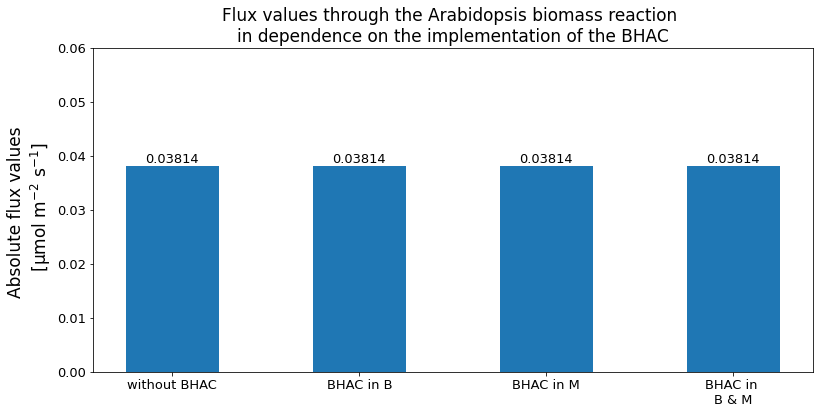

In [42]:
# plot to compare the values through the objective function (Arabidopsis biomass) between the 4 scenarios

biomass_val = [pFBA_noBHAC.get('[B]_Arabidopsis_biomass_tx'), pFBA_BHAC_B.get('[B]_Arabidopsis_biomass_tx'), pFBA_BHAC_M.get('[B]_Arabidopsis_biomass_tx'), pFBA_BHAC.get('[B]_Arabidopsis_biomass_tx')]

fig = plt.figure(figsize=(10,4.5))
ax = fig.add_axes([0,0,1,1])

# labels of a-axis
x_titles = ['without BHAC', 'BHAC in B', 'BHAC in M', 'BHAC in \nB & M']

# y-axis
ax.set(ylabel='Absolute flux values \n [\u03BCmol m$^{-2}$ s$^{-1}$]')
ax.set_ylim(0,0.06)

# title plot
ax.set_title('Flux values through the Arabidopsis biomass reaction \nin dependence on the implementation of the BHAC')

# plot data
#plt.bar(x_titles,biomass_val, width=0.5)

# plot data and add values to each bar
bars = ax.bar(x_titles, biomass_val, width=0.5)
ax.bar_label(bars)

plt.show()

## (p)FVA

In [43]:
# pFVA - BHAC
flux_variability_analysis(c4_model, reaction_list=bhac_c4, pfba_factor=1)

,minimum,maximum
[B]_AGAT_x,1.050031,1.050031
[B]_BHAA_x,0.930173,0.930173
[B]_BHAD_x,0.930173,0.930173
[B]_ISR_x,0.930173,0.930173
[M]_AGAT_x,0.000000,0.000000
[M]_BHAA_x,0.000000,0.000000
[M]_BHAD_x,0.000000,0.000000
[M]_ISR_x,0.000000,0.000000


In [44]:
# FVA - BHAC
flux_variability_analysis(c4_model, reaction_list=bhac_c4)

,minimum,maximum
[B]_AGAT_x,-1000.000000,1000.000000
[B]_BHAA_x,-481.464302,500.990180
[B]_BHAD_x,-481.464302,500.990180
[B]_ISR_x,-481.464302,500.990180
[M]_AGAT_x,-1000.000000,1000.000000
[M]_BHAA_x,-499.976418,482.394548
[M]_BHAD_x,-499.976418,482.394548
[M]_ISR_x,-499.976418,482.394548


In [45]:
rubisco_reactions = ['[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p', '[B]_RXN_961_p', '[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p', '[M]_RXN_961_p']

In [46]:
# pFVA - RuBisCO
flux_variability_analysis(c4_model, reaction_list=rubisco_reactions, pfba_factor=1)

,minimum,maximum
[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,19.802039,19.802039
[B]_RXN_961_p,1.980204,1.980204
[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,0.000000,0.000000
[M]_RXN_961_p,0.000000,0.000000


In [47]:
# FVA - RuBisCO
flux_variability_analysis(c4_model, reaction_list=rubisco_reactions)

,minimum,maximum
[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,19.803607,1.980361e+01
[B]_RXN_961_p,1.980361,1.980361e+00
[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,0.000000,1.053055e-12
[M]_RXN_961_p,0.000000,3.510183e-13


## Plots - General C4 Analyses

### Varying Rubisco Constraint in the BS cell

In [48]:
bhac_short = ['[M]_AGAT_x','[M]_BHAA_x','[B]_AGAT_x','[B]_BHAA_x']

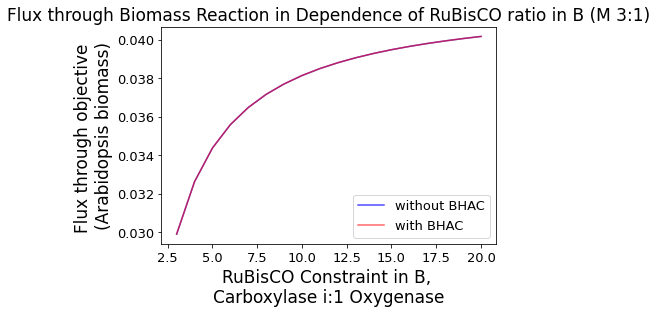

In [49]:
constraint = []
biomass_BHAC = []
bhac_impl = []
rubisco_impl = []
rub_ratio = []
with c4_model:
    c4_model.remove_cons_vars(const_rubisco)
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,250)
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,250)
    for i in range(3, 21, 1):
        const = c4_model.problem.Constraint(
            i * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id(
                "[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression, lb=0, ub=0)
        c4_model.add_cons_vars(const)

        constraint.append(i)
        rub_ratio.append('1:'+str(i))

        pfba_bhac = round(pfba(c4_model).fluxes, 6)
        biomass_BHAC.append(pfba_bhac.get('[B]_Arabidopsis_biomass_tx'))

        bhac_atp = []
        for i in bhac_short:
            bhac_atp.append(round(pfba_bhac.get(i),4))
        bhac_impl.append(bhac_atp)

        B_rub = pfba_bhac.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p')
        M_rub = pfba_bhac.get('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p')
        if B_rub != 0 and M_rub != 0:
            rubisco_impl.append('both')
        elif B_rub != 0:
            rubisco_impl.append('B')
        elif M_rub != 0:
            rubisco_impl.append('M')
        else:
            rubisco_impl.append('wrong')

        c4_model.remove_cons_vars(const)



biomass_noBHAC = []
with c4_model:
    c4_model.remove_cons_vars(const_rubisco)
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,250)
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,250)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in range(3, 21, 1):
        const = c4_model.problem.Constraint(
            i * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id(
                "[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression, lb=0, ub=0)
        c4_model.add_cons_vars(const)
        pfba_nobhac = round(pfba(c4_model).fluxes, 6)
        biomass_noBHAC.append(pfba_nobhac.get('[B]_Arabidopsis_biomass_tx'))
        c4_model.remove_cons_vars(const)


plt.plot(constraint, biomass_noBHAC, "b", alpha=.7)  # without BHAC in blue
plt.plot(constraint, biomass_BHAC, "r", alpha=.6)  # with BHAC in red
plt.xlabel("RuBisCO Constraint in B, \nCarboxylase i:1 Oxygenase")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of RuBisCO ratio in B (M 3:1)')
plt.show()

In [50]:
d_rubisco = {
    'Ox:Carbox in B': rub_ratio,
    '[M]_AGAT, [M]_BHAA, [B]_AGAT, [B]_BHAA': bhac_impl,
    'Rubisco': rubisco_impl
}
df_rubisco = pd.DataFrame(data=d_rubisco)

In [51]:
df_rubisco

,Ox:Carbox in B,"[M]_AGAT, [M]_BHAA, [B]_AGAT, [B]_BHAA",Rubisco
0,1:3,"[2.813, 2.813, 0.1365, 0.1365]",both
1,1:4,"[0.2262, 0.2262, 2.1238, 2.0213]",B
2,1:5,"[0.2383, 0.2383, 1.6995, 1.5915]",B
3,1:6,"[0.2467, 0.2467, 1.3466, 1.2931]",B
4,1:7,"[0.299, 0.299, 1.0278, 1.0278]",B
5,1:8,"[0.3046, 0.3046, 0.859, 0.859]",B
6,1:9,"[0.3091, 0.3091, 0.7257, 0.7257]",B
7,1:10,"[0.3126, 0.3126, 0.6176, 0.6176]",B
8,1:11,"[0.3156, 0.3156, 0.5283, 0.5283]",B
9,1:12,"[0.3181, 0.3181, 0.4532, 0.4532]",B


In [52]:
# difference between biomass values with/without BHAC with different RuBisCO constraints in the BS cell
counter = 0
print('Difference between biomasses (with BHAC - without BHAC) \nin dependence on RuBisCO constraint in BS cell (Carboxylase:Oxygenase)')
for i, j in zip(biomass_BHAC, biomass_noBHAC):
    print('1:'+str(constraint[counter]), '=', round((i - j), 6))
    counter += 1

Difference between biomasses (with BHAC - without BHAC) 
in dependence on RuBisCO constraint in BS cell (Carboxylase:Oxygenase)
1:3 = 5e-06
1:4 = 2e-06
1:5 = 2e-06
1:6 = 2e-06
1:7 = 1e-06
1:8 = 1e-06
1:9 = 1e-06
1:10 = 1e-06
1:11 = 1e-06
1:12 = 1e-06
1:13 = 1e-06
1:14 = 1e-06
1:15 = 1e-06
1:16 = 1e-06
1:17 = 1e-06
1:18 = 1e-06
1:19 = 0.0
1:20 = 0.0


### Photon uptake

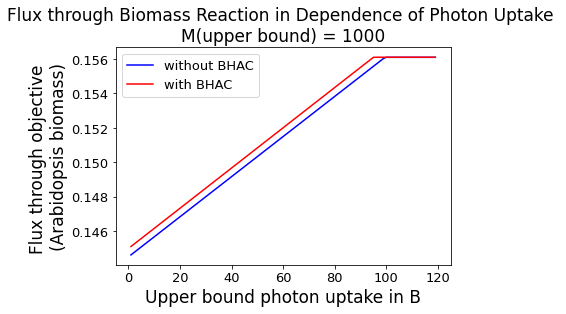

In [53]:
# Biomass in Dependence on light uptake in the BS cell with fixed amount of light uptake in the M cell (=1000)
biomass_light = []
light_x = []
with c4_model:
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,1000)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in range(1, 120, 1):
        c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,i)
        biomass_light.append(c4_model.optimize().objective_value)
        light_x.append(i)

biomass_light_BHAC = []
light_x_BHAC = []
with c4_model:
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,1000)
    for i in range(1, 120, 1):
        c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,i)
        biomass_light_BHAC.append(c4_model.optimize().objective_value)
        light_x_BHAC.append(i)

plt.plot(light_x, biomass_light, "b") # without BHAC in green
plt.plot(light_x_BHAC, biomass_light_BHAC, "r") # with BHAC in red
plt.xlabel("Upper bound photon uptake in B")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of Photon Uptake \nM(upper bound) = 1000')
plt.show()

In [54]:
# difference between biomass values with/without BHAC with different light uptakes
for i,j in zip(biomass_light_BHAC, biomass_light):
    print(round((i-j),5))

0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.00049
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.0005
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00051
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00052
0.00041
0.00029
0.00018
6e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


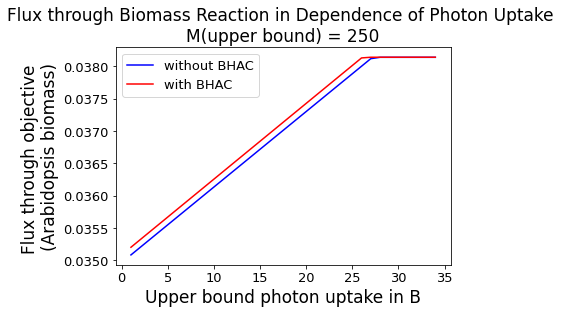

In [55]:
# Biomass in Dependence on light uptake in the BS cell with fixed amount of light uptake in the M cell (=250)
biomass_light = []
light_x = []
with c4_model:
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,250)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in range(1, 35, 1):
        c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,i)
        biomass_light.append(c4_model.optimize().objective_value)
        light_x.append(i)

biomass_light_BHAC = []
light_x_BHAC = []
with c4_model:
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,250)
    for i in range(1, 35, 1):
        c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,i)
        biomass_light_BHAC.append(c4_model.optimize().objective_value)
        light_x_BHAC.append(i)

plt.plot(light_x, biomass_light, "b") # without BHAC in blue
plt.plot(light_x_BHAC, biomass_light_BHAC, "r") # with BHAC in red
plt.xlabel("Upper bound photon uptake in B")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of Photon Uptake \nM(upper bound) = 250')
plt.show()

In [56]:
# difference between biomass values with/without BHAC with different light uptakes
for i,j in zip(biomass_light_BHAC, biomass_light):
    print(round((i-j),5))

0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00012
0.00013
0.00013
0.00013
0.00013
0.00013
0.00013
0.00013
0.00013
0.00013
2e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0


C:\Users\55lis\anaconda3\envs\C4_BHAC_CurrentTesting.ipynb\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


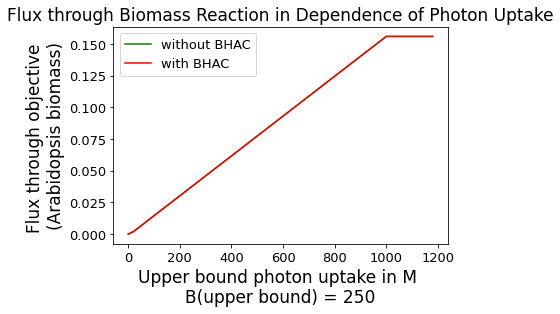

In [57]:
# Biomass in Dependence on light uptake in the M cell with fixed upper bound of light uptake in the BS cell (=250)
biomass_light = []
light_x = []
with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,250)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in range(0, 1200, 20):
        c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,i)
        if c4_model.optimize().status == 'infeasible':
            biomass_light.append(0)
            light_x.append(i)
        else:
            biomass_light.append(c4_model.optimize().objective_value)
            light_x.append(i)

biomass_light_BHAC = []
light_x_BHAC = []
with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,250)
    for i in range(0, 1200, 20):
        c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,i)
        if c4_model.optimize().status == 'infeasible':
            biomass_light_BHAC.append(0)
            light_x_BHAC.append(i)
        else:
            biomass_light_BHAC.append(c4_model.optimize().objective_value)
            light_x_BHAC.append(i)

plt.plot(light_x, biomass_light, "g") # without BHAC in green
plt.plot(light_x_BHAC, biomass_light_BHAC, "r") # with BHAC in red
plt.xlabel("Upper bound photon uptake in M \nB(upper bound) = 250")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of Photon Uptake')
plt.show()

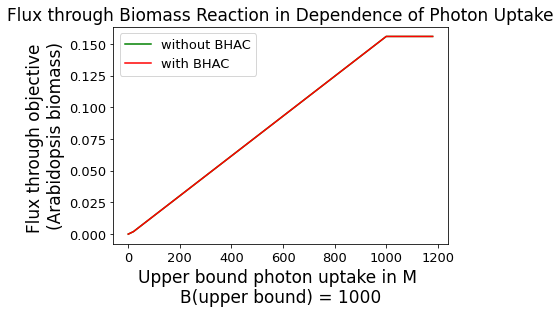

In [58]:
# Biomass in Dependence on light uptake in the M cell with fixed upper bound of light uptake in the BS cell (=1000)
biomass_light = []
light_x = []
with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,1000)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in range(0, 1200, 20):
        c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,i)
        if c4_model.optimize().status == 'infeasible':
            biomass_light.append(0)
            light_x.append(i)
        else:
            biomass_light.append(c4_model.optimize().objective_value)
            light_x.append(i)

biomass_light_BHAC = []
light_x_BHAC = []
with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,1000)
    for i in range(0, 1200, 20):
        c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,i)
        if c4_model.optimize().status == 'infeasible':
            biomass_light_BHAC.append(0)
            light_x_BHAC.append(i)
        else:
            biomass_light_BHAC.append(c4_model.optimize().objective_value)
            light_x_BHAC.append(i)

plt.plot(light_x, biomass_light, "g") # without BHAC in green
plt.plot(light_x_BHAC, biomass_light_BHAC, "r") # with BHAC in red
plt.xlabel("Upper bound photon uptake in M \nB(upper bound) = 1000")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of Photon Uptake')
plt.show()

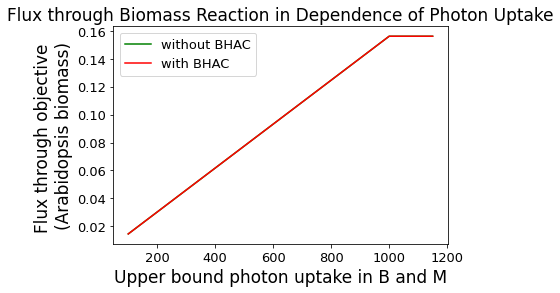

In [59]:
# Biomass in Dependence on light uptake in the M and the BS cell
biomass_light = []
light_x = []
with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in range(100, 1200, 50):
        c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,i)
        c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,i)
        biomass_light.append(c4_model.optimize().objective_value)
        light_x.append(i)

biomass_light_BHAC = []
light_x_BHAC = []
with c4_model:
    for i in range(100, 1200, 50):
        c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,i)
        c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,i)
        biomass_light_BHAC.append(c4_model.optimize().objective_value)
        light_x_BHAC.append(i)

plt.plot(light_x, biomass_light, "g") # without BHAC in green
plt.plot(light_x_BHAC, biomass_light_BHAC, "r") # with BHAC in red
plt.xlabel("Upper bound photon uptake in B and M")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of Photon Uptake')
plt.show()

### CO2 uptake

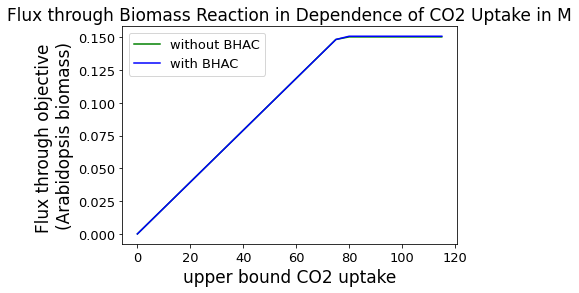

In [60]:
biomass_co2 = []
co2_x = []
biomass_co2_BHAC = []
co2_x_BHAC = []

with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,50)
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,1000)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in np.arange(0, 120, 5):
        c4_model.reactions.get_by_id("[M]_CO2_tx").bounds = (0, i)
        if c4_model.optimize().status == 'infeasible':
            biomass_co2.append(0)
            co2_x.append(i)
            #continue
        else:
            biomass_co2.append(c4_model.optimize().objective_value)
            co2_x.append(i)

with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,50)
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,1000)
    for i in np.arange(0, 120, 5):
        c4_model.reactions.get_by_id("[M]_CO2_tx").bounds = (0, i)
        if c4_model.optimize().status == 'infeasible':
            biomass_co2_BHAC.append(0)
            co2_x_BHAC.append(i)
            continue
        else:
            biomass_co2_BHAC.append(c4_model.optimize().objective_value)
            co2_x_BHAC.append(i)


plt.plot(co2_x, biomass_co2, "g") # without BHAC in green
plt.plot(co2_x_BHAC, biomass_co2_BHAC, "b") # with BHAC in blue
plt.xlabel("upper bound CO2 uptake")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of CO2 Uptake in M')
plt.show()

### Nitrate uptake

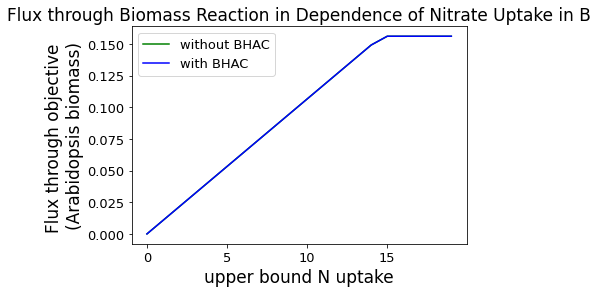

In [61]:
biomass_n = []
n_x = []
biomass_n_BHAC = []
n_x_BHAC = []

with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,1000)
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,1000)
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    for i in np.arange(0, 20, 1):
        c4_model.reactions.get_by_id("[B]_Nitrate_tx").bounds = (0, i)
        if c4_model.optimize().status == 'infeasible':
            biomass_n.append(0)
            n_x.append(i)
            #continue
        else:
            biomass_n.append(c4_model.optimize().objective_value)
            n_x.append(i)

with c4_model:
    c4_model.reactions.get_by_id("[B]_Photon_tx").bounds = (0,1000)
    c4_model.reactions.get_by_id("[M]_Photon_tx").bounds = (0,1000)
    for i in np.arange(0, 20, 1):
        c4_model.reactions.get_by_id("[B]_Nitrate_tx").bounds = (0, i)
        if c4_model.optimize().status == 'infeasible':
            biomass_n_BHAC.append(0)
            n_x_BHAC.append(i)
            #continue
        else:
            biomass_n_BHAC.append(c4_model.optimize().objective_value)
            n_x_BHAC.append(i)


plt.plot(n_x, biomass_n, "g") # without BHAC in green
plt.plot(n_x_BHAC, biomass_n_BHAC, "b") # with BHAC in blue
plt.xlabel("upper bound N uptake")
plt.ylabel("Flux through objective \n(Arabidopsis biomass)")
plt.legend(["without BHAC", "with BHAC"])
plt.title('Flux through Biomass Reaction in Dependence of Nitrate Uptake in B')
plt.show()

## Activity BHAC

In [62]:
print('BHAC active in both cell types:')
for i in bhac_c4:
    print(i, pFBA_BHAC.get(i))

print('\n')
print('BHAC active in Mesophyll:')
for i in bhac_c4:
    print(i, pFBA_BHAC_M.get(i))

print('\n')
print('BHAC active in Bundle Sheath:')
for i in bhac_c4:
    print(i, pFBA_BHAC_B.get(i))

BHAC active in both cell types:
[B]_AGAT_x 0.61761
[B]_BHAA_x 0.61761
[B]_BHAD_x 0.61761
[B]_ISR_x 0.61761
[M]_AGAT_x 0.31264
[M]_BHAA_x 0.31264
[M]_BHAD_x 0.31264
[M]_ISR_x 0.31264


BHAC active in Mesophyll:
[B]_AGAT_x 0.0
[B]_BHAA_x 0.0
[B]_BHAD_x 0.0
[B]_ISR_x 0.0
[M]_AGAT_x 0.93025
[M]_BHAA_x 0.93025
[M]_BHAD_x 0.93025
[M]_ISR_x 0.93025


BHAC active in Bundle Sheath:
[B]_AGAT_x 0.93025
[B]_BHAA_x 0.93025
[B]_BHAD_x 0.93025
[B]_ISR_x 0.93025
[M]_AGAT_x 0.0
[M]_BHAA_x 0.0
[M]_BHAD_x 0.0
[M]_ISR_x 0.0


## Photorespiration

In [63]:
print(c4_model.reactions.get_by_id('[B]_RXN_961_p').reaction)
print(c4_model.reactions.get_by_id('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p').reaction)

[B]_D_RIBULOSE_15_P2_p + [B]_OXYGEN_MOLECULE_p --> [B]_CPD_67_p + [B]_G3P_p + 2.0 [B]_PROTON_p
[B]_CARBON_DIOXIDE_p + [B]_D_RIBULOSE_15_P2_p + [B]_WATER_p --> 2.0 [B]_G3P_p + 2.0 [B]_PROTON_p


In [64]:
# Oxygenase reactions of Rubisco in M and B
print('BHAC not active:')
print('Oxygenase in M:', pFBA_noBHAC.get('[M]_RXN_961_p'))
print('Oxygenase in B:', pFBA_noBHAC.get('[B]_RXN_961_p'))

print('\n')
print('BHAC active in both cell types:')
print('Oxygenase in M:',pFBA_BHAC.get('[M]_RXN_961_p'))
print('Oxygenase in B:',pFBA_BHAC.get('[B]_RXN_961_p'))

print('\n')
print('BHAC active in Mesophyll:')
print('Oxygenase in M:',pFBA_BHAC_M.get('[M]_RXN_961_p'))
print('Oxygenase in B:',pFBA_BHAC_M.get('[B]_RXN_961_p'))

print('\n')
print('BHAC active in Bundle Sheath:')
print('Oxygenase in M:',pFBA_BHAC_B.get('[M]_RXN_961_p'))
print('Oxygenase in B:',pFBA_BHAC_B.get('[B]_RXN_961_p'))


BHAC not active:
Oxygenase in M: 0.0
Oxygenase in B: 1.9803


BHAC active in both cell types:
Oxygenase in M: 0.0
Oxygenase in B: 1.98036


BHAC active in Mesophyll:
Oxygenase in M: 0.0
Oxygenase in B: 1.98036


BHAC active in Bundle Sheath:
Oxygenase in M: 0.0
Oxygenase in B: 1.98036


In [65]:
# Carboxylase reactions of Rubisco in M and B
print('BHAC not active:')
print('Carboxylase in M:', pFBA_noBHAC.get('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print('Carboxylase in B:',pFBA_noBHAC.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))

print('\n')
print('BHAC active in both cell types:')
print('Carboxylase in M:',pFBA_BHAC.get('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print('Carboxylase in B:',pFBA_BHAC.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))

print('\n')
print('BHAC active in Mesophyll:')
print('Carboxylase in M:',pFBA_BHAC_M.get('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print('Carboxylase in B:',pFBA_BHAC_M.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))

print('\n')
print('BHAC active in Bundle Sheath:')
print('Carboxylase in M:',pFBA_BHAC_B.get('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print('Carboxylase in B:',pFBA_BHAC_B.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))

BHAC not active:
Carboxylase in M: 0.0
Carboxylase in B: 19.80302


BHAC active in both cell types:
Carboxylase in M: 0.0
Carboxylase in B: 19.80361


BHAC active in Mesophyll:
Carboxylase in M: 0.0
Carboxylase in B: 19.80361


BHAC active in Bundle Sheath:
Carboxylase in M: 0.0
Carboxylase in B: 19.80361


In [66]:
# glyoxylate
glyox_reactions = search_reactions('GLYOX', 'all', 'both')

There are 16 reactions including the following metabolites:
 ['[B]_GLYOX_x', '[M]_GLYOX_x'] 



In [67]:
print(flux_values_sum(glyox_reactions, 'no', plot='plot'))
print(flux_values_sum(glyox_reactions, 'both', plot='plot'))

3.9606
3.9607


In [68]:
# glyoxylate in M cell
glycolate_all_m = search_reactions('GLYCOLLATE', 'all', 'M')

There are 9 reactions including the following metabolites:
 ['[M]_GLYCOLLATE_p', '[M]_GLYCOLLATE_x', '[M]_GLYCOLLATE_c'] 



In [69]:
for i in glycolate_all_m:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)
    print(pFBA_noBHAC.get(i))
    print(pFBA_BHAC.get(i))
    print(pFBA_BHAC_M.get(i))
    print(pFBA_BHAC_B.get(i))
    print('-'*10)

[M]_GLYCOLLATE_pc : [M]_GLYCOLLATE_p <=> [M]_GLYCOLLATE_c
-0.93022
0.0
0.0
0.0
----------
[M]_GLYCERATE_GLYCOLLATE_pc : [M]_GLYCERATE_c + [M]_GLYCOLLATE_p <=> [M]_GLYCERATE_p + [M]_GLYCOLLATE_c
0.93022
0.0
0.0
0.0
----------
[MB]_GLYCOLLATE_c : [M]_GLYCOLLATE_c <=> [B]_GLYCOLLATE_c
-1.05776
-0.74515
-1.86049
-0.11987
----------
[M]_RXN_969_x : [M]_GLYCOLLATE_x + [M]_OXYGEN_MOLECULE_x --> [M]_GLYOX_x + [M]_HYDROGEN_PEROXIDE_x
1.05776
0.74515
1.86049
0.11987
----------
[M]_GPH_RXN_p : [M]_CPD_67_p + [M]_WATER_p --> [M]_GLYCOLLATE_p + [M]_Pi_p
0.0
0.0
0.0
0.0
----------
[M]_Glycolate_xc : [M]_GLYCOLLATE_x <=> [M]_GLYCOLLATE_c
-1.05776
-0.74515
-1.86049
-0.11987
----------


In [70]:
# glyoxylate in BS cell
glycolate_all_b = search_reactions('GLYCOLLATE', 'all', 'B')

There are 9 reactions including the following metabolites:
 ['[B]_GLYCOLLATE_p', '[B]_GLYCOLLATE_x', '[B]_GLYCOLLATE_c'] 



In [71]:
for i in glycolate_all_b:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)
    print(pFBA_noBHAC.get(i))
    print(pFBA_BHAC.get(i))
    print(pFBA_BHAC_M.get(i))
    print(pFBA_BHAC_B.get(i))
    print('-'*10)

[B]_GLYCOLLATE_pc : [B]_GLYCOLLATE_p <=> [B]_GLYCOLLATE_c
1.9803
1.98036
1.98036
1.98036
----------
[B]_Glycolate_xc : [B]_GLYCOLLATE_x <=> [B]_GLYCOLLATE_c
-0.92254
-1.23521
-0.11987
-1.86049
----------
[B]_GPH_RXN_p : [B]_CPD_67_p + [B]_WATER_p --> [B]_GLYCOLLATE_p + [B]_Pi_p
1.9803
1.98036
1.98036
1.98036
----------
[MB]_GLYCOLLATE_c : [M]_GLYCOLLATE_c <=> [B]_GLYCOLLATE_c
-1.05776
-0.74515
-1.86049
-0.11987
----------
[B]_GLYCERATE_GLYCOLLATE_pc : [B]_GLYCERATE_c + [B]_GLYCOLLATE_p <=> [B]_GLYCERATE_p + [B]_GLYCOLLATE_c
0.0
0.0
0.0
0.0
----------
[B]_RXN_969_x : [B]_GLYCOLLATE_x + [B]_OXYGEN_MOLECULE_x --> [B]_GLYOX_x + [B]_HYDROGEN_PEROXIDE_x
0.92254
1.23521
0.11987
1.86049
----------


In [72]:
# later reactions of photorespiration
for i in c4_model.metabolites.get_by_id('[M]_GLYCERATE_x').reactions:
    print(i)

[M]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x: [M]_NADH_x + [M]_OH_PYR_x + [M]_PROTON_x --> [M]_GLYCERATE_x + [M]_NAD_x
[M]_Glycerate_xc: [M]_GLYCERATE_x <=> [M]_GLYCERATE_c


In [73]:
# last step PR (using ATP)
print(pFBA_noBHAC.get('[M]_GLY3KIN_RXN_p'))
print(pFBA_BHAC.get('[M]_GLY3KIN_RXN_p'))
print(pFBA_BHAC_M.get('[M]_GLY3KIN_RXN_p'))
print(pFBA_BHAC_B.get('[M]_GLY3KIN_RXN_p'))

0.93022
0.0
0.0
0.0


In [74]:
# hydroxypyruvate to glycerate (using NADH)
print(pFBA_noBHAC.get('[M]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x'))
print(pFBA_BHAC.get('[M]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x'))
print(pFBA_BHAC_M.get('[M]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x'))
print(pFBA_BHAC_B.get('[M]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x'))

0.00768
0.0
0.0
0.0


In [75]:
for i in c4_model.metabolites.get_by_id('[M]_OH_PYR_x').reactions:
    print(i)

[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x: [M]_GLYOX_x + [M]_SER_x --> [M]_GLY_x + [M]_OH_PYR_x
[M]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x: [M]_NADH_x + [M]_OH_PYR_x + [M]_PROTON_x --> [M]_GLYCERATE_x + [M]_NAD_x


In [76]:
# serine to hydroxypyruvate
print(pFBA_noBHAC.get('[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC.get('[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC_M.get('[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC_B.get('[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))

0.00768
0.0
0.0
0.0


In [77]:
for i in c4_model.metabolites.get_by_id('[M]_GLY_m').reactions:
    print(i)

[M]_GCVMULTI_RXN_m: [M]_GLY_m + [M]_NAD_m + [M]_THF_m --> [M]_AMMONIUM_m + [M]_CARBON_DIOXIDE_m + [M]_METHYLENE_THF_m + [M]_NADH_m
[M]_GLY_mc: [M]_GLY_m <=> [M]_GLY_c
[M]_GLYOHMETRANS_RXN_m: [M]_SER_m + [M]_THF_m <=> [M]_GLY_m + [M]_METHYLENE_THF_m + [M]_WATER_m


In [78]:
# glycine to NH4/CO2/NADH in the M cell
print(pFBA_noBHAC.get('[M]_GCVMULTI_RXN_m'))
print(pFBA_BHAC.get('[M]_GCVMULTI_RXN_m'))
print(pFBA_BHAC_M.get('[M]_GCVMULTI_RXN_m'))
print(pFBA_BHAC_B.get('[M]_GCVMULTI_RXN_m'))

0.0
0.0
0.0
0.0


In [79]:
# glycine to serine in the M cell
print(pFBA_noBHAC.get('[M]_GLYOHMETRANS_RXN_m'))
print(pFBA_BHAC.get('[M]_GLYOHMETRANS_RXN_m'))
print(pFBA_BHAC_M.get('[M]_GLYOHMETRANS_RXN_m'))
print(pFBA_BHAC_B.get('[M]_GLYOHMETRANS_RXN_m'))

0.0
0.0
0.0
0.0


In [80]:
c4_model.reactions.get_by_id('[B]_GLYOHMETRANS_RXN_m')

Reaction identifier,[B]_GLYOHMETRANS_RXN_m
Name,GLYOHMETRANS-RXN:NIL
Memory address,0x2223021fd88
Stoichiometry,[B]_SER_m + [B]_THF_m <=> [B]_GLY_m + [B]_METHYLENE_THF_m + [B]_WATER_m C3H7N1O3 + C19H21N7O6 <=> C2H5N1O2 + C20H21N7O6 + H2O1
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [81]:
# glycine to NH4/CO2/NADH in the BS cell
print(pFBA_noBHAC.get('[B]_GCVMULTI_RXN_m'))
print(pFBA_BHAC.get('[B]_GCVMULTI_RXN_m'))
print(pFBA_BHAC_M.get('[B]_GCVMULTI_RXN_m'))
print(pFBA_BHAC_B.get('[B]_GCVMULTI_RXN_m'))

1.34552
0.41531
0.41531
0.41531


## C4 subtypes

In [82]:
# PEP-CK
print('PEP-CK:')
print('BHAC:', pFBA_BHAC.get('[B]_PEPCARBOXYKIN_RXN_c'))
print('BHAC in B:', pFBA_BHAC_B.get('[B]_PEPCARBOXYKIN_RXN_c'))
print('BHAC in M:', pFBA_BHAC_M.get('[B]_PEPCARBOXYKIN_RXN_c'))
print('no BHAC:', pFBA_noBHAC.get('[B]_PEPCARBOXYKIN_RXN_c'))

print('-'*10)

# NADP-ME
print('NADP-ME:')
print('BHAC:', pFBA_BHAC.get('[B]_MALIC_NADP_RXN_p'))
print('BHAC in B:', pFBA_BHAC_B.get('[B]_MALIC_NADP_RXN_p'))
print('BHAC in M:', pFBA_BHAC_M.get('[B]_MALIC_NADP_RXN_p'))
print('no BHAC:', pFBA_noBHAC.get('[B]_MALIC_NADP_RXN_p'))

print('-'*10)

# NAD-ME
print('NAD-ME:')
print('BHAC:', pFBA_BHAC.get('[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m'))
print('BHAC in B:', pFBA_BHAC_B.get('[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m'))
print('BHAC in M:', pFBA_BHAC_M.get('[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m'))
print('no BHAC:', pFBA_noBHAC.get('[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m'))

PEP-CK:
BHAC: 16.4139
BHAC in B: 16.4139
BHAC in M: 16.4139
no BHAC: 15.48139
----------
NADP-ME:
BHAC: 1.39571
BHAC in B: 1.39571
BHAC in M: 1.39571
no BHAC: 1.39748
----------
NAD-ME:
BHAC: 0.0
BHAC in B: 0.0
BHAC in M: 0.0
no BHAC: 0.0


## ATP & NAD(P)

In [83]:
# all ATP reactions
atp_reactions = search_reactions('ATP', 'all', 'both')

There are 232 reactions including the following metabolites:
 ['[B]_ATP_p', '[B]_ATP_m', '[B]_ATP_c', '[B]_ATP_x', '[M]_ATP_p', '[M]_ATP_m', '[M]_ATP_c', '[M]_ATP_x'] 



In [84]:
# ATP flux sums
print('ATP flux sums (all reactions)')
print('without BHAC:', flux_values_sum(atp_reactions, 'no', plot='plot'))
print('with BHAC in M and B:', flux_values_sum(atp_reactions, 'both', plot='plot'))
print('with BHAC in M:', flux_values_sum(atp_reactions, 'M', plot='plot'))
print('with BHAC in B:', flux_values_sum(atp_reactions, 'B', plot='plot'))

ATP flux sums (all reactions)
without BHAC: 376.2004
with BHAC in M and B: 383.9443
with BHAC in M: 381.3813
with BHAC in B: 360.7591


In [85]:
atp_list = []
for i in atp_reactions:
    atp_list.append(i)

In [86]:
atp_BHAC = round(pfba(c4_model, reactions=atp_list).fluxes, 4)

In [87]:
with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    atp_noBHAC = round(pfba(c4_model, reactions=atp_list).fluxes, 4)

In [88]:
with c4_model:
    for i in bhac_m:
        c4_model.reactions.get_by_id(i).knock_out()
    atp_BHAC_B = round(pfba(c4_model, reactions=atp_list).fluxes, 4)

In [89]:
with c4_model:
    for i in bhac_b:
        c4_model.reactions.get_by_id(i).knock_out()
    atp_BHAC_M = round(pfba(c4_model, reactions=atp_list).fluxes, 4)

In [90]:
# Compare ATP reactions: without BHAC vs. BHAC in both cell types
compare_flux_distribution(atp_noBHAC, atp_BHAC)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_PHOSGLYPHOS_RXN_p,0.3215,-0.6137,0.9352,90.8865
1,[B]_PEPCARBOXYKIN_RXN_c,15.4814,16.4139,0.9325,6.0234
2,[B]_ATP_AMP_mc,27.6057,29.2377,1.6320,5.9118
3,[B]_ADENYL_KIN_RXN_m,27.6057,29.2377,1.6320,5.9118
4,[B]_ATP_ADP_mc,-55.2114,-58.4754,3.2640,5.9118
5,[B]_ADENYL_KIN_RXN_c,-27.6057,-29.2377,1.6320,5.9118
6,[B]_PHOSGLYPHOS_RXN_c,-26.3844,-27.3118,0.9274,3.515
7,[M]_PHOSGLYPHOS_RXN_p,69.9757,71.8395,1.8638,2.6635
8,[M]_ADENYL_KIN_RXN_m,-63.0536,-64.3727,1.3191,2.092
9,[M]_ATP_ADP_mc,126.1072,128.7454,2.6382,2.092


In [91]:
# Compare ATP reactions: without BHAC vs. BHAC in BS
compare_flux_distribution(atp_noBHAC, atp_BHAC_B)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_PHOSGLYPHOS_RXN_p,0.3215,-0.6137,0.9352,90.8865
1,[B]_PEPCARBOXYKIN_RXN_c,15.4814,16.4139,0.9325,6.0234
2,[B]_PHOSGLYPHOS_RXN_c,-26.3844,-27.3118,0.9274,3.515
3,[M]_PHOSGLYPHOS_RXN_p,69.9757,71.8395,1.8638,2.6635
4,[M]_PRPPSYN_RXN_p,0.0466,0.0467,0.0001,0.2146
5,[M]_GDPKIN_RXN_p,0.0466,0.0467,0.0001,0.2146
6,[B]_GDPKIN_RXN_c,0.4061,0.4062,0.0001,0.0246
7,[M]_HOMOSERKIN_RXN_p,1.3548,1.3549,0.0001,0.0074
8,[M]_ASPARTATEKIN_RXN_p,1.3548,1.3549,0.0001,0.0074
9,[B]_PROTON_ATPase_c,7.4648,7.4651,0.0003,0.004


In [92]:
# Compare ATP reactions: with BHAC vs. BHAC in BS
compare_flux_distribution(atp_BHAC, atp_BHAC_B)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_ATP_AMP_mc,29.2377,23.5750,5.6627,-19.3678
1,[B]_ADENYL_KIN_RXN_m,29.2377,23.5750,5.6627,-19.3678
2,[B]_ADENYL_KIN_RXN_c,-29.2377,-23.5750,5.6627,-19.3678
3,[B]_ATP_ADP_mc,-58.4754,-47.1501,11.3253,-19.3676
4,[M]_ATP_ADP_mc,128.7454,116.8855,11.8599,-9.2119
5,[M]_ADENYL_KIN_RXN_m,-64.3727,-58.4428,5.9299,-9.2118
6,[M]_ATP_AMP_mc,-64.3727,-58.4428,5.9299,-9.2118
7,[M]_ADENYL_KIN_RXN_c,65.6529,59.7230,5.9299,-9.0322


In [93]:
# Compare ATP reactions: with BHAC vs. BHAC in M
compare_flux_distribution(atp_BHAC, atp_BHAC_M)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_UDPKIN_RXN_c,0.0000,0.4056,0.4056,activated
1,[B]_GDPKIN_RXN_c,0.4062,0.0006,0.4056,-99.8523
2,[B]_ATP_AMP_mc,29.2377,28.7228,0.5149,-1.7611
3,[B]_ADENYL_KIN_RXN_m,29.2377,28.7228,0.5149,-1.7611
4,[B]_ATP_ADP_mc,-58.4754,-57.4456,1.0298,-1.7611
5,[B]_ADENYL_KIN_RXN_c,-29.2377,-28.7228,0.5149,-1.7611
6,[M]_ADENYL_KIN_RXN_m,-64.3727,-63.6061,0.7666,-1.1909
7,[M]_ATP_ADP_mc,128.7454,127.2122,1.5332,-1.1909
8,[M]_ATP_AMP_mc,-64.3727,-63.6061,0.7666,-1.1909
9,[M]_ADENYL_KIN_RXN_c,65.6529,64.8863,0.7666,-1.1677


In [94]:
# reactions that have lower flux with BHAC
print('[M]_GLUTAMINESYN_RXN_p:', c4_model.reactions.get_by_id('[M]_GLUTAMINESYN_RXN_p').reaction)
print('[B]_Plastidial_ATP_Synthase_p:', c4_model.reactions.get_by_id('[B]_Plastidial_ATP_Synthase_p').reaction)
print('[M]_GLY3KIN_RXN_p:', c4_model.reactions.get_by_id('[M]_GLY3KIN_RXN_p').reaction)

[M]_GLUTAMINESYN_RXN_p: [M]_AMMONIUM_p + [M]_ATP_p + [M]_GLT_p --> [M]_ADP_p + [M]_GLN_p + 0.9 [M]_PROTON_p + [M]_Pi_p
[B]_Plastidial_ATP_Synthase_p: 3.0 [B]_ADP_p + 14.0 [B]_PROTON_l + 3.0 [B]_Pi_p --> 3.0 [B]_ATP_p + 10.3 [B]_PROTON_p + 3.0 [B]_WATER_p
[M]_GLY3KIN_RXN_p: [M]_ATP_p + [M]_GLYCERATE_p --> [M]_ADP_p + [M]_G3P_p + 0.9 [M]_PROTON_p


In [95]:
# reactions that have higher flux with BHAC
print('[M]_PHOSGLYPHOS_RXN_p:', c4_model.reactions.get_by_id('[M]_PHOSGLYPHOS_RXN_p').reaction)
print('[B]_PHOSGLYPHOS_RXN_p:', c4_model.reactions.get_by_id('[B]_PHOSGLYPHOS_RXN_p').reaction)
print('[B]_PEPCARBOXYKIN_RXN_c:', c4_model.reactions.get_by_id('[B]_PEPCARBOXYKIN_RXN_c').reaction)

[M]_PHOSGLYPHOS_RXN_p: [M]_ATP_p + [M]_G3P_p + 0.1 [M]_PROTON_p <=> [M]_ADP_p + [M]_DPG_p
[B]_PHOSGLYPHOS_RXN_p: [B]_ATP_p + [B]_G3P_p + 0.1 [B]_PROTON_p <=> [B]_ADP_p + [B]_DPG_p
[B]_PEPCARBOXYKIN_RXN_c: [B]_ATP_c + [B]_OXALACETIC_ACID_c + 0.15 [B]_PROTON_c --> [B]_ADP_c + [B]_CARBON_DIOXIDE_c + [B]_PHOSPHO_ENOL_PYRUVATE_c


In [96]:
# reaction that make the most differences between no and with BHAC (transport reactions excluded)
print('[B]_ADENYL_KIN_RXN_m:', c4_model.reactions.get_by_id('[B]_ADENYL_KIN_RXN_m').reaction)
print('[B]_ADENYL_KIN_RXN_c:', c4_model.reactions.get_by_id('[B]_ADENYL_KIN_RXN_c').reaction)
print('[M]_ADENYL_KIN_RXN_m:', c4_model.reactions.get_by_id('[M]_ADENYL_KIN_RXN_m').reaction)
print('[M]_ADENYL_KIN_RXN_c:', c4_model.reactions.get_by_id('[M]_ADENYL_KIN_RXN_c').reaction)

[B]_ADENYL_KIN_RXN_m: [B]_AMP_m + [B]_ATP_m + 0.3 [B]_PROTON_m <=> 2.0 [B]_ADP_m
[B]_ADENYL_KIN_RXN_c: [B]_AMP_c + [B]_ATP_c <=> 2.0 [B]_ADP_c + 0.35 [B]_PROTON_c
[M]_ADENYL_KIN_RXN_m: [M]_AMP_m + [M]_ATP_m + 0.3 [M]_PROTON_m <=> 2.0 [M]_ADP_m
[M]_ADENYL_KIN_RXN_c: [M]_AMP_c + [M]_ATP_c <=> 2.0 [M]_ADP_c + 0.35 [M]_PROTON_c


In [97]:
# reactions that make the most differences between no and with BHAC (transport reactions)
print('[B]_ATP_ADP_mc:', c4_model.reactions.get_by_id('[B]_ATP_ADP_mc').reaction)
print('[B]_ATP_AMP_mc:', c4_model.reactions.get_by_id('[B]_ATP_AMP_mc').reaction)
print('[M]_ATP_ADP_mc:', c4_model.reactions.get_by_id('[M]_ATP_ADP_mc').reaction)
print('[M]_ATP_AMP_mc:', c4_model.reactions.get_by_id('[M]_ATP_AMP_mc').reaction)

[B]_ATP_ADP_mc: [B]_ADP_c + [B]_ATP_m + 0.1 [B]_PROTON_m <=> [B]_ADP_m + [B]_ATP_c + 0.15 [B]_PROTON_c
[B]_ATP_AMP_mc: [B]_AMP_c + [B]_ATP_m + 0.35 [B]_PROTON_c <=> [B]_AMP_m + [B]_ATP_c + 0.1 [B]_PROTON_m
[M]_ATP_ADP_mc: [M]_ADP_c + [M]_ATP_m + 0.1 [M]_PROTON_m <=> [M]_ADP_m + [M]_ATP_c + 0.15 [M]_PROTON_c
[M]_ATP_AMP_mc: [M]_AMP_c + [M]_ATP_m + 0.35 [M]_PROTON_c <=> [M]_AMP_m + [M]_ATP_c + 0.1 [M]_PROTON_m


In [98]:
# ATP in M cell
atp_m = search_reactions('ATP', 'all', 'M')

There are 116 reactions including the following metabolites:
 ['[M]_ATP_p', '[M]_ATP_m', '[M]_ATP_c', '[M]_ATP_x'] 



In [99]:
print(flux_values_sum(atp_m, 'no', plot='plot'))
print(flux_values_sum(atp_m, 'both', plot='plot'))
print(flux_values_sum(atp_m, 'M', plot='plot'))
print(flux_values_sum(atp_m, 'B', plot='plot'))

240.0736
242.7119
241.1786
230.852


In [100]:
# ATP in BS cell
atp_b = search_reactions('ATP', 'all', 'B')

There are 116 reactions including the following metabolites:
 ['[B]_ATP_p', '[B]_ATP_m', '[B]_ATP_c', '[B]_ATP_x'] 



In [101]:
print(flux_values_sum(atp_b, 'no', plot='plot'))
print(flux_values_sum(atp_b, 'both', plot='plot'))
print(flux_values_sum(atp_b, 'M', plot='plot'))
print(flux_values_sum(atp_b, 'B', plot='plot'))

136.1268
141.2324
140.2026
129.9071


In [102]:
# all NAD+ reactions
nad_reactions = search_reactions('NAD', 'all', 'both')

There are 150 reactions including the following metabolites:
 ['[B]_NAD_c', '[B]_NAD_m', '[B]_NAD_p', '[B]_NAD_x', '[M]_NAD_c', '[M]_NAD_m', '[M]_NAD_p', '[M]_NAD_x'] 



In [103]:
# NAD flux sums
print(flux_values_sum(nad_reactions, 'no', plot='plot'))
print(flux_values_sum(nad_reactions, 'both', plot='plot'))
print(flux_values_sum(nad_reactions, 'M', plot='plot'))
print(flux_values_sum(nad_reactions, 'B', plot='plot'))

126.9718
128.1918
128.1918
128.1918


In [104]:
# NAD in the M cell
nad_m = search_reactions('NAD', 'all', 'M')

There are 75 reactions including the following metabolites:
 ['[M]_NAD_c', '[M]_NAD_m', '[M]_NAD_p', '[M]_NAD_x'] 



In [105]:
print(flux_values_sum(nad_m, 'no', plot='plot'))
print(flux_values_sum(nad_m, 'both', plot='plot'))
print(flux_values_sum(nad_m, 'M', plot='plot'))
print(flux_values_sum(nad_m, 'B', plot='plot'))

66.5982
69.0765
70.3117
68.4512


In [106]:
# NAD in the BS cell
nad_b = search_reactions('NAD', 'all', 'B')

There are 75 reactions including the following metabolites:
 ['[B]_NAD_c', '[B]_NAD_m', '[B]_NAD_p', '[B]_NAD_x'] 



In [107]:
print(flux_values_sum(nad_b, 'no', plot='plot'))
print(flux_values_sum(nad_b, 'both', plot='plot'))
print(flux_values_sum(nad_b, 'M', plot='plot'))
print(flux_values_sum(nad_b, 'B', plot='plot'))

60.3736
59.1153
57.8801
59.7406


In [108]:
# compare flux distributions without & with BHAC for NAD reactions
nad_list = []
for i in nad_reactions:
    nad_list.append(i)
nad_BHAC = round(pfba(c4_model, reactions=nad_list).fluxes, 4)
with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    nad_noBHAC = round(pfba(c4_model, reactions=nad_list).fluxes, 4)

compare_flux_distribution(nad_noBHAC, nad_BHAC)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_ISR_x,0.0000,0.6176,0.6176,activated
1,[M]_ISR_x,0.0000,0.3126,0.3126,activated
2,[M]_MALATE_DEH_RXN_x,0.0077,0.3126,0.3049,3959.7403
3,[B]_GAPOXNPHOSPHN_RXN_p,-0.3215,0.6137,0.9352,90.8865
4,[B]_MALATE_DEH_RXN_c,-22.9237,-23.8510,0.9273,4.0452
5,[B]_GAPOXNPHOSPHN_RXN_c,26.3844,27.3118,0.9274,3.515
6,[M]_GAPOXNPHOSPHN_RXN_p,-26.8706,-27.8047,0.9341,3.4763
7,[M]_MALATE_DEH_RXN_p,27.0308,27.9649,0.9341,3.4557
8,[B]_GLUTAMATE_SYNTHASE_NADH_RXN_p,0.8486,0.8487,0.0001,0.0118
9,[B]_NITRATE_REDUCTASE_NADH_RXN_c,3.5788,3.5789,0.0001,0.0028


In [109]:
print('MALATE_DEH_RXN:', c4_model.reactions.get_by_id('[B]_MALATE_DEH_RXN_x').reaction)

MALATE_DEH_RXN: [B]_MAL_x + [B]_NAD_x <=> [B]_NADH_x + [B]_OXALACETIC_ACID_x + [B]_PROTON_x


In [110]:
print('GAPOXNPHOSPHN_RXN:', c4_model.reactions.get_by_id('[M]_GAPOXNPHOSPHN_RXN_p').reaction)

GAPOXNPHOSPHN_RXN: [M]_GAP_p + [M]_NAD_p + [M]_Pi_p <=> [M]_DPG_p + [M]_NADH_p + [M]_PROTON_p


In [111]:
# all NADP reactions
nadp_reactions = search_reactions('NADP', 'all', 'both')

There are 126 reactions including the following metabolites:
 ['[B]_NADP_x', '[B]_NADP_p', '[B]_NADP_m', '[B]_NADP_c', '[M]_NADP_x', '[M]_NADP_p', '[M]_NADP_m', '[M]_NADP_c'] 



In [112]:
# NADP flux sums
print(flux_values_sum(nadp_reactions, 'no', plot='plot'))
print(flux_values_sum(nadp_reactions, 'both', plot='plot'))
print(flux_values_sum(nadp_reactions, 'M', plot='plot'))
print(flux_values_sum(nadp_reactions, 'B', plot='plot'))

96.8816
98.7395
98.7395
98.7395


In [113]:
# NADP in the M cell
nadp_m = search_reactions('NADP', 'all', 'M')

There are 63 reactions including the following metabolites:
 ['[M]_NADP_x', '[M]_NADP_p', '[M]_NADP_m', '[M]_NADP_c'] 



In [114]:
print(flux_values_sum(nadp_m, 'no', plot='plot'))
print(flux_values_sum(nadp_m, 'both', plot='plot'))
print(flux_values_sum(nadp_m, 'M', plot='plot'))
print(flux_values_sum(nadp_m, 'B', plot='plot'))

93.9517
95.8114
95.8114
95.8114


In [115]:
# NADP in the BS cell
nadp_b = search_reactions('NADP', 'all', 'B')

There are 63 reactions including the following metabolites:
 ['[B]_NADP_x', '[B]_NADP_p', '[B]_NADP_m', '[B]_NADP_c'] 



In [116]:
print(flux_values_sum(nadp_b, 'no', plot='plot'))
print(flux_values_sum(nadp_b, 'both', plot='plot'))
print(flux_values_sum(nadp_b, 'M', plot='plot'))
print(flux_values_sum(nadp_b, 'B', plot='plot'))

2.9299
2.9281
2.9281
2.9281


In [117]:
# compare flux distributions without and with BHAc for the NADP reactions
nadp_list = []
for i in nadp_reactions:
    nadp_list.append(i)
nadp_BHAC = round(pfba(c4_model, reactions=nadp_list).fluxes, 4)
with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    nadp_noBHAC = round(pfba(c4_model, reactions=nadp_list).fluxes, 4)

compare_flux_distribution(nadp_noBHAC, nadp_BHAC)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p,0.0000,0.0652,0.0652,activated
1,[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p,43.1051,44.0348,0.9297,2.1568
2,[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p,47.5970,48.5268,0.9298,1.9535
3,[M]_ASPARTATE_SEMIALDEHYDE_DEHYDROGENASE_RXN_p,1.3548,1.3549,0.0001,0.0074
4,[M]_HOMOSERDEHYDROG_RXN_NADP_p,1.3548,1.3549,0.0001,0.0074
5,[B]_RXN_5682_p,0.0652,0.0000,0.0652,deactivated
6,[B]_NADPHoxp_tx,0.5877,0.5859,0.0018,-0.3063
7,[B]_MALIC_NADP_RXN_p,1.3975,1.3957,0.0018,-0.1288


In [118]:
print('[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p:', c4_model.reactions.get_by_id('[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p').reaction)
print('[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p:', c4_model.reactions.get_by_id('[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p').reaction)

[M]_1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p: [M]_NADP_p + [M]_PROTON_p + 2.0 [M]_Reduced_ferredoxins_p <=> [M]_NADPH_p + 2.0 [M]_Oxidized_ferredoxins_p
[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p: [M]_DPG_p + [M]_NADPH_p + [M]_PROTON_p --> [M]_GAP_p + [M]_NADP_p + [M]_Pi_p


In [119]:
print('[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p:', c4_model.reactions.get_by_id('[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p').reaction)
print('[B]_RXN_5682_p:', c4_model.reactions.get_by_id('[B]_RXN_5682_p').reaction)

[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p: [B]_NADP_p + [B]_PREPHENATE_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_P_HYDROXY_PHENYLPYRUVATE_p
[B]_RXN_5682_p: [B]_CPD_659_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_TYR_p


In [120]:
# Create Plots to show ATP/NAD/NADP flux sums depending on BHAC localisation

In [121]:
atp_fluxes = [flux_values_sum(atp_m, 'no', plot='plot'), flux_values_sum(atp_b, 'no', plot='plot'), flux_values_sum(atp_m, 'both', plot='plot'), flux_values_sum(atp_b, 'both', plot='plot'), flux_values_sum(atp_m, 'M', plot='plot'), flux_values_sum(atp_b, 'M', plot='plot'), flux_values_sum(atp_m, 'B', plot='plot'), flux_values_sum(atp_b, 'B', plot='plot')]

In [122]:
nad_fluxes = [flux_values_sum(nad_m, 'no', plot='plot'), flux_values_sum(nad_b, 'no', plot='plot'), flux_values_sum(nad_m, 'both', plot='plot'), flux_values_sum(nad_b, 'both', plot='plot'), flux_values_sum(nad_m, 'M', plot='plot'), flux_values_sum(nad_b, 'M', plot='plot'), flux_values_sum(nad_m, 'B', plot='plot'), flux_values_sum(nad_b, 'B', plot='plot')]

In [123]:
nadp_fluxes = [flux_values_sum(nadp_m, 'no', plot='plot'), flux_values_sum(nadp_b, 'no', plot='plot'), flux_values_sum(nadp_m, 'both', plot='plot'), flux_values_sum(nadp_b, 'both', plot='plot'), flux_values_sum(nadp_m, 'M', plot='plot'), flux_values_sum(nadp_b, 'M', plot='plot'), flux_values_sum(nadp_m, 'B', plot='plot'), flux_values_sum(nadp_b, 'B', plot='plot')]

In [124]:
nad_p_fluxes = []
for i, j in zip(nad_fluxes, nadp_fluxes):
    nad_p_fluxes.append(i+j)

In [125]:
energy_status = ['no', 'no','in M/B','in M/B','in M','in M','in B','in B',]
x_labels = ['Mesophyll', 'Bundle Sheath', 'Mesophyll', 'Bundle Sheath', 'Mesophyll', 'Bundle Sheath', 'Mesophyll', 'Bundle Sheath']

In [126]:
d_atp = {
    'fluxes': atp_fluxes,
    'BHAC implementation': energy_status,
    'x-labels': x_labels
}

In [127]:
df_atp = pd.DataFrame(data=d_atp)

In [128]:
df_atp

,fluxes,BHAC implementation,x-labels
0,240.0736,no,Mesophyll
1,136.1268,no,Bundle Sheath
2,242.7119,in M/B,Mesophyll
3,141.2324,in M/B,Bundle Sheath
4,241.1786,in M,Mesophyll
5,140.2026,in M,Bundle Sheath
6,230.8520,in B,Mesophyll
7,129.9071,in B,Bundle Sheath


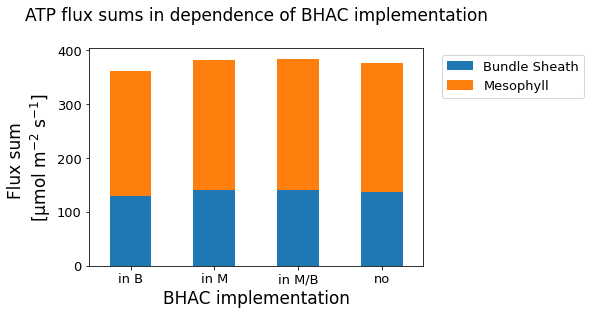

In [129]:
chart = df_atp.pivot_table(index="BHAC implementation", columns="x-labels", values="fluxes")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux sum \n[\u03BCmol m$^{-2}$ s$^{-1}$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5), ncol = 1)
plt.rcParams["axes.titley"] = 1.1
plt.title("ATP flux sums in dependence of BHAC implementation")
#plt.savefig('figures/C4/ATP_flux_sum.png', format='jpeg', bbox_inches = 'tight', dpi=400)
plt.show()

In [130]:
d_nad = {
    'fluxes': nad_fluxes,
    'BHAC implementation': energy_status,
    'x-labels': x_labels
}

In [131]:
df_nad = pd.DataFrame(data=d_nad)

In [132]:
df_nad

,fluxes,BHAC implementation,x-labels
0,66.5982,no,Mesophyll
1,60.3736,no,Bundle Sheath
2,69.0765,in M/B,Mesophyll
3,59.1153,in M/B,Bundle Sheath
4,70.3117,in M,Mesophyll
5,57.8801,in M,Bundle Sheath
6,68.4512,in B,Mesophyll
7,59.7406,in B,Bundle Sheath


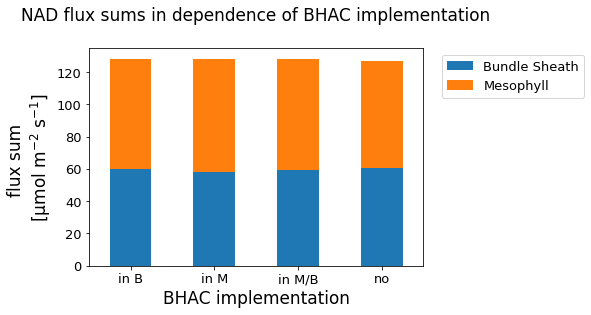

In [133]:
chart = df_nad.pivot_table(index="BHAC implementation", columns="x-labels", values="fluxes")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "flux sum \n[\u03BCmol m$^{-2}$ s$^{-1}$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5), ncol = 1)
plt.rcParams["axes.titley"] = 1.1
plt.title("NAD flux sums in dependence of BHAC implementation")
plt.show()

In [134]:
d_nadp = {
    'fluxes': nadp_fluxes,
    'BHAC implementation': energy_status,
    'x-labels': x_labels
}

In [135]:
df_nadp = pd.DataFrame(data=d_nadp)

In [136]:
df_nadp

,fluxes,BHAC implementation,x-labels
0,93.9517,no,Mesophyll
1,2.9299,no,Bundle Sheath
2,95.8114,in M/B,Mesophyll
3,2.9281,in M/B,Bundle Sheath
4,95.8114,in M,Mesophyll
5,2.9281,in M,Bundle Sheath
6,95.8114,in B,Mesophyll
7,2.9281,in B,Bundle Sheath


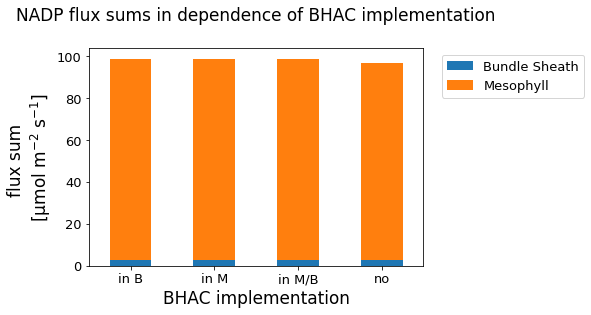

In [137]:
chart = df_nadp.pivot_table(index="BHAC implementation", columns="x-labels", values="fluxes")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "flux sum \n[\u03BCmol m$^{-2}$ s$^{-1}$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5), ncol = 1)
plt.rcParams["axes.titley"] = 1.1
plt.title("NADP flux sums in dependence of BHAC implementation")
plt.show()

In [138]:
d_nad_p = {
    'fluxes': nad_p_fluxes,
    'BHAC implementation': energy_status,
    'x-labels': x_labels
}
df_nad_p = pd.DataFrame(data=d_nad_p)
df_nad_p

,fluxes,BHAC implementation,x-labels
0,160.5499,no,Mesophyll
1,63.3035,no,Bundle Sheath
2,164.8879,in M/B,Mesophyll
3,62.0434,in M/B,Bundle Sheath
4,166.1231,in M,Mesophyll
5,60.8082,in M,Bundle Sheath
6,164.2626,in B,Mesophyll
7,62.6687,in B,Bundle Sheath


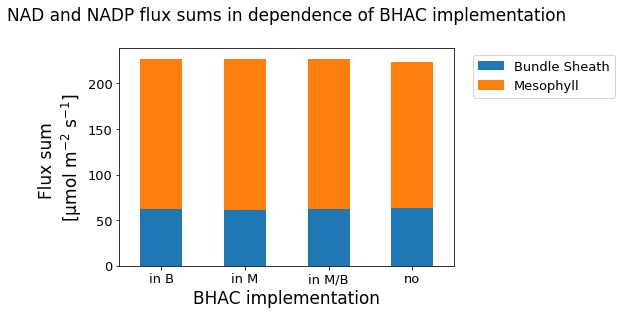

In [139]:
chart = df_nad_p.pivot_table(index="BHAC implementation", columns="x-labels", values="fluxes")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux sum \n[\u03BCmol m$^{-2}$ s$^{-1}$]")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5), ncol = 1)
plt.rcParams["axes.titley"] = 1.1
plt.title("NAD and NADP flux sums in dependence of BHAC implementation")
#plt.savefig('figures/C4/NAD_P_flux_sum.png', format='jpeg', bbox_inches = 'tight', dpi=400)
plt.show()

## Light - Photosynthesis reactions

In [140]:
photon_p_B = search_reactions('Photon', 'p', 'B')

There are 3 reactions including the following metabolites:
 ['[B]_Photon_p'] 



In [141]:
c4_model.metabolites.get_by_id('[B]_Photon_p')

Metabolite identifier,[B]_Photon_p
Name,NA
Memory address,0x2222fc19888
Formula,
Compartment,p
In 3 reaction(s),"[B]_PSII_RXN_p, [B]_Photon_ep, [B]_RXN490_3650_p"


In [142]:
flux_values_sum(photon_p_B, 'both')

[B]_RXN490_3650_p = 26.09061
[B]_PSII_RXN_p = 0.0

 ---------------- 
 The flux sum is: 26.0906


In [143]:
flux_values_sum(photon_p_B, 'no')

[B]_RXN490_3650_p = 27.1809
[B]_PSII_RXN_p = 0.0

 ---------------- 
 The flux sum is: 27.1809


In [144]:
c4_model.reactions.get_by_id('[B]_RXN490_3650_p').reaction

'[B]_Oxidized_ferredoxins_p + [B]_Photon_p + [B]_Plastocyanin_Reduced_p --> [B]_Oxidized_Plastocyanins_p + [B]_Reduced_ferredoxins_p'

In [145]:
c4_model.metabolites.get_by_id('[B]_Oxidized_Plastocyanins_p').reactions

frozenset({<Reaction [B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p at 0x22230261608>,
           <Reaction [B]_RXN490_3650_p at 0x2223043ec08>})

In [146]:
c4_model.reactions.get_by_id('[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p').reaction

'2.0 [B]_Oxidized_Plastocyanins_p + [B]_PLASTOQUINOL_1_p + 2.0 [B]_PROTON_p --> [B]_PLASTOQUINONE_p + 4.0 [B]_PROTON_l + 2.0 [B]_Plastocyanin_Reduced_p'

In [147]:
c4_model.metabolites.get_by_id('[B]_PLASTOQUINONE_p').reactions

frozenset({<Reaction [B]_Ferredoxin_Plastoquinone_Reductase_p at 0x2222ffa8388>,
           <Reaction [B]_NADPH_Dehydrogenase_p at 0x222304bcbc8>,
           <Reaction [B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p at 0x22230261608>,
           <Reaction [B]_PSII_RXN_p at 0x222302e6088>,
           <Reaction [B]_Plastoquinol_Oxidase_p at 0x222303d22c8>,
           <Reaction [B]_lycopene_biosynthesis_p at 0x2222fd55688>})

In [148]:
plasto_p_B = search_reactions('PLASTOQUINONE', 'p', 'B')

There are 6 reactions including the following metabolites:
 ['[B]_PLASTOQUINONE_p'] 



In [149]:
flux_values_sum(plasto_p_B, 'both')

[B]_Plastoquinol_Oxidase_p = 0.0
[B]_NADPH_Dehydrogenase_p = 13.04531
[B]_Ferredoxin_Plastoquinone_Reductase_p = 0.0
[B]_PSII_RXN_p = 0.0
[B]_lycopene_biosynthesis_p = 0.0
[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p = 13.04531

 ---------------- 
 The flux sum is: 26.0906


In [150]:
flux_values_sum(plasto_p_B, 'no')

[B]_Plastoquinol_Oxidase_p = 0.0
[B]_NADPH_Dehydrogenase_p = 13.59045
[B]_Ferredoxin_Plastoquinone_Reductase_p = 0.0
[B]_PSII_RXN_p = 0.0
[B]_lycopene_biosynthesis_p = 0.0
[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p = 13.59045

 ---------------- 
 The flux sum is: 27.1809


In [151]:
c4_model.reactions.get_by_id('[B]_NADPH_Dehydrogenase_p').reaction

'[B]_PLASTOQUINONE_p + 6.0 [B]_PROTON_p + 2.0 [B]_Reduced_ferredoxins_p --> 2.0 [B]_Oxidized_ferredoxins_p + [B]_PLASTOQUINOL_1_p + 4.0 [B]_PROTON_l'

In [152]:
proton_l_B = search_reactions('PROTON', 'l', 'B')

There are 4 reactions including the following metabolites:
 ['[B]_PROTON_l'] 



In [153]:
flux_values_sum(proton_l_B, 'both')

[B]_Plastidial_ATP_Synthase_p = 7.45446
[B]_NADPH_Dehydrogenase_p = 13.04531
[B]_PSII_RXN_p = 0.0
[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p = 13.04531

 ---------------- 
 The flux sum is: 33.5451


In [154]:
flux_values_sum(proton_l_B, 'no')

[B]_Plastidial_ATP_Synthase_p = 7.76597
[B]_NADPH_Dehydrogenase_p = 13.59045
[B]_PSII_RXN_p = 0.0
[B]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p = 13.59045

 ---------------- 
 The flux sum is: 34.9469


In [155]:
proton_l_M = search_reactions('PROTON', 'l', 'M')

There are 4 reactions including the following metabolites:
 ['[M]_PROTON_l'] 



In [156]:
flux_values_sum(proton_l_M, 'both')

[M]_PSII_RXN_p = 31.25
[M]_Plastidial_ATP_Synthase_p = 26.78571
[M]_NADPH_Dehydrogenase_p = 0.0
[M]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p = 62.5

 ---------------- 
 The flux sum is: 120.5357


In [157]:
flux_values_sum(proton_l_M, 'no')

[M]_PSII_RXN_p = 31.25
[M]_Plastidial_ATP_Synthase_p = 26.78571
[M]_NADPH_Dehydrogenase_p = 0.0
[M]_PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p = 62.5

 ---------------- 
 The flux sum is: 120.5357


## Check C4 cycle including Calvin cycle and Photorespiration
Check if reactions/transporters of C4 cycle are present in model and does model follow them?
(orientation: Figure 3 in Kuhnert et al. (2021) & Figure 1 in Sage et al. (2012))

This was important in the beginning to be sure that the model is complete and able to simulate a C4 cycle.

#### Malate in chloroplast of mesophyll - MDH

In [158]:
mal_p_M = search_reactions('MAL', 'p', 'M')
mal_p_M

There are 7 reactions including the following metabolites:
 ['[M]_MAL_p'] 



{'[M]_2KG_MAL_pc',
 '[M]_GLT_MAL_pc',
 '[M]_MALATE_DEHYDROGENASE_NADP_RXN_p',
 '[M]_MALATE_DEH_RXN_p',
 '[M]_MALIC_NADP_RXN_p',
 '[M]_OAA_MAL_pc',
 '[M]_PYR_MAL_pc'}

In [159]:
# OAA into malate
print(c4_model.reactions.get_by_id('[M]_MALATE_DEH_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_MALATE_DEH_RXN_p'))
print(c4_model.reactions.get_by_id('[M]_MALATE_DEHYDROGENASE_NADP_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_MALATE_DEHYDROGENASE_NADP_RXN_p'))

[M]_MAL_p + [M]_NAD_p <=> [M]_NADH_p + [M]_OXALACETIC_ACID_p + [M]_PROTON_p
27.03076
[M]_NADPH_p + [M]_OXALACETIC_ACID_p + [M]_PROTON_p --> [M]_MAL_p + [M]_NADP_p
0.0


In [160]:
print(pFBA_noBHAC.get('[M]_MALATE_DEH_RXN_c'))

-6.09771


In [161]:
# DIT1/OMT shutlle of Mal/OAA: 2-ketoglutarate/malate shuttle from plastid into cytosol
print(c4_model.reactions.get_by_id('[M]_2KG_MAL_pc').reaction)
print(pFBA_noBHAC.get('[M]_2KG_MAL_pc'))

[M]_2_KETOGLUTARATE_p + [M]_MAL_c <=> [M]_2_KETOGLUTARATE_c + [M]_MAL_p
-0.10353


In [162]:
# transport malate from mesophyll into bundle sheath (cytosol)
print(c4_model.reactions.get_by_id('[MB]_MAL_c').reaction)
print(pFBA_noBHAC.get('[MB]_MAL_c'))

[M]_MAL_c <=> [B]_MAL_c
-20.78998


In [163]:
print(c4_model.reactions.get_by_id('[B]_PYR_MAL_pc').reaction)
print(pFBA_noBHAC.get('[B]_PYR_MAL_pc'))

[B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c
1.39748


In [164]:
# malate now in bundle sheath, transport from cytosol into plastid with DIT2.2/DCT2
print(c4_model.reactions.get_by_id('[B]_GLT_MAL_pc').reaction)
print(pFBA_noBHAC.get('[B]_GLT_MAL_pc'))

[B]_GLT_p + [B]_MAL_c <=> [B]_GLT_c + [B]_MAL_p
-0.0


#### NADP-ME

In [165]:
# malate into pyruvate and CO2
print(c4_model.reactions.get_by_id('[B]_MALIC_NADP_RXN_p').reaction)
print(pFBA_noBHAC.get('[B]_MALIC_NADP_RXN_p'))

[B]_MAL_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_PYRUVATE_p
1.39748


In [166]:
# pyruvate into cytosol and back into mesophyll cell
pyr_c_B = search_reactions('PYRUVATE', 'c', 'B')
pyr_c_B

There are 11 reactions including the following metabolites:
 ['[B]_PYRUVATE_c'] 



{'[B]_ALANINE_AMINOTRANSFERASE_RXN_c',
 '[B]_DSERDEAM_RXN_c',
 '[B]_LCYSDESULF_RXN_c',
 '[B]_MALIC_NADP_RXN_c',
 '[B]_PEPDEPHOS_RXN_c',
 '[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c',
 '[B]_PYRUVATE_PROTON_mc',
 '[B]_PYRUVATE_pc',
 '[B]_PYR_MAL_pc',
 '[B]_Pyr_H_pc',
 '[MB]_PYRUVATE_c'}

In [167]:
print(c4_model.reactions.get_by_id('[B]_PYRUVATE_pc').reaction)
print(pFBA_noBHAC.get('[B]_PYRUVATE_pc'))
print(pFBA_BHAC.get('[B]_PYRUVATE_pc'))

print(c4_model.reactions.get_by_id('[MB]_PYRUVATE_c').reaction)
print(pFBA_noBHAC.get('[MB]_PYRUVATE_c'))
print(pFBA_BHAC.get('[MB]_PYRUVATE_c'))

[B]_PYRUVATE_p --> [B]_PYRUVATE_c
0.0
0.0
[M]_PYRUVATE_c <=> [B]_PYRUVATE_c
0.0
0.0


In [168]:
# pyruvate in cytosol of mesophyll transported into plastid
pyr_p_M = search_reactions('PYRUVATE', 'p', 'M')
for i in pyr_p_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 13 reactions including the following metabolites:
 ['[M]_PYRUVATE_p'] 

[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p : [M]_ATP_p + [M]_PYRUVATE_p + [M]_Pi_p --> [M]_AMP_p + [M]_PHOSPHO_ENOL_PYRUVATE_p + [M]_PPI_p + 1.55 [M]_PROTON_p
[M]_PEPDEPHOS_RXN_p : [M]_ADP_p + [M]_PHOSPHO_ENOL_PYRUVATE_p + 0.9 [M]_PROTON_p --> [M]_ATP_p + [M]_PYRUVATE_p
[M]_ACETOLACTSYN_RXN_p : [M]_PROTON_p + 2.0 [M]_PYRUVATE_p --> [M]_2_ACETO_LACTATE_p + [M]_CARBON_DIOXIDE_p
[M]_CYSTATHIONINE_BETA_LYASE_RXN_p : [M]_L_CYSTATHIONINE_p + [M]_WATER_p --> [M]_AMMONIUM_p + [M]_HOMO_CYS_p + [M]_PYRUVATE_p
[M]_Pyr_H_pc : [M]_PROTON_c + [M]_PYRUVATE_c <=> [M]_PROTON_p + [M]_PYRUVATE_p
[M]_MALIC_NADP_RXN_p : [M]_MAL_p + [M]_NADP_p --> [M]_CARBON_DIOXIDE_p + [M]_NADPH_p + [M]_PYRUVATE_p
[M]_PYRUVDEH_RXN_p : [M]_CO_A_p + [M]_NAD_p + [M]_PYRUVATE_p --> [M]_ACETYL_COA_p + [M]_CARBON_DIOXIDE_p + [M]_NADH_p
[M]_HMBPP_synthesis_p : [M]_ATP_p + [M]_CTP_p + [M]_GAP_p + [M]_NADPH_p + 2.65 [M]_PROTON_p + [M]_PYRUVATE_p + 2.0 

In [169]:
for i in pyr_p_M:
    print(i, pFBA_noBHAC.get(i))

[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p 0.03376
[M]_PEPDEPHOS_RXN_p 0.0
[M]_ACETOLACTSYN_RXN_p 0.0
[M]_CYSTATHIONINE_BETA_LYASE_RXN_p 0.0466
[M]_Pyr_H_pc 3.73495
[M]_MALIC_NADP_RXN_p 0.0
[M]_PYRUVDEH_RXN_p 0.0
[M]_HMBPP_synthesis_p 0.0
[M]_ANTHRANSYN_RXN_p 0.0
[M]_DIHYDRODIPICSYN_RXN_p 0.0
[M]_ACETOOHBUTSYN_RXN_p 0.0
[M]_PYRUVATE_pc 0.0
[M]_PYR_MAL_pc 3.74779


In [170]:
print(c4_model.reactions.get_by_id('[M]_Pyr_H_pc').reaction)
print(pFBA_noBHAC.get('[M]_Pyr_H_pc'))

[M]_PROTON_c + [M]_PYRUVATE_c <=> [M]_PROTON_p + [M]_PYRUVATE_p
3.73495


In [171]:
print(c4_model.reactions.get_by_id('[M]_PYR_MAL_pc').reaction)
print(pFBA_noBHAC.get('[M]_PYR_MAL_pc'))

[M]_MAL_c + [M]_PYRUVATE_p <=> [M]_MAL_p + [M]_PYRUVATE_c
3.74779


In [172]:
print(c4_model.reactions.get_by_id('[M]_PEPDEPHOS_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_PEPDEPHOS_RXN_p'))

[M]_ADP_p + [M]_PHOSPHO_ENOL_PYRUVATE_p + 0.9 [M]_PROTON_p --> [M]_ATP_p + [M]_PYRUVATE_p
0.0


#### PPDK

In [173]:
# pyruvate converted into PEP
print(c4_model.reactions.get_by_id('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p'))
print(pFBA_BHAC.get('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p'))

[M]_ATP_p + [M]_PYRUVATE_p + [M]_Pi_p --> [M]_AMP_p + [M]_PHOSPHO_ENOL_PYRUVATE_p + [M]_PPI_p + 1.55 [M]_PROTON_p
0.03376
0.03195


In [174]:
# mentioned transporters in Fig. 3 are for genus Flaveria, text says that in Maize there are other transporters

In [175]:
# PEP with PPT transporters into cytosol
pep_c_M = search_reactions('PHOSPHO_ENOL_PYRUVATE', 'c', 'M')
for i in pep_c_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)
    #print(i)

There are 8 reactions including the following metabolites:
 ['[M]_PHOSPHO_ENOL_PYRUVATE_c'] 

[MB]_PHOSPHO_ENOL_PYRUVATE_c : [M]_PHOSPHO_ENOL_PYRUVATE_c <=> [B]_PHOSPHO_ENOL_PYRUVATE_c
[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c : [M]_ATP_c + [M]_PYRUVATE_c + [M]_Pi_c --> [M]_AMP_c + [M]_PHOSPHO_ENOL_PYRUVATE_c + [M]_PPI_c + 1.3 [M]_PROTON_c
[M]_PPT_pc : [M]_PHOSPHO_ENOL_PYRUVATE_p + [M]_PROTON_p + [M]_Pi_c <=> [M]_PHOSPHO_ENOL_PYRUVATE_c + 1.3 [M]_PROTON_c + [M]_Pi_p
[M]_2PGADEHYDRAT_RXN_c : [M]_2_PG_c <=> [M]_PHOSPHO_ENOL_PYRUVATE_c + [M]_WATER_c
[M]_PEPCARBOX_RXN_c : [M]_HCO3_c + [M]_PHOSPHO_ENOL_PYRUVATE_c + 0.3 [M]_PROTON_c --> [M]_OXALACETIC_ACID_c + [M]_Pi_c
[M]_PEP_Pi_pc : [M]_PHOSPHO_ENOL_PYRUVATE_p + [M]_Pi_c --> [M]_PHOSPHO_ENOL_PYRUVATE_c + 0.3 [M]_PROTON_c + [M]_Pi_p
[M]_PEPDEPHOS_RXN_c : [M]_ADP_c + [M]_PHOSPHO_ENOL_PYRUVATE_c + 0.85 [M]_PROTON_c --> [M]_ATP_c + [M]_PYRUVATE_c
[M]_PEPCARBOXYKIN_RXN_c : [M]_ATP_c + [M]_OXALACETIC_ACID_c + 0.15 [M]_PROTON_c --> [M]_ADP_c + [M

In [176]:
print(c4_model.reactions.get_by_id('[M]_PPT_pc').reaction)
print(pFBA_noBHAC.get('[M]_PPT_pc'))

[M]_PHOSPHO_ENOL_PYRUVATE_p + [M]_PROTON_p + [M]_Pi_c <=> [M]_PHOSPHO_ENOL_PYRUVATE_c + 1.3 [M]_PROTON_c + [M]_Pi_p
0.0


#### PEPC & CA

In [177]:
# PEP into OAA with PEPC
print('[M]_PEPCARBOX_RXN_c:', c4_model.reactions.get_by_id('[M]_PEPCARBOX_RXN_c').reaction)
print(pFBA_noBHAC.get('[M]_PEPCARBOX_RXN_c'))

# needed HCO3- for PEPC comes from CO2 - enzyme CA
print('[M]_RXN0_5224_c:', c4_model.reactions.get_by_id('[M]_RXN0_5224_c').reaction)
print(pFBA_noBHAC.get('[M]_RXN0_5224_c'))

# uptake CO2
print('[M]_CO2_tx:', c4_model.reactions.get_by_id('[M]_CO2_tx').reaction)
print(pFBA_noBHAC.get('[M]_CO2_tx'))

[M]_PEPCARBOX_RXN_c: [M]_HCO3_c + [M]_PHOSPHO_ENOL_PYRUVATE_c + 0.3 [M]_PROTON_c --> [M]_OXALACETIC_ACID_c + [M]_Pi_c
19.17382
[M]_RXN0_5224_c: [M]_CARBON_DIOXIDE_c + [M]_WATER_c <=> [M]_HCO3_c + [M]_PROTON_c
19.17382
[M]_CO2_tx:  <=> [M]_CARBON_DIOXIDE_e
19.28013


In [178]:
# OAA transport from cytosol into plastid (then conversion to malate, see beginning section)
oaa_p_M = search_reactions('OXALACETIC_ACID', 'p', 'M')
for i in oaa_p_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 4 reactions including the following metabolites:
 ['[M]_OXALACETIC_ACID_p'] 

[M]_OAA_MAL_pc : [M]_MAL_c + [M]_OXALACETIC_ACID_p <=> [M]_MAL_p + [M]_OXALACETIC_ACID_c
[M]_MALATE_DEH_RXN_p : [M]_MAL_p + [M]_NAD_p <=> [M]_NADH_p + [M]_OXALACETIC_ACID_p + [M]_PROTON_p
[M]_MALATE_DEHYDROGENASE_NADP_RXN_p : [M]_NADPH_p + [M]_OXALACETIC_ACID_p + [M]_PROTON_p --> [M]_MAL_p + [M]_NADP_p
[M]_ASPAMINOTRANS_RXN_p : [M]_2_KETOGLUTARATE_p + [M]_L_ASPARTATE_p <=> [M]_GLT_p + [M]_OXALACETIC_ACID_p


In [179]:
print('[M]_OAA_MAL_pc:', c4_model.reactions.get_by_id('[M]_OAA_MAL_pc').reaction)
print(pFBA_noBHAC.get('[M]_OAA_MAL_pc'))

[M]_OAA_MAL_pc: [M]_MAL_c + [M]_OXALACETIC_ACID_p <=> [M]_MAL_p + [M]_OXALACETIC_ACID_c
23.38651


#### Calvin cycle

In [180]:
# now looking at reactions with CO2 that result from conversion of malate to pyruvate in plastid of bundle sheath

In [181]:
g3p_p_B = search_reactions('G3P', 'p', 'B')
for i in g3p_p_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 9 reactions including the following metabolites:
 ['[B]_G3P_p'] 

[B]_RXN_961_p : [B]_D_RIBULOSE_15_P2_p + [B]_OXYGEN_MOLECULE_p --> [B]_CPD_67_p + [B]_G3P_p + 2.0 [B]_PROTON_p
[B]_DHAP_3PGA_pc : [B]_DIHYDROXY_ACETONE_PHOSPHATE_p + [B]_G3P_c <=> [B]_DIHYDROXY_ACETONE_PHOSPHATE_c + [B]_G3P_p
[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p : [B]_CARBON_DIOXIDE_p + [B]_D_RIBULOSE_15_P2_p + [B]_WATER_p --> 2.0 [B]_G3P_p + 2.0 [B]_PROTON_p
[B]_3PGA_Pi_pc : [B]_G3P_p + [B]_Pi_c <=> [B]_G3P_c + 0.3 [B]_PROTON_c + [B]_Pi_p
[B]_GAP_3PGA_pc : [B]_G3P_c + [B]_GAP_p <=> [B]_G3P_p + [B]_GAP_c
[B]_GLY3KIN_RXN_p : [B]_ATP_p + [B]_GLYCERATE_p --> [B]_ADP_p + [B]_G3P_p + 0.9 [B]_PROTON_p
[B]_3PGAREARR_RXN_p : [B]_G3P_p <=> [B]_2_PG_p
[B]_PGLYCDEHYDROG_RXN_p : [B]_G3P_p + [B]_NAD_p <=> [B]_3_P_HYDROXYPYRUVATE_p + [B]_NADH_p + [B]_PROTON_p
[B]_PHOSGLYPHOS_RXN_p : [B]_ATP_p + [B]_G3P_p + 0.1 [B]_PROTON_p <=> [B]_ADP_p + [B]_DPG_p


In [182]:
print(c4_model.reactions.get_by_id('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p').reaction)
print(pFBA_noBHAC.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))

[B]_CARBON_DIOXIDE_p + [B]_D_RIBULOSE_15_P2_p + [B]_WATER_p --> 2.0 [B]_G3P_p + 2.0 [B]_PROTON_p
19.80302


In [183]:
# 3-PG into Calvin cycle
print(c4_model.reactions.get_by_id('[B]_PHOSGLYPHOS_RXN_p').reaction)
print(pFBA_noBHAC.get('[B]_PHOSGLYPHOS_RXN_p'))

[B]_ATP_p + [B]_G3P_p + 0.1 [B]_PROTON_p <=> [B]_ADP_p + [B]_DPG_p
0.32147


In [184]:
# G3P transported into cytosol with TPT transporter (TP = triose phosphate = GAP)
print(c4_model.reactions.get_by_id('[B]_GAP_3PGA_pc').reaction)
print(pFBA_noBHAC.get('[B]_GAP_3PGA_pc'))

[B]_G3P_c + [B]_GAP_p <=> [B]_G3P_p + [B]_GAP_c
-21.64652


In [185]:
# transport G3P from B to M and GAP from M to B
g3p_c_M = search_reactions('G3P', 'c', 'M')
for i in g3p_c_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 7 reactions including the following metabolites:
 ['[M]_G3P_c'] 

[M]_GAP_3PGA_pc : [M]_G3P_c + [M]_GAP_p <=> [M]_G3P_p + [M]_GAP_c
[M]_1_PERIOD_2_PERIOD_1_PERIOD_9_RXN_c : [M]_GAP_c + [M]_NADP_c + [M]_WATER_c --> [M]_G3P_c + [M]_NADPH_c + 2.0 [M]_PROTON_c
[M]_3PGAREARR_RXN_c : [M]_G3P_c <=> [M]_2_PG_c
[M]_DHAP_3PGA_pc : [M]_DIHYDROXY_ACETONE_PHOSPHATE_p + [M]_G3P_c <=> [M]_DIHYDROXY_ACETONE_PHOSPHATE_c + [M]_G3P_p
[MB]_G3P_c : [M]_G3P_c <=> [B]_G3P_c
[M]_3PGA_Pi_pc : [M]_G3P_p + [M]_Pi_c <=> [M]_G3P_c + 0.3 [M]_PROTON_c + [M]_Pi_p
[M]_PHOSGLYPHOS_RXN_c : [M]_ATP_c + [M]_G3P_c + 0.15 [M]_PROTON_c <=> [M]_ADP_c + [M]_DPG_c


In [186]:
gap_c_M = search_reactions('GAP', 'c', 'M')
for i in gap_c_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 7 reactions including the following metabolites:
 ['[M]_GAP_c'] 

[M]_GAP_3PGA_pc : [M]_G3P_c + [M]_GAP_p <=> [M]_G3P_p + [M]_GAP_c
[M]_1_PERIOD_2_PERIOD_1_PERIOD_9_RXN_c : [M]_GAP_c + [M]_NADP_c + [M]_WATER_c --> [M]_G3P_c + [M]_NADPH_c + 2.0 [M]_PROTON_c
[M]_TRIOSEPISOMERIZATION_RXN_c : [M]_GAP_c <=> [M]_DIHYDROXY_ACETONE_PHOSPHATE_c
[M]_GAPOXNPHOSPHN_RXN_c : [M]_GAP_c + [M]_NAD_c + [M]_Pi_c <=> [M]_DPG_c + [M]_NADH_c + 1.3 [M]_PROTON_c
[M]_F16ALDOLASE_RXN_c : [M]_FRUCTOSE_16_DIPHOSPHATE_c <=> [M]_DIHYDROXY_ACETONE_PHOSPHATE_c + [M]_GAP_c
[MB]_GAP_c : [M]_GAP_c <=> [B]_GAP_c
[M]_GAP_Pi_pc : [M]_GAP_p + [M]_Pi_c <=> [M]_GAP_c + 0.3 [M]_PROTON_c + [M]_Pi_p


In [187]:
print(c4_model.reactions.get_by_id('[MB]_G3P_c').reaction)
print(pFBA_noBHAC.get('[MB]_G3P_c'))
print(c4_model.reactions.get_by_id('[MB]_GAP_c').reaction)
print(pFBA_noBHAC.get('[MB]_GAP_c'))

[M]_G3P_c <=> [B]_G3P_c
-63.59483
[M]_GAP_c <=> [B]_GAP_c
63.14133


In [188]:
# TPT transport in M
print(c4_model.reactions.get_by_id('[M]_GAP_3PGA_pc').reaction)
print(pFBA_noBHAC.get('[M]_GAP_3PGA_pc'))

[M]_G3P_c + [M]_GAP_p <=> [M]_G3P_p + [M]_GAP_c
69.0117


In [189]:
# G3P conversion into GAP in plastid
g3p_p_M = search_reactions('G3P', 'p', 'M')
for i in g3p_p_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 9 reactions including the following metabolites:
 ['[M]_G3P_p'] 

[M]_GAP_3PGA_pc : [M]_G3P_c + [M]_GAP_p <=> [M]_G3P_p + [M]_GAP_c
[M]_PHOSGLYPHOS_RXN_p : [M]_ATP_p + [M]_G3P_p + 0.1 [M]_PROTON_p <=> [M]_ADP_p + [M]_DPG_p
[M]_RXN_961_p : [M]_D_RIBULOSE_15_P2_p + [M]_OXYGEN_MOLECULE_p --> [M]_CPD_67_p + [M]_G3P_p + 2.0 [M]_PROTON_p
[M]_PGLYCDEHYDROG_RXN_p : [M]_G3P_p + [M]_NAD_p <=> [M]_3_P_HYDROXYPYRUVATE_p + [M]_NADH_p + [M]_PROTON_p
[M]_GLY3KIN_RXN_p : [M]_ATP_p + [M]_GLYCERATE_p --> [M]_ADP_p + [M]_G3P_p + 0.9 [M]_PROTON_p
[M]_DHAP_3PGA_pc : [M]_DIHYDROXY_ACETONE_PHOSPHATE_p + [M]_G3P_c <=> [M]_DIHYDROXY_ACETONE_PHOSPHATE_c + [M]_G3P_p
[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p : [M]_CARBON_DIOXIDE_p + [M]_D_RIBULOSE_15_P2_p + [M]_WATER_p --> 2.0 [M]_G3P_p + 2.0 [M]_PROTON_p
[M]_3PGA_Pi_pc : [M]_G3P_p + [M]_Pi_c <=> [M]_G3P_c + 0.3 [M]_PROTON_c + [M]_Pi_p
[M]_3PGAREARR_RXN_p : [M]_G3P_p <=> [M]_2_PG_p


In [190]:
gap_p_M = search_reactions('GAP', 'p', 'M')
for i in gap_p_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 11 reactions including the following metabolites:
 ['[M]_GAP_p'] 

[M]_GAP_3PGA_pc : [M]_G3P_c + [M]_GAP_p <=> [M]_G3P_p + [M]_GAP_c
[M]_F16ALDOLASE_RXN_p : [M]_FRUCTOSE_16_DIPHOSPHATE_p <=> [M]_DIHYDROXY_ACETONE_PHOSPHATE_p + [M]_GAP_p
[M]_2TRANSKETO_RXN_p : [M]_ERYTHROSE_4P_p + [M]_XYLULOSE_5_PHOSPHATE_p <=> [M]_FRUCTOSE_6P_p + [M]_GAP_p
[M]_TRIOSEPISOMERIZATION_RXN_p : [M]_GAP_p <=> [M]_DIHYDROXY_ACETONE_PHOSPHATE_p
[M]_1TRANSKETO_RXN_p : [M]_D_SEDOHEPTULOSE_7_P_p + [M]_GAP_p <=> [M]_RIBOSE_5P_p + [M]_XYLULOSE_5_PHOSPHATE_p
[M]_HMBPP_synthesis_p : [M]_ATP_p + [M]_CTP_p + [M]_GAP_p + [M]_NADPH_p + 2.65 [M]_PROTON_p + [M]_PYRUVATE_p + 2.0 [M]_Reduced_ferredoxins_p --> [M]_ADP_p + [M]_CARBON_DIOXIDE_p + [M]_CMP_p + [M]_HYDROXY_METHYL_BUTENYL_DIP_p + [M]_NADP_p + 2.0 [M]_Oxidized_ferredoxins_p + [M]_PPI_p + [M]_WATER_p
[M]_TRANSALDOL_RXN_p : [M]_D_SEDOHEPTULOSE_7_P_p + [M]_GAP_p <=> [M]_ERYTHROSE_4P_p + [M]_FRUCTOSE_6P_p
[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p : [M]_DPG_p + [M

In [191]:
products_g3p = []
for i in g3p_p_M:
    for j in c4_model.reactions.get_by_id(i).products:
        products_g3p.append(j)

set(products_g3p)

{<Metabolite [M]_2_PG_p at 0x2222f86a0c8>,
 <Metabolite [M]_3_P_HYDROXYPYRUVATE_p at 0x2222fc37ac8>,
 <Metabolite [M]_ADP_p at 0x2222f7e9748>,
 <Metabolite [M]_CPD_67_p at 0x2222d5a8808>,
 <Metabolite [M]_DIHYDROXY_ACETONE_PHOSPHATE_c at 0x2222fc4a1c8>,
 <Metabolite [M]_DPG_p at 0x2222f728388>,
 <Metabolite [M]_G3P_c at 0x2222faed8c8>,
 <Metabolite [M]_G3P_p at 0x2222fc4fc08>,
 <Metabolite [M]_GAP_c at 0x2222f7d9cc8>,
 <Metabolite [M]_NADH_p at 0x2222fc47f08>,
 <Metabolite [M]_PROTON_c at 0x2222f87ae48>,
 <Metabolite [M]_PROTON_p at 0x2222f8549c8>,
 <Metabolite [M]_Pi_p at 0x2222d510f88>}

In [192]:
reactants_gap = []
for i in gap_p_M:
    for j in c4_model.reactions.get_by_id(i).reactants:
        reactants_gap.append(j)

set(reactants_gap)

{<Metabolite [M]_ATP_p at 0x2222d597f88>,
 <Metabolite [M]_CTP_p at 0x2222d51b2c8>,
 <Metabolite [M]_DPG_p at 0x2222f728388>,
 <Metabolite [M]_D_SEDOHEPTULOSE_7_P_p at 0x2222d4dac88>,
 <Metabolite [M]_ERYTHROSE_4P_p at 0x2222d5a8fc8>,
 <Metabolite [M]_FRUCTOSE_16_DIPHOSPHATE_p at 0x2222f7457c8>,
 <Metabolite [M]_G3P_c at 0x2222faed8c8>,
 <Metabolite [M]_GAP_p at 0x2222f7e2b48>,
 <Metabolite [M]_INDOLE_3_GLYCEROL_P_p at 0x2222f696608>,
 <Metabolite [M]_NADPH_p at 0x2222f6f6848>,
 <Metabolite [M]_NAD_p at 0x2222f7f3848>,
 <Metabolite [M]_PROTON_p at 0x2222f8549c8>,
 <Metabolite [M]_PYRUVATE_p at 0x2222f860388>,
 <Metabolite [M]_Pi_c at 0x2222d516408>,
 <Metabolite [M]_Pi_p at 0x2222d510f88>,
 <Metabolite [M]_Reduced_ferredoxins_p at 0x2222f88dec8>,
 <Metabolite [M]_XYLULOSE_5_PHOSPHATE_p at 0x2222f67e548>}

In [193]:
# DPG
dpg_p_M = search_reactions('DPG', 'p', 'M')
for i in dpg_p_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 3 reactions including the following metabolites:
 ['[M]_DPG_p'] 

[M]_GAPOXNPHOSPHN_RXN_p : [M]_GAP_p + [M]_NAD_p + [M]_Pi_p <=> [M]_DPG_p + [M]_NADH_p + [M]_PROTON_p
[M]_PHOSGLYPHOS_RXN_p : [M]_ATP_p + [M]_G3P_p + 0.1 [M]_PROTON_p <=> [M]_ADP_p + [M]_DPG_p
[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p : [M]_DPG_p + [M]_NADPH_p + [M]_PROTON_p --> [M]_GAP_p + [M]_NADP_p + [M]_Pi_p


In [194]:
# to produce GAP (TP) from G3P, there is a detour possible
print(c4_model.reactions.get_by_id('[M]_PHOSGLYPHOS_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_PHOSGLYPHOS_RXN_p'))
print(c4_model.reactions.get_by_id('[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p'))

[M]_ATP_p + [M]_G3P_p + 0.1 [M]_PROTON_p <=> [M]_ADP_p + [M]_DPG_p
69.97568
[M]_DPG_p + [M]_NADPH_p + [M]_PROTON_p --> [M]_GAP_p + [M]_NADP_p + [M]_Pi_p
43.10505


#### PR

In [195]:
# now looking at photorespiration pathway
# starting with conversion O2 into 2-PG (CPD_67) in plastid of bundle sheath

print(c4_model.reactions.get_by_id('[B]_RXN_961_p').reaction)
print(pFBA_noBHAC.get('[B]_RXN_961_p'))

[B]_D_RIBULOSE_15_P2_p + [B]_OXYGEN_MOLECULE_p --> [B]_CPD_67_p + [B]_G3P_p + 2.0 [B]_PROTON_p
1.9803


In [196]:
# 2-PG into glycolate
glycolate_p_B = search_reactions('GLYCOLLATE', 'p', 'B')
for i in glycolate_p_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 3 reactions including the following metabolites:
 ['[B]_GLYCOLLATE_p'] 

[B]_GLYCERATE_GLYCOLLATE_pc : [B]_GLYCERATE_c + [B]_GLYCOLLATE_p <=> [B]_GLYCERATE_p + [B]_GLYCOLLATE_c
[B]_GLYCOLLATE_pc : [B]_GLYCOLLATE_p <=> [B]_GLYCOLLATE_c
[B]_GPH_RXN_p : [B]_CPD_67_p + [B]_WATER_p --> [B]_GLYCOLLATE_p + [B]_Pi_p


In [197]:
print(c4_model.reactions.get_by_id('[B]_GPH_RXN_p').reaction)
print(pFBA_noBHAC.get('[B]_GPH_RXN_p'))
print(pFBA_BHAC_B.get('[B]_GPH_RXN_p'))
print(pFBA_BHAC_M.get('[B]_GPH_RXN_p'))

[B]_CPD_67_p + [B]_WATER_p --> [B]_GLYCOLLATE_p + [B]_Pi_p
1.9803
1.98036
1.98036


In [198]:
# BASS6 transport
print(c4_model.reactions.get_by_id('[B]_GLYCOLLATE_pc').reaction)
print(pFBA_noBHAC.get('[B]_GLYCOLLATE_pc'))
print(pFBA_BHAC_M.get('[B]_GLYCOLLATE_pc'))
print(pFBA_BHAC_B.get('[B]_GLYCOLLATE_pc'))

# PLGG1 transport
print(c4_model.reactions.get_by_id('[B]_GLYCERATE_GLYCOLLATE_pc').reaction)
print(pFBA_noBHAC.get('[B]_GLYCERATE_GLYCOLLATE_pc'))
print(pFBA_BHAC_M.get('[B]_GLYCERATE_GLYCOLLATE_pc'))
print(pFBA_BHAC_B.get('[B]_GLYCERATE_GLYCOLLATE_pc'))

[B]_GLYCOLLATE_p <=> [B]_GLYCOLLATE_c
1.9803
1.98036
1.98036
[B]_GLYCERATE_c + [B]_GLYCOLLATE_p <=> [B]_GLYCERATE_p + [B]_GLYCOLLATE_c
0.0
0.0
0.0


In [199]:
glycolate_c_B = search_reactions('GLYCOLLATE', 'c', 'B')
glycolate_c_B

There are 4 reactions including the following metabolites:
 ['[B]_GLYCOLLATE_c'] 



{'[B]_GLYCERATE_GLYCOLLATE_pc',
 '[B]_GLYCOLLATE_pc',
 '[B]_Glycolate_xc',
 '[MB]_GLYCOLLATE_c'}

In [200]:
print(pFBA_noBHAC.get('[MB]_GLYCOLLATE_c'))
print(pFBA_BHAC_M.get('[MB]_GLYCOLLATE_c'))

-1.05776
-1.86049


In [201]:
# transport glycolate from cytosol into peroxisome
glycolate_x_B = search_reactions('GLYCOLLATE', 'x', 'B')
for i in glycolate_x_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 2 reactions including the following metabolites:
 ['[B]_GLYCOLLATE_x'] 

[B]_Glycolate_xc : [B]_GLYCOLLATE_x <=> [B]_GLYCOLLATE_c
[B]_RXN_969_x : [B]_GLYCOLLATE_x + [B]_OXYGEN_MOLECULE_x --> [B]_GLYOX_x + [B]_HYDROGEN_PEROXIDE_x


In [202]:
print(c4_model.reactions.get_by_id('[B]_Glycolate_xc').reaction)
print(pFBA_noBHAC.get('[B]_Glycolate_xc'))
print(pFBA_BHAC.get('[B]_Glycolate_xc'))
print(pFBA_BHAC_M.get('[B]_Glycolate_xc'))

[B]_GLYCOLLATE_x <=> [B]_GLYCOLLATE_c
-0.92254
-1.23521
-0.11987


In [203]:
print(pFBA_BHAC.get('[M]_Glycolate_xc'))
print(pFBA_BHAC_M.get('[M]_Glycolate_xc'))

-0.74515
-1.86049


In [204]:
# conversion glcyolate into glyoxylate in peroxisome
print(c4_model.reactions.get_by_id('[B]_RXN_969_x').reaction)
print(pFBA_noBHAC.get('[B]_RXN_969_x'))
print(pFBA_BHAC.get('[B]_RXN_969_x'))
print(pFBA_BHAC_M.get('[B]_RXN_969_x'))
print(pFBA_BHAC_B.get('[B]_RXN_969_x'))

[B]_GLYCOLLATE_x + [B]_OXYGEN_MOLECULE_x --> [B]_GLYOX_x + [B]_HYDROGEN_PEROXIDE_x
0.92254
1.23521
0.11987
1.86049


In [205]:
print(pFBA_noBHAC.get('[M]_RXN_969_x'))
print(pFBA_BHAC.get('[M]_RXN_969_x'))
print(pFBA_BHAC_M.get('[M]_RXN_969_x'))
print(pFBA_BHAC_B.get('[M]_RXN_969_x'))

1.05776
0.74515
1.86049
0.11987


In [206]:
# conversion glyoxylate into glycine
gly_x_B = search_reactions('GLY', 'x', 'B')
for i in gly_x_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 6 reactions including the following metabolites:
 ['[B]_GLY_x'] 

[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [B]_GLYOX_x + [B]_L_ALPHA_ALANINE_x --> [B]_GLY_x + [B]_PYRUVATE_x
[B]_BHAA_x : [B]_GLYOX_x + [B]_GLY_x <=> [B]_BETA_HYDROXYASPARTATE_x
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [B]_GLYOX_x + [B]_SER_x --> [B]_GLY_x + [B]_OH_PYR_x
[B]_GLY_xc : [B]_GLY_x <=> [B]_GLY_c
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x : [B]_GLT_x + [B]_GLYOX_x <=> [B]_2_KETOGLUTARATE_x + [B]_GLY_x
[B]_AGAT_x : [B]_GLYOX_x + [B]_L_ASPARTATE_x <=> [B]_GLY_x + [B]_OXALACETIC_ACID_x


In [207]:
# different options
print(c4_model.reactions.get_by_id('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x').reaction)
print(pFBA_noBHAC.get('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(c4_model.reactions.get_by_id('[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x').reaction)
print(pFBA_noBHAC.get('[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))
print(c4_model.reactions.get_by_id('[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x').reaction)
print(pFBA_noBHAC.get('[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))

[B]_GLT_x + [B]_GLYOX_x <=> [B]_2_KETOGLUTARATE_x + [B]_GLY_x
0.0
[B]_GLYOX_x + [B]_SER_x --> [B]_GLY_x + [B]_OH_PYR_x
0.92254
[B]_GLYOX_x + [B]_L_ALPHA_ALANINE_x --> [B]_GLY_x + [B]_PYRUVATE_x
0.0


In [208]:
gly_m_B = search_reactions('GLY', 'm', 'B')
for i in gly_m_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 3 reactions including the following metabolites:
 ['[B]_GLY_m'] 

[B]_GLYOHMETRANS_RXN_m : [B]_SER_m + [B]_THF_m <=> [B]_GLY_m + [B]_METHYLENE_THF_m + [B]_WATER_m
[B]_GLY_mc : [B]_GLY_m <=> [B]_GLY_c
[B]_GCVMULTI_RXN_m : [B]_GLY_m + [B]_NAD_m + [B]_THF_m --> [B]_AMMONIUM_m + [B]_CARBON_DIOXIDE_m + [B]_METHYLENE_THF_m + [B]_NADH_m


In [209]:
# transport glycine from peroxisome into cytosol and into mitochondria
print(c4_model.reactions.get_by_id('[B]_GLY_xc').reaction)
print(pFBA_noBHAC.get('[B]_GLY_xc'))
print(c4_model.reactions.get_by_id('[B]_GLY_mc').reaction)
print(pFBA_noBHAC.get('[B]_GLY_mc'))

[B]_GLY_x <=> [B]_GLY_c
0.92254
[B]_GLY_m <=> [B]_GLY_c
-1.34552


In [210]:
# conversion glycine into serine
print(c4_model.reactions.get_by_id('[B]_GCVMULTI_RXN_m').reaction)
print(pFBA_noBHAC.get('[B]_GCVMULTI_RXN_m'))
print(c4_model.reactions.get_by_id('[B]_GLYOHMETRANS_RXN_m').reaction)
print(pFBA_noBHAC.get('[B]_GLYOHMETRANS_RXN_m'))

[B]_GLY_m + [B]_NAD_m + [B]_THF_m --> [B]_AMMONIUM_m + [B]_CARBON_DIOXIDE_m + [B]_METHYLENE_THF_m + [B]_NADH_m
1.34552
[B]_SER_m + [B]_THF_m <=> [B]_GLY_m + [B]_METHYLENE_THF_m + [B]_WATER_m
0.0


In [211]:
# transport serine from mitochondria into cytosol and into peroxisome
ser_c_B = search_reactions('SER', 'c', 'B')
for i in ser_c_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 13 reactions including the following metabolites:
 ['[B]_SER_c'] 

[MB]_SER_c : [M]_SER_c <=> [B]_SER_c
[B]_SER_pc : [B]_SER_p <=> [B]_SER_c
[B]_sSER_biomass : [B]_sSER_b <-- [B]_SER_c
[B]_DSERDEAM_RXN_c : [B]_SER_c --> [B]_AMMONIUM_c + [B]_PYRUVATE_c
[B]_SER_PROTON_vc : [B]_PROTON_v + [B]_SER_c --> [B]_PROTON_c + [B]_SER_v
[B]_RXN_5641_c : [B]_PROTON_c + [B]_SER_c --> [B]_CARBON_DIOXIDE_c + [B]_ETHANOL_AMINE_c
[B]_GLYOHMETRANS_RXN_c : [B]_SER_c + [B]_THF_c <=> [B]_GLY_c + [B]_METHYLENE_THF_c + [B]_WATER_c
[B]_SER_xc : [B]_SER_x <=> [B]_SER_c
[B]_SERINE_TRNA_LIGASE_RXN_c : [B]_ATP_c + [B]_PROTON_c + [B]_SER_c + [B]_SER_tRNAs_c --> [B]_AMP_c + [B]_Charged_SER_tRNAs_c + [B]_PPI_c
[B]_SERINE_O_ACETTRAN_RXN_c : [B]_ACETYL_COA_c + [B]_SER_c --> [B]_ACETYLSERINE_c + [B]_CO_A_c
[B]_SER_mc : [B]_SER_m <=> [B]_SER_c
[B]_SER_PROTON_rev_vc : [B]_PROTON_v + [B]_SER_v --> [B]_PROTON_c + [B]_SER_c
[B]_Phloem_output_tx : 0.0022970297 [B]_4_AMINO_BUTYRATE_c + 0.0004186704 [B]_ARG_c + 0.00150

In [212]:
print(c4_model.reactions.get_by_id('[B]_SER_mc').reaction)
print(pFBA_noBHAC.get('[B]_SER_mc'))
print(c4_model.reactions.get_by_id('[B]_SER_pc').reaction)
print(pFBA_noBHAC.get('[B]_SER_pc'))

[B]_SER_m <=> [B]_SER_c
0.0
[B]_SER_p <=> [B]_SER_c
-0.02339


In [213]:
ser_m_B = search_reactions('SER', 'm', 'B')
ser_m_B

There are 2 reactions including the following metabolites:
 ['[B]_SER_m'] 



{'[B]_GLYOHMETRANS_RXN_m', '[B]_SER_mc'}

In [214]:
flux_values_sum(ser_m_B, 'no')
print(pFBA_noBHAC.get('[B]_SER_mc'))

[B]_GLYOHMETRANS_RXN_m = 0.0

 ---------------- 
 The flux sum is: 0.0
0.0


In [215]:
# conversion serine into hydroxypyruvate in peroxisome
ohpyr_x_B = search_reactions('OH_PYR', 'x', 'B')
for i in ohpyr_x_B:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 2 reactions including the following metabolites:
 ['[B]_OH_PYR_x'] 

[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [B]_GLYOX_x + [B]_SER_x --> [B]_GLY_x + [B]_OH_PYR_x
[B]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x : [B]_NADH_x + [B]_OH_PYR_x + [B]_PROTON_x --> [B]_GLYCERATE_x + [B]_NAD_x


In [216]:
print(c4_model.reactions.get_by_id('[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x').reaction)
print(pFBA_noBHAC.get('[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'))

[B]_GLYOX_x + [B]_SER_x --> [B]_GLY_x + [B]_OH_PYR_x
0.92254


In [217]:
# conversion hydroxypyruvate into glycerate in peroxisome
print(c4_model.reactions.get_by_id('[B]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x').reaction)
print(pFBA_noBHAC.get('[B]_HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x'))

[B]_NADH_x + [B]_OH_PYR_x + [B]_PROTON_x --> [B]_GLYCERATE_x + [B]_NAD_x
0.92254


In [218]:
# transport glycerate from peroxisome into cytosol
glycerate_p_M = search_reactions('GLYCERATE', 'p', 'M')
for i in glycerate_p_M:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

There are 2 reactions including the following metabolites:
 ['[M]_GLYCERATE_p'] 

[M]_GLY3KIN_RXN_p : [M]_ATP_p + [M]_GLYCERATE_p --> [M]_ADP_p + [M]_G3P_p + 0.9 [M]_PROTON_p
[M]_GLYCERATE_GLYCOLLATE_pc : [M]_GLYCERATE_c + [M]_GLYCOLLATE_p <=> [M]_GLYCERATE_p + [M]_GLYCOLLATE_c


In [219]:
print(c4_model.reactions.get_by_id('[B]_Glycerate_xc').reaction)
print(pFBA_noBHAC.get('[B]_Glycerate_xc'))

[B]_GLYCERATE_x <=> [B]_GLYCERATE_c
0.92254


In [220]:
# transport glycerate from bundle sheath into mesophyll and there from cytosol into plastid (PLGG1)
print(c4_model.reactions.get_by_id('[MB]_GLYCERATE_c').reaction)
print(pFBA_noBHAC.get('[MB]_GLYCERATE_c'))
print(c4_model.reactions.get_by_id('[M]_GLYCERATE_GLYCOLLATE_pc').reaction)
print(pFBA_noBHAC.get('[M]_GLYCERATE_GLYCOLLATE_pc'))

[M]_GLYCERATE_c <=> [B]_GLYCERATE_c
-0.92254
[M]_GLYCERATE_c + [M]_GLYCOLLATE_p <=> [M]_GLYCERATE_p + [M]_GLYCOLLATE_c
0.93022


In [221]:
# conversion glycerate into G3P in Mesophyll
print(c4_model.reactions.get_by_id('[M]_GLY3KIN_RXN_p').reaction)
print(pFBA_noBHAC.get('[M]_GLY3KIN_RXN_p'))

[M]_ATP_p + [M]_GLYCERATE_p --> [M]_ADP_p + [M]_G3P_p + 0.9 [M]_PROTON_p
0.93022


In [222]:
# one last reaction
# conversion glycerate into G3P in BUNDLE SHEATH
print(c4_model.reactions.get_by_id('[B]_GLY3KIN_RXN_p').reaction)
print(pFBA_noBHAC.get('[B]_GLY3KIN_RXN_p'))

[B]_ATP_p + [B]_GLYCERATE_p --> [B]_ADP_p + [B]_G3P_p + 0.9 [B]_PROTON_p
0.0


Transporters are all present, cell type and compartment fit to Fig. 3 in Kuhnert et al. (2021)
Only exception is conversion of G3P into TP (GAP): Figure shows a direct conversion (1 reaction), that does not exist but it is possible to convert G3P into DPG and then into GAP.

## Checking fluxes according to Roell et al. (Fig. S11)
Comparison between the predicted flux values of the model and the suggested pathways by Roell et al. in their supplemententary Figure S11.

### OAA and Malate

In [223]:
# checking overall flux sums of oxalacetic acid (OAA)
oaa_reactions = search_reactions('OXALACETIC_ACID', 'all', 'both')

There are 70 reactions including the following metabolites:
 ['[B]_OXALACETIC_ACID_p', '[B]_OXALACETIC_ACID_m', '[B]_OXALACETIC_ACID_c', '[B]_OXALACETIC_ACID_x', '[M]_OXALACETIC_ACID_p', '[M]_OXALACETIC_ACID_m', '[M]_OXALACETIC_ACID_c', '[M]_OXALACETIC_ACID_x'] 



In [224]:
print('Oxalacetic acid flux sums in both cell types')
print('BHAC in M and B:', flux_values_sum(oaa_reactions, 'both', plot='plot'))
print('BHAC in M:',flux_values_sum(oaa_reactions, 'M', plot='plot'))
print('BHAC in B:',flux_values_sum(oaa_reactions, 'B', plot='plot'))
print('no BHAC:',flux_values_sum(oaa_reactions, 'no', plot='plot'))

Oxalacetic acid flux sums in both cell types
BHAC in M and B: 176.9757
BHAC in M: 179.4462
BHAC in B: 175.7252
no BHAC: 173.0544


In [225]:
# checking overall flux sums of malate
mal_reactions = search_reactions('MAL', 'all', 'both')

There are 94 reactions including the following metabolites:
 ['[B]_MAL_p', '[B]_MAL_m', '[B]_MAL_x', '[B]_MAL_v', '[B]_MAL_c', '[M]_MAL_p', '[M]_MAL_m', '[M]_MAL_x', '[M]_MAL_v', '[M]_MAL_c'] 



In [226]:
print('Malate flux sums in both cell types')
print('BHAC in M and B:', flux_values_sum(mal_reactions, 'both', plot='plot'))
print('BHAC in M:',flux_values_sum(mal_reactions, 'M', plot='plot'))
print('BHAC in B:',flux_values_sum(mal_reactions, 'B', plot='plot'))
print('no BHAC:',flux_values_sum(mal_reactions, 'no', plot='plot'))

Malate flux sums in both cell types
BHAC in M and B: 83.0645
BHAC in M: 83.6791
BHAC in B: 82.7518
no BHAC: 81.8311


#### [M]_OAA_x

In [227]:
# OAA reactions in the Peroxisome of the Mesophyll
oaa_x_M = search_reactions('OXALACETIC_ACID', 'x', 'M')

There are 5 reactions including the following metabolites:
 ['[M]_OXALACETIC_ACID_x'] 



In [228]:
oaa_x_M

{'[M]_AGAT_x',
 '[M]_ASPAMINOTRANS_RXN_x',
 '[M]_CITSYN_RXN_x',
 '[M]_MALATE_DEH_RXN_x',
 '[M]_OAA_xc'}

In [229]:
# Flux values of OAA reactions (in Peroxisome of Mesophyll) when BHAC is active in Mesophyll
flux_values_sum(oaa_x_M , 'both')

[M]_CITSYN_RXN_x = 0.52889
[M]_AGAT_x = 0.31264
[M]_ASPAMINOTRANS_RXN_x = 0.0
[M]_MALATE_DEH_RXN_x = 0.31264

 ---------------- 
 The flux sum is: 1.1542


In [230]:
for i in oaa_x_M:
    print(i, pFBA_BHAC.get(i))

[M]_CITSYN_RXN_x 0.52889
[M]_AGAT_x 0.31264
[M]_ASPAMINOTRANS_RXN_x 0.0
[M]_OAA_xc 0.09639
[M]_MALATE_DEH_RXN_x 0.31264


In [231]:
for i in oaa_x_M:
    print(i, pFBA_BHAC_B.get(i))

[M]_CITSYN_RXN_x 0.52889
[M]_AGAT_x 0.0
[M]_ASPAMINOTRANS_RXN_x 0.11987
[M]_OAA_xc -0.40903
[M]_MALATE_DEH_RXN_x 0.0


In [232]:
# Flux values of OAA reactions when BHAC is active in both
flux_values_sum(oaa_x_M , 'both')

[M]_CITSYN_RXN_x = 0.52889
[M]_AGAT_x = 0.31264
[M]_ASPAMINOTRANS_RXN_x = 0.0
[M]_MALATE_DEH_RXN_x = 0.31264

 ---------------- 
 The flux sum is: 1.1542


In [233]:
# Flux values of OAA reactions when BHAC is not active
flux_values_sum(oaa_x_M , 'no')

[M]_CITSYN_RXN_x = 0.52888
[M]_AGAT_x = 0.0
[M]_ASPAMINOTRANS_RXN_x = 0.5212
[M]_MALATE_DEH_RXN_x = 0.00768

 ---------------- 
 The flux sum is: 1.0578


In [234]:
for i in oaa_x_M:
    print(i, pFBA_noBHAC.get(i))

[M]_CITSYN_RXN_x 0.52888
[M]_AGAT_x 0.0
[M]_ASPAMINOTRANS_RXN_x 0.0
[M]_OAA_xc -0.5212
[M]_MALATE_DEH_RXN_x 0.00768


In [235]:
print(c4_model.reactions.get_by_id('[M]_OAA_xc').reaction)
print(pFBA_BHAC.get('[M]_OAA_xc'))
print(pFBA_BHAC_B.get('[M]_OAA_xc'))
print(pFBA_BHAC_M.get('[M]_OAA_xc'))
print(pFBA_noBHAC.get('[M]_OAA_xc'))

[M]_OXALACETIC_ACID_x <=> [M]_OXALACETIC_ACID_c
0.09639
-0.40903
1.3316
-0.5212


In [236]:
print(c4_model.reactions.get_by_id('[M]_CITSYN_RXN_x').reaction)
print(pFBA_BHAC_M.get('[M]_CITSYN_RXN_x'))

[M]_ACETYL_COA_x + [M]_OXALACETIC_ACID_x + [M]_WATER_x --> [M]_CIT_x + [M]_CO_A_x + [M]_PROTON_x
0.52889


In [237]:
print(c4_model.reactions.get_by_id('[M]_ASPAMINOTRANS_RXN_x').reaction)

[M]_2_KETOGLUTARATE_x + [M]_L_ASPARTATE_x <=> [M]_GLT_x + [M]_OXALACETIC_ACID_x


In [238]:
# Flux values of OAA reactions when BHAC is active in Bundle Sheath
flux_values_sum(oaa_x_M , 'B')

[M]_CITSYN_RXN_x = 0.52889
[M]_AGAT_x = 0.0
[M]_ASPAMINOTRANS_RXN_x = 0.0
[M]_MALATE_DEH_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.5289


In [239]:
c4_model.reactions.get_by_id('[M]_MALATE_DEH_RXN_x')

Reaction identifier,[M]_MALATE_DEH_RXN_x
Name,MALATE-DEH-RXN:Malate dehydrogenase
Memory address,0x2223010bc48
Stoichiometry,[M]_MAL_x + [M]_NAD_x <=> [M]_NADH_x + [M]_OXALACETIC_ACID_x + [M]_PROTON_x C4H4O5 + C21H26N7O14P2 <=> C21H27N7O14P2 + C4H2O5 + H1
GPR,
Lower bound,-1000.0
Upper bound,1000.0


#### [M]_MAL_x

In [240]:
# Malate reactions in the Peroxisome of the Mesophyll
mal_x_M = search_reactions('MAL', 'x', 'M')
mal_x_M

There are 3 reactions including the following metabolites:
 ['[M]_MAL_x'] 



{'[M]_MALATE_DEH_RXN_x', '[M]_MALSYN_RXN_x', '[M]_MAL_xc'}

In [241]:
flux_values_sum(mal_x_M, 'B')

[M]_MALATE_DEH_RXN_x = 0.0
[M]_MALSYN_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.0


In [242]:
flux_values_sum(mal_x_M, 'both')

[M]_MALATE_DEH_RXN_x = 0.31264
[M]_MALSYN_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.3126


In [243]:
flux_values_sum(mal_x_M, 'no')

[M]_MALATE_DEH_RXN_x = 0.00768
[M]_MALSYN_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.0077


In [244]:
print(c4_model.reactions.get_by_id('[M]_MAL_xc').reaction)
print(pFBA_BHAC.get('[M]_MAL_xc'))
print(pFBA_noBHAC.get('[M]_MAL_xc'))

[M]_MAL_x <=> [M]_MAL_c
-0.31264
-0.00768


#### Malate dehydrogenase

In [245]:
print(c4_model.reactions.get_by_id('[M]_MALATE_DEH_RXN_c').reaction)

[M]_MAL_c + [M]_NAD_c <=> [M]_NADH_c + [M]_OXALACETIC_ACID_c + [M]_PROTON_c


In [246]:
print(pFBA_BHAC.get('[M]_MALATE_DEH_RXN_c'))
print(pFBA_BHAC.get('[M]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC.get('[M]_MALATE_DEH_RXN_m'))
print(pFBA_BHAC.get('[M]_MALATE_DEH_RXN_x'))

-6.09778
27.96486
0.0
0.31264


In [247]:
print(pFBA_noBHAC.get('[M]_MALATE_DEH_RXN_c'))
print(pFBA_noBHAC.get('[M]_MALATE_DEH_RXN_p'))
print(pFBA_noBHAC.get('[M]_MALATE_DEH_RXN_m'))
print(pFBA_noBHAC.get('[M]_MALATE_DEH_RXN_x'))

-6.09771
27.03076
0.0
0.00768


In [248]:
print(pFBA_BHAC_M.get('[M]_MALATE_DEH_RXN_c'))
print(pFBA_BHAC_M.get('[M]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC_M.get('[M]_MALATE_DEH_RXN_m'))
print(pFBA_BHAC_M.get('[M]_MALATE_DEH_RXN_x'))

-6.09778
27.96486
-0.0
0.93025


In [249]:
print(pFBA_BHAC_B.get('[M]_MALATE_DEH_RXN_c'))
print(pFBA_BHAC_B.get('[M]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC_B.get('[M]_MALATE_DEH_RXN_m'))
print(pFBA_BHAC_B.get('[M]_MALATE_DEH_RXN_x'))

-6.09778
27.96486
0.0
0.0


In [250]:
print(pFBA_BHAC.get('[B]_MALATE_DEH_RXN_c'))
print(pFBA_BHAC.get('[B]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC.get('[B]_MALATE_DEH_RXN_m'))
print(pFBA_BHAC.get('[B]_MALATE_DEH_RXN_x'))

-23.85098
0.15622
-0.41531
0.61761


In [251]:
print(pFBA_noBHAC.get('[B]_MALATE_DEH_RXN_c'))
print(pFBA_noBHAC.get('[B]_MALATE_DEH_RXN_p'))
print(pFBA_noBHAC.get('[B]_MALATE_DEH_RXN_m'))
print(pFBA_noBHAC.get('[B]_MALATE_DEH_RXN_x'))

-22.92367
1.09141
-1.34552
0.92254


In [252]:
print(pFBA_BHAC_M.get('[B]_MALATE_DEH_RXN_c'))
print(pFBA_BHAC_M.get('[B]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC_M.get('[B]_MALATE_DEH_RXN_m'))
print(pFBA_BHAC_M.get('[B]_MALATE_DEH_RXN_x'))

-23.85098
0.15622
-0.41531
-0.0


In [253]:
print(pFBA_BHAC_B.get('[B]_MALATE_DEH_RXN_c'))
print(pFBA_BHAC_B.get('[B]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC_B.get('[B]_MALATE_DEH_RXN_m'))
print(pFBA_BHAC_B.get('[B]_MALATE_DEH_RXN_x'))

-23.85098
0.15622
-0.41531
0.93025


#### [M]_OAA_c

In [254]:
# where is OAA in cytosol come from
oaa_c_M = search_reactions('OXALACETIC_ACID', 'c', 'M')

There are 15 reactions including the following metabolites:
 ['[M]_OXALACETIC_ACID_c'] 



In [255]:
flux_values_sum(oaa_c_M , 'both')

[M]_ASPAMINOTRANS_RXN_c = -38.46688
[M]_MALATE_DEH_RXN_c = -6.09778
[M]_PEPCARBOX_RXN_c = 19.17439
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.04314
[M]_PEPCARBOXYKIN_RXN_c = 0.0

 ---------------- 
 The flux sum is: 63.7822


In [256]:
flux_values_sum(oaa_c_M , 'no')

[M]_ASPAMINOTRANS_RXN_c = -36.50576
[M]_MALATE_DEH_RXN_c = -6.09771
[M]_PEPCARBOX_RXN_c = 19.17382
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.04314
[M]_PEPCARBOXYKIN_RXN_c = 0.0

 ---------------- 
 The flux sum is: 61.8204


In [257]:
for i in oaa_c_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[M]_ASPAMINOTRANS_RXN_c -38.46688
[M]_MALATE_DEH_RXN_c -6.09778
[M]_PEPCARBOX_RXN_c 19.17439
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.04314
[M]_OAA_MAL_pc 25.25074
[M]_OAA_xc 0.09639


In [258]:
for i in oaa_c_M:
    print(i,':' ,c4_model.reactions.get_by_id(i).reaction)

[M]_OAA_ISOCITRATE_mc : [M]_OXALACETIC_ACID_m + [M]_PROTON_c + [M]_THREO_DS_ISO_CITRATE_c <=> [M]_OXALACETIC_ACID_c + [M]_PROTON_m + [M]_THREO_DS_ISO_CITRATE_m
[M]_ASPAMINOTRANS_RXN_c : [M]_2_KETOGLUTARATE_c + [M]_L_ASPARTATE_c <=> [M]_GLT_c + [M]_OXALACETIC_ACID_c
[M]_MALATE_DEH_RXN_c : [M]_MAL_c + [M]_NAD_c <=> [M]_NADH_c + [M]_OXALACETIC_ACID_c + [M]_PROTON_c
[M]_OAA_SUC_mc : [M]_OXALACETIC_ACID_m + [M]_SUC_c <=> [M]_OXALACETIC_ACID_c + [M]_SUC_m
[M]_PEPCARBOX_RXN_c : [M]_HCO3_c + [M]_PHOSPHO_ENOL_PYRUVATE_c + 0.3 [M]_PROTON_c --> [M]_OXALACETIC_ACID_c + [M]_Pi_c
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c : [M]_ATP_c + [M]_CIT_c + [M]_CO_A_c + 0.45 [M]_PROTON_c --> [M]_ACETYL_COA_c + [M]_ADP_c + [M]_OXALACETIC_ACID_c + [M]_Pi_c
[M]_OAA_CIT_mc : [M]_CIT_c + [M]_OXALACETIC_ACID_m + [M]_PROTON_c <=> [M]_CIT_m + [M]_OXALACETIC_ACID_c + [M]_PROTON_m
[M]_OAA_MAL_pc : [M]_MAL_c + [M]_OXALACETIC_ACID_p <=> [M]_MAL_p + [M]_OXALACETIC_ACID_c
[M]_2KG_OAA_mc : [M]_2_KETOGLUTARATE_m + [M]_OXALACETIC_ACID

In [259]:
# only active transport reactions
print(pFBA_BHAC_M.get('[M]_OAA_MAL_pc'))
print(pFBA_BHAC_M.get('[M]_OAA_xc'))

25.25074
1.3316


#### [M]_MAL_c

In [260]:
# Malate reactions in the Cytosol of the Mesophyll
mal_c_M = search_reactions('MAL', 'c', 'M')

There are 22 reactions including the following metabolites:
 ['[M]_MAL_c'] 



In [261]:
for i in mal_c_M:
    print(i,':', c4_model.reactions.get_by_id(i).reaction)

[M]_MAL_SUC_mc : [M]_MAL_m + [M]_SUC_c <=> [M]_MAL_c + [M]_SUC_m
[M]_sMAL_biomass : [M]_sMAL_b <-- [M]_MAL_c
[M]_MAL_CIT_vc : [M]_CIT_c + [M]_MAL_v + 0.5 [M]_PROTON_v --> [M]_CIT_v + [M]_MAL_c + 0.3 [M]_PROTON_c
[M]_MAL_PROTON_rev_vc : [M]_MAL_v + 1.7 [M]_PROTON_v --> [M]_MAL_c + 2.0 [M]_PROTON_c
[M]_OAA_MAL_mc : [M]_MAL_c + [M]_OXALACETIC_ACID_m <=> [M]_MAL_m + [M]_OXALACETIC_ACID_c
[M]_MAL_xc : [M]_MAL_x <=> [M]_MAL_c
[M]_MAL_CIT_mc : [M]_CIT_c + [M]_MAL_m + [M]_PROTON_c <=> [M]_CIT_m + [M]_MAL_c + [M]_PROTON_m
[M]_MAL_CIT_rev_vc : [M]_CIT_v + [M]_MAL_c + 0.3 [M]_PROTON_v --> [M]_CIT_c + [M]_MAL_v + 0.5 [M]_PROTON_c
[M]_MAL_PROTON_vc : [M]_MAL_c + 0.3 [M]_PROTON_v --> [M]_MAL_v
[M]_MAL_ISOCITRATE_mc : [M]_MAL_m + [M]_PROTON_c + [M]_THREO_DS_ISO_CITRATE_c <=> [M]_MAL_c + [M]_PROTON_m + [M]_THREO_DS_ISO_CITRATE_m
[M]_MALIC_NADP_RXN_c : [M]_MAL_c + [M]_NADP_c --> [M]_CARBON_DIOXIDE_c + [M]_NADPH_c + [M]_PYRUVATE_c
[M]_GLT_MAL_pc : [M]_GLT_p + [M]_MAL_c <=> [M]_GLT_c + [M]_MAL_p
[M]_FUMH

In [262]:
flux_values_sum(mal_c_M, 'M')

[M]_sMAL_biomass = 0.0
[M]_MALIC_NADP_RXN_c = 0.0
[M]_FUMHYDR_RXN_c = 0.15367
[MB]_MAL_c = -22.64366
[M]_MALATE_DEH_RXN_c = -6.09778

 ---------------- 
 The flux sum is: 28.8951


In [263]:
c4_model.reactions.get_by_id('[MB]_MAL_c')

Reaction identifier,[MB]_MAL_c
Name,[MB]_MAL_c
Memory address,0x222307d1248
Stoichiometry,[M]_MAL_c <=> [B]_MAL_c C4H4O5 <=> C4H4O5
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [264]:
print(pFBA_BHAC.get('[MB]_MAL_c'))
print(pFBA_noBHAC.get('[MB]_MAL_c'))
print(pFBA_BHAC_M.get('[MB]_MAL_c'))
print(pFBA_BHAC_B.get('[MB]_MAL_c'))

-22.02897
-20.78998
-22.64366
-21.71633


In [265]:
for i in mal_c_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[M]_MAL_xc -0.00768
[M]_FUMHYDR_RXN_c 0.15074
[MB]_MAL_c -20.78998
[M]_OAA_MAL_pc 23.38651
[M]_PYR_MAL_pc 3.74779
[M]_MALATE_DEH_RXN_c -6.09771
[M]_2KG_MAL_pc -0.10353


In [266]:
for i in mal_c_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[M]_MAL_xc -0.31264
[M]_FUMHYDR_RXN_c 0.15075
[MB]_MAL_c -22.02897
[M]_OAA_MAL_pc 25.25074
[M]_PYR_MAL_pc 2.81765
[M]_MALATE_DEH_RXN_c -6.09778
[M]_2KG_MAL_pc -0.10354


#### MalSyn reaction

According to Roell et al. malate is:
(1) transported into Bundle Sheath Chloroplast
(2) converted into acetyl-CoA and glyoxylate by malate synthase

In [267]:
# (2)
c4_model.reactions.query('MALSYN')
# Malate synthase only present in peroxisome

[<Reaction [M]_MALSYN_RXN_x at 0x2222fcfc708>,
 <Reaction [B]_MALSYN_RXN_x at 0x2222fcfcd08>]

In [268]:
c4_model.reactions.get_by_id('[M]_MALSYN_RXN_x').reaction

'[M]_ACETYL_COA_x + [M]_GLYOX_x + [M]_WATER_x --> [M]_CO_A_x + [M]_MAL_x + [M]_PROTON_x'

In [269]:
print(pFBA_BHAC_M.get('[M]_MALSYN_RXN_x'))
print(pFBA_BHAC_M.get('[B]_MALSYN_RXN_x'))

print(pFBA_BHAC_B.get('[M]_MALSYN_RXN_x'))
print(pFBA_BHAC_B.get('[B]_MALSYN_RXN_x'))

print(pFBA_BHAC.get('[M]_MALSYN_RXN_x'))
print(pFBA_BHAC.get('[B]_MALSYN_RXN_x'))

print(pFBA_noBHAC.get('[M]_MALSYN_RXN_x'))
print(pFBA_noBHAC.get('[B]_MALSYN_RXN_x'))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Malate Synthase active but only when made reversible.

#### [M] Malate shuttles pc

In [270]:
# (1)
c4_model.reactions.query('MB]_MAL')

[<Reaction [MB]_MAL_c at 0x222307d1248>]

In [271]:
exchange_mal_pc = []
for i in mal_c_M:
    if 'pc' in i:
        exchange_mal_pc.append(i)

In [272]:
exchange_mal_pc

['[M]_GLT_MAL_pc', '[M]_OAA_MAL_pc', '[M]_PYR_MAL_pc', '[M]_2KG_MAL_pc']

In [273]:
for i in exchange_mal_pc:
    print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_noBHAC.get(i))

[M]_GLT_MAL_pc : [M]_GLT_p + [M]_MAL_c <=> [M]_GLT_c + [M]_MAL_p : 0.0
[M]_OAA_MAL_pc : [M]_MAL_c + [M]_OXALACETIC_ACID_p <=> [M]_MAL_p + [M]_OXALACETIC_ACID_c : 23.38651
[M]_PYR_MAL_pc : [M]_MAL_c + [M]_PYRUVATE_p <=> [M]_MAL_p + [M]_PYRUVATE_c : 3.74779
[M]_2KG_MAL_pc : [M]_2_KETOGLUTARATE_p + [M]_MAL_c <=> [M]_2_KETOGLUTARATE_c + [M]_MAL_p : -0.10353


In [274]:
for i in exchange_mal_pc:
    print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_BHAC_M.get(i))

[M]_GLT_MAL_pc : [M]_GLT_p + [M]_MAL_c <=> [M]_GLT_c + [M]_MAL_p : 0.0
[M]_OAA_MAL_pc : [M]_MAL_c + [M]_OXALACETIC_ACID_p <=> [M]_MAL_p + [M]_OXALACETIC_ACID_c : 25.25074
[M]_PYR_MAL_pc : [M]_MAL_c + [M]_PYRUVATE_p <=> [M]_MAL_p + [M]_PYRUVATE_c : 2.81765
[M]_2KG_MAL_pc : [M]_2_KETOGLUTARATE_p + [M]_MAL_c <=> [M]_2_KETOGLUTARATE_c + [M]_MAL_p : -0.10354


In [275]:
for i in exchange_mal_pc:
    print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_BHAC_B.get(i))

[M]_GLT_MAL_pc : [M]_GLT_p + [M]_MAL_c <=> [M]_GLT_c + [M]_MAL_p : 0.0
[M]_OAA_MAL_pc : [M]_MAL_c + [M]_OXALACETIC_ACID_p <=> [M]_MAL_p + [M]_OXALACETIC_ACID_c : 25.25074
[M]_PYR_MAL_pc : [M]_MAL_c + [M]_PYRUVATE_p <=> [M]_MAL_p + [M]_PYRUVATE_c : 2.81765
[M]_2KG_MAL_pc : [M]_2_KETOGLUTARATE_p + [M]_MAL_c <=> [M]_2_KETOGLUTARATE_c + [M]_MAL_p : -0.10354


In [276]:
# additonally added transporter for malate between plastid and cytosol
#print(pFBA_BHAC_M.get('[M]_MAL_pc'))
#print(pFBA_BHAC_M.get('[B]_MAL_pc'))

Checking what happens with OAA/Malate when looking at reactions of BHAC in Peroxisome in Bundle Sheath

#### [B]_OAA_x

In [277]:
# OAA reactions in the Peroxisome of the Mesophyll
oaa_x_B = search_reactions('OXALACETIC_ACID', 'x', 'B')

There are 5 reactions including the following metabolites:
 ['[B]_OXALACETIC_ACID_x'] 



In [278]:
print(flux_values_sum(oaa_x_B , 'no'))

[B]_AGAT_x = 0.0
[B]_MALATE_DEH_RXN_x = 0.92254
[B]_ASPAMINOTRANS_RXN_x = 0.0
[B]_CITSYN_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.9225
None


In [279]:
print(flux_values_sum(oaa_x_B , 'both'))

[B]_AGAT_x = 0.61761
[B]_MALATE_DEH_RXN_x = 0.61761
[B]_ASPAMINOTRANS_RXN_x = 0.0
[B]_CITSYN_RXN_x = 0.0

 ---------------- 
 The flux sum is: 1.2352
None


In [280]:
print(flux_values_sum(oaa_x_B , 'M'))

[B]_AGAT_x = 0.0
[B]_MALATE_DEH_RXN_x = 0.0
[B]_ASPAMINOTRANS_RXN_x = 0.0
[B]_CITSYN_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.0
None


In [281]:
print(c4_model.reactions.get_by_id('[M]_OAA_xc').reaction)
print(pFBA_BHAC.get('[B]_OAA_xc'))
print(pFBA_BHAC_B.get('[B]_OAA_xc'))
print(pFBA_BHAC_M.get('[B]_OAA_xc'))
print(pFBA_noBHAC.get('[B]_OAA_xc'))

[M]_OXALACETIC_ACID_x <=> [M]_OXALACETIC_ACID_c
1.23521
1.86049
0.0
0.92254


#### [B]_MAL_x

In [282]:
# Malate reactions in the Peroxisome of the Bundle Sheath
mal_x_B = search_reactions('MAL', 'x', 'B')
mal_x_B

There are 3 reactions including the following metabolites:
 ['[B]_MAL_x'] 



{'[B]_MALATE_DEH_RXN_x', '[B]_MALSYN_RXN_x', '[B]_MAL_xc'}

In [283]:
flux_values_sum(mal_x_B, 'both')

[B]_MALSYN_RXN_x = 0.0
[B]_MALATE_DEH_RXN_x = 0.61761

 ---------------- 
 The flux sum is: 0.6176


In [284]:
flux_values_sum(mal_x_B, 'no')

[B]_MALSYN_RXN_x = 0.0
[B]_MALATE_DEH_RXN_x = 0.92254

 ---------------- 
 The flux sum is: 0.9225


In [285]:
print(c4_model.reactions.get_by_id('[B]_MAL_xc'))

[B]_MAL_xc: [B]_MAL_x <=> [B]_MAL_c


In [286]:
print(pFBA_BHAC.get('[B]_MAL_xc'))
print(pFBA_noBHAC.get('[B]_MAL_xc'))

-0.61761
-0.92254


#### [B]_OAA_c

In [287]:
oaa_c_B = search_reactions('OXALACETIC_ACID', 'c', 'B')

There are 15 reactions including the following metabolites:
 ['[B]_OXALACETIC_ACID_c'] 



In [288]:
for i in oaa_c_B:
    print(i, pFBA_noBHAC.get(i))

[B]_OAA_MAL_mc -1.34456
[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.0
[B]_PEPCARBOX_RXN_c 0.0
[B]_ASPAMINOTRANS_RXN_c 37.73663
[B]_OAA_Pi_mc 0.0
[B]_OAA_MAL_pc 1.09141
[B]_PEPCARBOXYKIN_RXN_c 15.48139
[B]_2KG_OAA_mc 0.00096
[B]_OAA_SO4_mc 0.0
[B]_OAA_CIT_mc 0.0
[B]_OAA_xc 0.92254
[B]_OAA_ACONITATE_mc 0.0
[B]_OAA_ISOCITRATE_mc 0.0
[B]_OAA_SUC_mc 0.0
[B]_MALATE_DEH_RXN_c -22.92367


In [289]:
for i in oaa_c_B:
    print(i, pFBA_BHAC.get(i))

[B]_OAA_MAL_mc -0.41435
[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.0
[B]_PEPCARBOX_RXN_c 0.0
[B]_ASPAMINOTRANS_RXN_c 39.28877
[B]_OAA_Pi_mc 0.0
[B]_OAA_MAL_pc 0.15622
[B]_PEPCARBOXYKIN_RXN_c 16.4139
[B]_2KG_OAA_mc 0.00096
[B]_OAA_SO4_mc 0.0
[B]_OAA_CIT_mc 0.0
[B]_OAA_xc 1.23521
[B]_OAA_ACONITATE_mc 0.0
[B]_OAA_ISOCITRATE_mc 0.0
[B]_OAA_SUC_mc 0.0
[B]_MALATE_DEH_RXN_c -23.85098


#### [B]_MAL_c

In [290]:
# Malate reactions in the Peroxisome of the Bundle Sheath
mal_c_B = search_reactions('MAL', 'c', 'B')
mal_c_B

There are 22 reactions including the following metabolites:
 ['[B]_MAL_c'] 



{'[B]_2KG_MAL_mc',
 '[B]_2KG_MAL_pc',
 '[B]_FUMHYDR_RXN_c',
 '[B]_GLT_MAL_pc',
 '[B]_MALATE_DEH_RXN_c',
 '[B]_MALIC_NADP_RXN_c',
 '[B]_MAL_ACONITATE_mc',
 '[B]_MAL_CIT_mc',
 '[B]_MAL_CIT_rev_vc',
 '[B]_MAL_CIT_vc',
 '[B]_MAL_ISOCITRATE_mc',
 '[B]_MAL_PROTON_rev_vc',
 '[B]_MAL_PROTON_vc',
 '[B]_MAL_Pi_mc',
 '[B]_MAL_SO4_mc',
 '[B]_MAL_SUC_mc',
 '[B]_MAL_xc',
 '[B]_OAA_MAL_mc',
 '[B]_OAA_MAL_pc',
 '[B]_PYR_MAL_pc',
 '[B]_sMAL_biomass',
 '[MB]_MAL_c'}

In [291]:
flux_values_sum(mal_c_B, 'both')

[B]_MALIC_NADP_RXN_c = 0.0
[MB]_MAL_c = -22.02897
[B]_FUMHYDR_RXN_c = 0.00292
[B]_sMAL_biomass = -0.0707
[B]_MALATE_DEH_RXN_c = -23.85098

 ---------------- 
 The flux sum is: 45.9536


In [292]:
for i in mal_c_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[B]_MAL_xc -0.92254
[B]_MAL_ISOCITRATE_mc 0.00096
[MB]_MAL_c -20.78998
[B]_FUMHYDR_RXN_c 0.00292
[B]_sMAL_biomass -0.0707
[B]_OAA_MAL_pc 1.09141
[B]_PYR_MAL_pc 1.39748
[B]_OAA_MAL_mc -1.34456
[B]_MALATE_DEH_RXN_c -22.92367


In [293]:
for i in mal_c_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[B]_MAL_xc -0.61761
[B]_MAL_ISOCITRATE_mc 0.00096
[MB]_MAL_c -22.02897
[B]_FUMHYDR_RXN_c 0.00292
[B]_sMAL_biomass -0.0707
[B]_OAA_MAL_pc 0.15622
[B]_PYR_MAL_pc 1.39571
[B]_OAA_MAL_mc -0.41435
[B]_MALATE_DEH_RXN_c -23.85098


#### [B] Malate shuttles pc

In [294]:
exchange_mal_pc_B = []
for i in mal_c_B:
    if 'pc' in i:
        exchange_mal_pc_B.append(i)

In [295]:
for i in exchange_mal_pc_B:
    print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_BHAC.get(i))

[B]_GLT_MAL_pc : [B]_GLT_p + [B]_MAL_c <=> [B]_GLT_c + [B]_MAL_p : 0.0
[B]_2KG_MAL_pc : [B]_2_KETOGLUTARATE_p + [B]_MAL_c <=> [B]_2_KETOGLUTARATE_c + [B]_MAL_p : 0.0
[B]_OAA_MAL_pc : [B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c : 0.15622
[B]_PYR_MAL_pc : [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c : 1.39571


In [296]:
for i in exchange_mal_pc_B:
    print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_noBHAC.get(i))

[B]_GLT_MAL_pc : [B]_GLT_p + [B]_MAL_c <=> [B]_GLT_c + [B]_MAL_p : -0.0
[B]_2KG_MAL_pc : [B]_2_KETOGLUTARATE_p + [B]_MAL_c <=> [B]_2_KETOGLUTARATE_c + [B]_MAL_p : 0.0
[B]_OAA_MAL_pc : [B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c : 1.09141
[B]_PYR_MAL_pc : [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c : 1.39748


In [297]:
for i in mal_c_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_BHAC.get(i))

[B]_MAL_xc : [B]_MAL_x <=> [B]_MAL_c : -0.61761
[B]_MAL_ISOCITRATE_mc : [B]_MAL_m + [B]_PROTON_c + [B]_THREO_DS_ISO_CITRATE_c <=> [B]_MAL_c + [B]_PROTON_m + [B]_THREO_DS_ISO_CITRATE_m : 0.00096
[MB]_MAL_c : [M]_MAL_c <=> [B]_MAL_c : -22.02897
[B]_FUMHYDR_RXN_c : [B]_FUM_c + [B]_WATER_c <=> [B]_MAL_c : 0.00292
[B]_sMAL_biomass : [B]_sMAL_b <-- [B]_MAL_c : -0.0707
[B]_OAA_MAL_pc : [B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c : 0.15622
[B]_PYR_MAL_pc : [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c : 1.39571
[B]_OAA_MAL_mc : [B]_MAL_c + [B]_OXALACETIC_ACID_m <=> [B]_MAL_m + [B]_OXALACETIC_ACID_c : -0.41435
[B]_MALATE_DEH_RXN_c : [B]_MAL_c + [B]_NAD_c <=> [B]_NADH_c + [B]_OXALACETIC_ACID_c + [B]_PROTON_c : -23.85098


In [298]:
for i in mal_c_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_noBHAC.get(i))

[B]_MAL_xc : [B]_MAL_x <=> [B]_MAL_c : -0.92254
[B]_MAL_ISOCITRATE_mc : [B]_MAL_m + [B]_PROTON_c + [B]_THREO_DS_ISO_CITRATE_c <=> [B]_MAL_c + [B]_PROTON_m + [B]_THREO_DS_ISO_CITRATE_m : 0.00096
[MB]_MAL_c : [M]_MAL_c <=> [B]_MAL_c : -20.78998
[B]_FUMHYDR_RXN_c : [B]_FUM_c + [B]_WATER_c <=> [B]_MAL_c : 0.00292
[B]_sMAL_biomass : [B]_sMAL_b <-- [B]_MAL_c : -0.0707
[B]_OAA_MAL_pc : [B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c : 1.09141
[B]_PYR_MAL_pc : [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c : 1.39748
[B]_OAA_MAL_mc : [B]_MAL_c + [B]_OXALACETIC_ACID_m <=> [B]_MAL_m + [B]_OXALACETIC_ACID_c : -1.34456
[B]_MALATE_DEH_RXN_c : [B]_MAL_c + [B]_NAD_c <=> [B]_NADH_c + [B]_OXALACETIC_ACID_c + [B]_PROTON_c : -22.92367


#### [B]_MAL_p

In [299]:
mal_p_B = search_reactions('MAL', 'p', 'B')

There are 7 reactions including the following metabolites:
 ['[B]_MAL_p'] 



In [300]:
for i in mal_p_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_BHAC.get(i))

[B]_OAA_MAL_pc : [B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c : 0.15622
[B]_PYR_MAL_pc : [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c : 1.39571
[B]_MALATE_DEH_RXN_p : [B]_MAL_p + [B]_NAD_p <=> [B]_NADH_p + [B]_OXALACETIC_ACID_p + [B]_PROTON_p : 0.15622
[B]_MALIC_NADP_RXN_p : [B]_MAL_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_PYRUVATE_p : 1.39571


In [301]:
for i in mal_p_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, ':' , c4_model.reactions.get_by_id(i).reaction, ':', pFBA_noBHAC.get(i))

[B]_OAA_MAL_pc : [B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c : 1.09141
[B]_PYR_MAL_pc : [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c : 1.39748
[B]_MALATE_DEH_RXN_p : [B]_MAL_p + [B]_NAD_p <=> [B]_NADH_p + [B]_OXALACETIC_ACID_p + [B]_PROTON_p : 1.09141
[B]_MALIC_NADP_RXN_p : [B]_MAL_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_PYRUVATE_p : 1.39748


#### OAA reactions consuming energy or NAD(P)

In [302]:
oaa_list = []
for i in oaa_reactions:
    oaa_list.append(i)

In [303]:
for i in oaa_list:
    if 'MB]' in i:
        print(i)

In [304]:
#flux_variability_analysis(c4_model, oaa_list, pfba_factor=1)

In [305]:
oaa_list

['[B]_OAA_Pi_mc',
 '[M]_CITSYN_RXN_m',
 '[B]_ASPAMINOTRANS_RXN_m',
 '[B]_ASPAMINOTRANS_RXN_x',
 '[B]_OAA_CIT_mc',
 '[M]_OAA_SO4_mc',
 '[M]_OAA_MAL_mc',
 '[M]_OAA_ACONITATE_mc',
 '[M]_MALATE_DEH_RXN_x',
 '[M]_OAA_Pi_mc',
 '[B]_AGAT_x',
 '[M]_OAA_ISOCITRATE_mc',
 '[B]_MALATE_DEH_RXN_x',
 '[M]_MALATE_DEH_RXN_m',
 '[M]_ASPAMINOTRANS_RXN_m',
 '[M]_ASPAMINOTRANS_RXN_p',
 '[B]_OAA_SO4_mc',
 '[M]_OAA_xc',
 '[B]_MALATE_DEH_RXN_m',
 '[B]_OAA_ACONITATE_mc',
 '[B]_ASPAMINOTRANS_RXN_c',
 '[B]_MALATE_DEH_RXN_p',
 '[M]_MALATE_DEH_RXN_p',
 '[M]_PEPCARBOXYKIN_RXN_c',
 '[M]_ASPAMINOTRANS_RXN_c',
 '[M]_CITSYN_RXN_x',
 '[M]_AGAT_x',
 '[B]_2KG_OAA_mc',
 '[M]_OAA_MAL_pc',
 '[B]_OAA_xc',
 '[B]_CITSYN_RXN_m',
 '[B]_ASPAMINOTRANS_RXN_p',
 '[M]_MALATE_DEHYDROGENASE_NADP_RXN_p',
 '[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c',
 '[B]_PEPCARBOX_RXN_c',
 '[B]_MALATE_DEHYDROGENASE_NADP_RXN_p',
 '[M]_OAA_SUC_mc',
 '[M]_MALATE_DEH_RXN_c',
 '[M]_ASPAMINOTRANS_RXN_x',
 '[B]_OAA_MAL_pc',
 '[B]_PEPCARBOXYKIN_RXN_c',
 '[M]_OAA_CIT_mc

In [306]:
oaa_atp = []
for i in oaa_list:
    if 'ATP' in c4_model.reactions.get_by_id(i).reaction:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)
        oaa_atp.append(i)

[M]_PEPCARBOXYKIN_RXN_c: [M]_ATP_c + [M]_OXALACETIC_ACID_c + 0.15 [M]_PROTON_c --> [M]_ADP_c + [M]_CARBON_DIOXIDE_c + [M]_PHOSPHO_ENOL_PYRUVATE_c
[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c: [B]_ATP_c + [B]_CIT_c + [B]_CO_A_c + 0.45 [B]_PROTON_c --> [B]_ACETYL_COA_c + [B]_ADP_c + [B]_OXALACETIC_ACID_c + [B]_Pi_c
[B]_PEPCARBOXYKIN_RXN_c: [B]_ATP_c + [B]_OXALACETIC_ACID_c + 0.15 [B]_PROTON_c --> [B]_ADP_c + [B]_CARBON_DIOXIDE_c + [B]_PHOSPHO_ENOL_PYRUVATE_c
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c: [M]_ATP_c + [M]_CIT_c + [M]_CO_A_c + 0.45 [M]_PROTON_c --> [M]_ACETYL_COA_c + [M]_ADP_c + [M]_OXALACETIC_ACID_c + [M]_Pi_c


In [307]:
print(flux_values_sum(oaa_atp, 'no', plot='plot'))
print(flux_values_sum(oaa_atp, 'both', plot='plot'))

15.5245
16.457


In [308]:
flux_values_sum(oaa_atp, 'no')

[M]_PEPCARBOXYKIN_RXN_c = 0.0
[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.0
[B]_PEPCARBOXYKIN_RXN_c = 15.48139
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.04314

 ---------------- 
 The flux sum is: 15.5245


In [309]:
flux_values_sum(oaa_atp, 'both')

[M]_PEPCARBOXYKIN_RXN_c = 0.0
[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.0
[B]_PEPCARBOXYKIN_RXN_c = 16.4139
[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c = 0.04314

 ---------------- 
 The flux sum is: 16.457


In [310]:
oaa_nad = []
for i in oaa_list:
    if 'NAD_' in c4_model.reactions.get_by_id(i).reaction:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)
        oaa_nad.append(i)

[M]_MALATE_DEH_RXN_x: [M]_MAL_x + [M]_NAD_x <=> [M]_NADH_x + [M]_OXALACETIC_ACID_x + [M]_PROTON_x
[B]_MALATE_DEH_RXN_x: [B]_MAL_x + [B]_NAD_x <=> [B]_NADH_x + [B]_OXALACETIC_ACID_x + [B]_PROTON_x
[M]_MALATE_DEH_RXN_m: [M]_MAL_m + [M]_NAD_m <=> [M]_NADH_m + [M]_OXALACETIC_ACID_m + [M]_PROTON_m
[B]_MALATE_DEH_RXN_m: [B]_MAL_m + [B]_NAD_m <=> [B]_NADH_m + [B]_OXALACETIC_ACID_m + [B]_PROTON_m
[B]_MALATE_DEH_RXN_p: [B]_MAL_p + [B]_NAD_p <=> [B]_NADH_p + [B]_OXALACETIC_ACID_p + [B]_PROTON_p
[M]_MALATE_DEH_RXN_p: [M]_MAL_p + [M]_NAD_p <=> [M]_NADH_p + [M]_OXALACETIC_ACID_p + [M]_PROTON_p
[M]_MALATE_DEH_RXN_c: [M]_MAL_c + [M]_NAD_c <=> [M]_NADH_c + [M]_OXALACETIC_ACID_c + [M]_PROTON_c
[B]_MALATE_DEH_RXN_c: [B]_MAL_c + [B]_NAD_c <=> [B]_NADH_c + [B]_OXALACETIC_ACID_c + [B]_PROTON_c


In [311]:
print(flux_values_sum(oaa_nad, 'no', plot='plot'))
print(flux_values_sum(oaa_nad, 'both', plot='plot'))

59.4193
59.4154


In [312]:
flux_values_sum(oaa_nad, 'no')

[M]_MALATE_DEH_RXN_x = 0.00768
[B]_MALATE_DEH_RXN_x = 0.92254
[M]_MALATE_DEH_RXN_m = 0.0
[B]_MALATE_DEH_RXN_m = -1.34552
[B]_MALATE_DEH_RXN_p = 1.09141
[M]_MALATE_DEH_RXN_p = 27.03076
[M]_MALATE_DEH_RXN_c = -6.09771
[B]_MALATE_DEH_RXN_c = -22.92367

 ---------------- 
 The flux sum is: 59.4193


In [313]:
flux_values_sum(oaa_nad, 'both')

[M]_MALATE_DEH_RXN_x = 0.31264
[B]_MALATE_DEH_RXN_x = 0.61761
[M]_MALATE_DEH_RXN_m = -0.0
[B]_MALATE_DEH_RXN_m = -0.41531
[B]_MALATE_DEH_RXN_p = 0.15622
[M]_MALATE_DEH_RXN_p = 27.96486
[M]_MALATE_DEH_RXN_c = -6.09778
[B]_MALATE_DEH_RXN_c = -23.85098

 ---------------- 
 The flux sum is: 59.4154


In [314]:
oaa_nadp = []
for i in oaa_list:
    if 'NADP' in c4_model.reactions.get_by_id(i).reaction:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)
        oaa_nadp.append(i)

[M]_MALATE_DEHYDROGENASE_NADP_RXN_p: [M]_NADPH_p + [M]_OXALACETIC_ACID_p + [M]_PROTON_p --> [M]_MAL_p + [M]_NADP_p
[B]_MALATE_DEHYDROGENASE_NADP_RXN_p: [B]_NADPH_p + [B]_OXALACETIC_ACID_p + [B]_PROTON_p --> [B]_MAL_p + [B]_NADP_p


In [315]:
print(flux_values_sum(oaa_nadp, 'no', plot='plot'))
print(flux_values_sum(oaa_nadp, 'both', plot='plot'))

0.0
0.0


### BS chloroplast

In [316]:
mal_p_B

{'[B]_2KG_MAL_pc',
 '[B]_GLT_MAL_pc',
 '[B]_MALATE_DEHYDROGENASE_NADP_RXN_p',
 '[B]_MALATE_DEH_RXN_p',
 '[B]_MALIC_NADP_RXN_p',
 '[B]_OAA_MAL_pc',
 '[B]_PYR_MAL_pc'}

In [317]:
c4_model.reactions.get_by_id('[B]_MALIC_NADP_RXN_p').reaction

'[B]_MAL_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_PYRUVATE_p'

In [318]:
# ME - malic enzyme
print(pFBA_noBHAC.get('[B]_MALIC_NADP_RXN_p'))
print(pFBA_BHAC.get('[B]_MALIC_NADP_RXN_p'))
print(pFBA_BHAC_M.get('[B]_MALIC_NADP_RXN_p'))
print(pFBA_BHAC_B.get('[B]_MALIC_NADP_RXN_p'))

1.39748
1.39571
1.39571
1.39571


In [319]:
pyr_p_B = search_reactions('PYRUVATE', 'p', 'B')
pyr_p_B

There are 13 reactions including the following metabolites:
 ['[B]_PYRUVATE_p'] 



{'[B]_ACETOLACTSYN_RXN_p',
 '[B]_ACETOOHBUTSYN_RXN_p',
 '[B]_ANTHRANSYN_RXN_p',
 '[B]_CYSTATHIONINE_BETA_LYASE_RXN_p',
 '[B]_DIHYDRODIPICSYN_RXN_p',
 '[B]_HMBPP_synthesis_p',
 '[B]_MALIC_NADP_RXN_p',
 '[B]_PEPDEPHOS_RXN_p',
 '[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p',
 '[B]_PYRUVATE_pc',
 '[B]_PYRUVDEH_RXN_p',
 '[B]_PYR_MAL_pc',
 '[B]_Pyr_H_pc'}

In [320]:
c4_model.reactions.get_by_id('[B]_PYRUVDEH_RXN_p').reaction

'[B]_CO_A_p + [B]_NAD_p + [B]_PYRUVATE_p --> [B]_ACETYL_COA_p + [B]_CARBON_DIOXIDE_p + [B]_NADH_p'

In [321]:
# PDH - pyruvate dehydrogenase
print(pFBA_noBHAC.get('[B]_PYRUVDEH_RXN_p'))
print(pFBA_BHAC.get('[B]_PYRUVDEH_RXN_p'))
print(pFBA_BHAC_M.get('[B]_PYRUVDEH_RXN_p'))
print(pFBA_BHAC_B.get('[B]_PYRUVDEH_RXN_p'))

0.0
0.0
0.0
0.0


In [322]:
# what happens with pyruvate that is produced by malic enzyme
for i in pyr_p_B:
    print(i, pFBA_BHAC.get(i))

[B]_PEPDEPHOS_RXN_p 0.0
[B]_PYRUVDEH_RXN_p 0.0
[B]_ANTHRANSYN_RXN_p 0.02339
[B]_HMBPP_synthesis_p 0.0
[B]_PYR_MAL_pc 1.39571
[B]_DIHYDRODIPICSYN_RXN_p 0.14362
[B]_Pyr_H_pc 1.09056
[B]_ACETOLACTSYN_RXN_p 0.4229
[B]_MALIC_NADP_RXN_p 1.39571
[B]_CYSTATHIONINE_BETA_LYASE_RXN_p 0.0
[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p 0.0
[B]_PYRUVATE_pc 0.0
[B]_ACETOOHBUTSYN_RXN_p 0.12453


In [323]:
for i in pyr_p_B:
    print(i, pFBA_noBHAC.get(i))

[B]_PEPDEPHOS_RXN_p 0.0
[B]_PYRUVDEH_RXN_p 0.0
[B]_ANTHRANSYN_RXN_p 0.02339
[B]_HMBPP_synthesis_p 0.0
[B]_PYR_MAL_pc 1.39748
[B]_DIHYDRODIPICSYN_RXN_p 0.14362
[B]_Pyr_H_pc 1.09053
[B]_ACETOLACTSYN_RXN_p 0.42289
[B]_MALIC_NADP_RXN_p 1.39748
[B]_CYSTATHIONINE_BETA_LYASE_RXN_p -0.0
[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p 0.0
[B]_PYRUVATE_pc 0.0
[B]_ACETOOHBUTSYN_RXN_p 0.12453


In [324]:
c4_model.reactions.get_by_id('[B]_PYR_MAL_pc').reaction

'[B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c'

In [325]:
# other active reactions
print(c4_model.reactions.get_by_id('[B]_ANTHRANSYN_RXN_p').reaction)
print(c4_model.reactions.get_by_id('[B]_DIHYDRODIPICSYN_RXN_p').reaction)
print(c4_model.reactions.get_by_id('[B]_ACETOLACTSYN_RXN_p').reaction)
print(c4_model.reactions.get_by_id('[B]_ACETOOHBUTSYN_RXN_p').reaction)

[B]_CHORISMATE_p + [B]_GLN_p <=> [B]_ANTHRANILATE_p + [B]_GLT_p + [B]_PROTON_p + [B]_PYRUVATE_p
[B]_L_ASPARTATE_SEMIALDEHYDE_p + [B]_PYRUVATE_p --> [B]_2_3_DIHYDRODIPICOLINATE_p + [B]_PROTON_p + 2.0 [B]_WATER_p
[B]_PROTON_p + 2.0 [B]_PYRUVATE_p --> [B]_2_ACETO_LACTATE_p + [B]_CARBON_DIOXIDE_p
[B]_2_OXOBUTANOATE_p + [B]_PROTON_p + [B]_PYRUVATE_p --> [B]_2_ACETO_2_HYDROXY_BUTYRATE_p + [B]_CARBON_DIOXIDE_p


In [326]:
for i in pyr_c_B:
    print(i, pFBA_BHAC.get(i))

[B]_PEPDEPHOS_RXN_c 0.0
[B]_DSERDEAM_RXN_c 0.0
[MB]_PYRUVATE_c 0.0
[B]_PYR_MAL_pc 1.39571
[B]_PYRUVATE_PROTON_mc 0.0
[B]_MALIC_NADP_RXN_c 0.0
[B]_Pyr_H_pc 1.09056
[B]_LCYSDESULF_RXN_c 0.0
[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c 0.0
[B]_PYRUVATE_pc 0.0
[B]_ALANINE_AMINOTRANSFERASE_RXN_c -0.30515


In [327]:
print(c4_model.reactions.get_by_id('[B]_Pyr_H_pc').reaction)
print(c4_model.reactions.get_by_id('[B]_ALANINE_AMINOTRANSFERASE_RXN_c').reaction)

# first reaction transports pyruvate
# second reactions produces 2-KG and Alanine

[B]_PROTON_c + [B]_PYRUVATE_c <=> [B]_PROTON_p + [B]_PYRUVATE_p
[B]_2_KETOGLUTARATE_c + [B]_L_ALPHA_ALANINE_c <=> [B]_GLT_c + [B]_PYRUVATE_c


In [328]:
# where does Malate in chloroplast come from?
print(pFBA_BHAC_M.get('[B]_2KG_MAL_pc'))
print(pFBA_BHAC_M.get('[B]_GLT_MAL_pc'))
print(pFBA_BHAC_M.get('[B]_MALATE_DEHYDROGENASE_NADP_RXN_p'))
print(pFBA_BHAC_M.get('[B]_MALATE_DEH_RXN_p'))
print(pFBA_BHAC_M.get('[B]_MALIC_NADP_RXN_p'))
print(pFBA_BHAC_M.get('[B]_OAA_MAL_pc'))
print(pFBA_BHAC_M.get('[B]_PYR_MAL_pc'))

0.0
0.0
0.0
0.15622
1.39571
0.15622
1.39571


In [329]:
print(c4_model.reactions.get_by_id('[B]_MALATE_DEH_RXN_p').reaction)
print(c4_model.reactions.get_by_id('[B]_MALIC_NADP_RXN_p').reaction)
print(c4_model.reactions.get_by_id('[B]_OAA_MAL_pc').reaction)
print(c4_model.reactions.get_by_id('[B]_PYR_MAL_pc').reaction)

[B]_MAL_p + [B]_NAD_p <=> [B]_NADH_p + [B]_OXALACETIC_ACID_p + [B]_PROTON_p
[B]_MAL_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_PYRUVATE_p
[B]_MAL_c + [B]_OXALACETIC_ACID_p <=> [B]_MAL_p + [B]_OXALACETIC_ACID_c
[B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c


In [330]:
mal_c_B

{'[B]_2KG_MAL_mc',
 '[B]_2KG_MAL_pc',
 '[B]_FUMHYDR_RXN_c',
 '[B]_GLT_MAL_pc',
 '[B]_MALATE_DEH_RXN_c',
 '[B]_MALIC_NADP_RXN_c',
 '[B]_MAL_ACONITATE_mc',
 '[B]_MAL_CIT_mc',
 '[B]_MAL_CIT_rev_vc',
 '[B]_MAL_CIT_vc',
 '[B]_MAL_ISOCITRATE_mc',
 '[B]_MAL_PROTON_rev_vc',
 '[B]_MAL_PROTON_vc',
 '[B]_MAL_Pi_mc',
 '[B]_MAL_SO4_mc',
 '[B]_MAL_SUC_mc',
 '[B]_MAL_xc',
 '[B]_OAA_MAL_mc',
 '[B]_OAA_MAL_pc',
 '[B]_PYR_MAL_pc',
 '[B]_sMAL_biomass',
 '[MB]_MAL_c'}

In [331]:
print(pFBA_BHAC_M.get('[B]_MAL_xc'))
print(pFBA_BHAC_M.get('[MB]_MAL_c'))

0.0
-22.64366


In [332]:
print(pFBA_BHAC_M.get('[B]_MALATE_DEH_RXN_c'))

-23.85098


In [333]:
# this reaction also release CO2 based on conversion of pyruvate (maybe alternative for PDH)
print(pFBA_noBHAC.get('[B]_ACETOLACTSYN_RXN_p'))
print(pFBA_BHAC.get('[B]_ACETOLACTSYN_RXN_p'))
print(pFBA_BHAC_M.get('[B]_ACETOLACTSYN_RXN_p'))
print(pFBA_BHAC_B.get('[B]_ACETOLACTSYN_RXN_p'))

0.42289
0.4229
0.4229
0.4229


### BS mitochondria

In [334]:
gly_m_B = search_reactions('GLY', 'm', 'B')
gly_m_B

There are 3 reactions including the following metabolites:
 ['[B]_GLY_m'] 



{'[B]_GCVMULTI_RXN_m', '[B]_GLYOHMETRANS_RXN_m', '[B]_GLY_mc'}

In [335]:
c4_model.reactions.get_by_id('[B]_GCVMULTI_RXN_m').reaction

'[B]_GLY_m + [B]_NAD_m + [B]_THF_m --> [B]_AMMONIUM_m + [B]_CARBON_DIOXIDE_m + [B]_METHYLENE_THF_m + [B]_NADH_m'

In [336]:
print(pFBA_noBHAC.get('[B]_GCVMULTI_RXN_m'))
print(pFBA_BHAC.get('[B]_GCVMULTI_RXN_m'))
print(pFBA_BHAC_M.get('[B]_GCVMULTI_RXN_m'))
print(pFBA_BHAC_B.get('[B]_GCVMULTI_RXN_m'))

1.34552
0.41531
0.41531
0.41531


In [337]:
acetylcoa_m_B = search_reactions('ACETYL_COA', 'm', 'B')
for i in acetylcoa_m_B:
    print(i+':', c4_model.reactions.get_by_id(i).reaction)

There are 6 reactions including the following metabolites:
 ['[B]_ACETYL_COA_m'] 

[B]_RXN_9958_NAD_m: [B]_CO_A_m + [B]_MALONATE_S_ALD_m + [B]_NAD_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m
[B]_PYRUVDEH_RXN_m: [B]_CO_A_m + [B]_NAD_m + [B]_PYRUVATE_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m
[B]_METHYLACETOACETYLCOATHIOL_RXN_m: [B]_2_METHYL_ACETO_ACETYL_COA_m + [B]_CO_A_m --> [B]_ACETYL_COA_m + [B]_PROPIONYL_COA_m
[B]_ACETYL_COA_mc: [B]_ACETYL_COA_c --> [B]_ACETYL_COA_m
[B]_CITSYN_RXN_m: [B]_ACETYL_COA_m + [B]_OXALACETIC_ACID_m + [B]_WATER_m --> [B]_CIT_m + [B]_CO_A_m + [B]_PROTON_m
[B]_HYDROXYMETHYLGLUTARYL_COA_LYASE_RXN_m: [B]_3_HYDROXY_3_METHYL_GLUTARYL_COA_m --> [B]_3_KETOBUTYRATE_m + [B]_ACETYL_COA_m


CO2 producing reactions work with CO_A but not with Acetyl_CO_A and the reaction to turn ACETYL_CO_A into CO_A needs OAA

In [338]:
print(general_model.metabolites.get_by_id('CO_A_m').formula)
print(general_model.metabolites.get_by_id('ACETYL_COA_m').formula)

C21H32N7O16P3S1
C23H34N7O17P3S1


In [339]:
c4_model.reactions.get_by_id('[B]_RXN_9958_NAD_m').reaction

'[B]_CO_A_m + [B]_MALONATE_S_ALD_m + [B]_NAD_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m'

In [340]:
c4_model.reactions.get_by_id('[B]_PYRUVDEH_RXN_m').reaction

'[B]_CO_A_m + [B]_NAD_m + [B]_PYRUVATE_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m'

In [341]:
print(pFBA_noBHAC.get('[B]_RXN_9958_NAD_m'))
print(pFBA_BHAC.get('[B]_RXN_9958_NAD_m'))
print(pFBA_BHAC_M.get('[B]_RXN_9958_NAD_m'))
print(pFBA_BHAC_B.get('[B]_RXN_9958_NAD_m'))

0.0
0.0
0.0
0.0


In [342]:
print(pFBA_noBHAC.get('[B]_PYRUVDEH_RXN_m'))
print(pFBA_BHAC.get('[B]_PYRUVDEH_RXN_m'))
print(pFBA_BHAC_M.get('[B]_PYRUVDEH_RXN_m'))
print(pFBA_BHAC_B.get('[B]_PYRUVDEH_RXN_m'))

0.0
0.0
0.0
0.0


In [343]:
print(c4_model.reactions.get_by_id('[B]_ACETYL_COA_mc').reaction)
print(pFBA_noBHAC.get('[B]_ACETYL_COA_mc'))
print(pFBA_BHAC.get('[B]_ACETYL_COA_mc'))
print(pFBA_BHAC_M.get('[M]_ACETYL_COA_mc'))
print(pFBA_BHAC_B.get('[M]_ACETYL_COA_mc'))

[B]_ACETYL_COA_c --> [B]_ACETYL_COA_m
0.0
0.0
0.0
0.0


In [344]:
print(c4_model.reactions.get_by_id('[B]_COA_mc').reaction)
print(pFBA_noBHAC.get('[B]_COA_mc'))
print(pFBA_BHAC.get('[B]_COA_mc'))

[B]_CO_A_c --> [B]_CO_A_m
0.0
0.0


In [345]:
coa_m_B = search_reactions('CO_A', 'm', 'B')

There are 16 reactions including the following metabolites:
 ['[B]_CO_A_m'] 



In [346]:
for i in coa_m_B:
    #if pFBA_BHAC.get(i) != 0:
    print(i+':', c4_model.reactions.get_by_id(i).reaction, pFBA_BHAC.get(i))

[B]_GLUTACONYL_COA_mc: [B]_CO_A_c + [B]_GLUTACONYL_COA_m <=> [B]_CO_A_m + [B]_GLUTACONYL_COA_c 0.0
[B]_2_KETO_ADIPATE_DEHYDROG_RXN_m: [B]_2K_ADIPATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_GLUTARYL_COA_m + [B]_NADH_m 0.0
[B]_SUCCINYL_COA_HYDROLASE_RXN_m: [B]_SUC_COA_m + [B]_WATER_m --> [B]_CO_A_m + [B]_PROTON_m + [B]_SUC_m 0.0
[B]_METHYLACETOACETYLCOATHIOL_RXN_m: [B]_2_METHYL_ACETO_ACETYL_COA_m + [B]_CO_A_m --> [B]_ACETYL_COA_m + [B]_PROPIONYL_COA_m 0.0
[B]_2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m: [B]_2K_4CH3_PENTANOATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_ISOVALERYL_COA_m + [B]_NADH_m 0.0
[B]_2OXOGLUTARATEDEH_RXN_m: [B]_2_KETOGLUTARATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_NADH_m + [B]_SUC_COA_m 0.0
[B]_SUCCCOASYN_RXN_m: [B]_ADP_m + [B]_Pi_m + [B]_SUC_COA_m --> [B]_ATP_m + [B]_CO_A_m + 0.1 [B]_PROTON_m + [B]_SUC_m 0.0
[B]_PYRUVDEH_RXN_m: [B]_CO_A_m + [B]_NAD_m + [B]_PYRUVATE_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_

In [347]:
c4_model.reactions.get_by_id('[B]_PYRUVDEH_RXN_m').reaction

'[B]_CO_A_m + [B]_NAD_m + [B]_PYRUVATE_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m'

In [348]:
coa_m_B = search_reactions('CO_A', 'm', 'B')

There are 16 reactions including the following metabolites:
 ['[B]_CO_A_m'] 



In [349]:
coa_list = []
for i in coa_m_B:
    coa_list.append(i)

In [350]:
coa_co2 = []
for i in coa_list:
    if 'CARBON' in c4_model.reactions.get_by_id(i).reaction:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)
        coa_co2.append(i)

[B]_2_KETO_ADIPATE_DEHYDROG_RXN_m: [B]_2K_ADIPATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_GLUTARYL_COA_m + [B]_NADH_m
[B]_2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m: [B]_2K_4CH3_PENTANOATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_ISOVALERYL_COA_m + [B]_NADH_m
[B]_2OXOGLUTARATEDEH_RXN_m: [B]_2_KETOGLUTARATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_NADH_m + [B]_SUC_COA_m
[B]_PYRUVDEH_RXN_m: [B]_CO_A_m + [B]_NAD_m + [B]_PYRUVATE_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m
[B]_RXN_9958_NAD_m: [B]_CO_A_m + [B]_MALONATE_S_ALD_m + [B]_NAD_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m
[B]_1_PERIOD_2_PERIOD_1_PERIOD_25_RXN_m: [B]_2_KETO_ISOVALERATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_CARBON_DIOXIDE_m + [B]_ISOBUTYRYL_COA_m + [B]_NADH_m
[B]_2KETO_3METHYLVALERATE_RXN_m: [B]_2_KETO_3_METHYL_VALERATE_m + [B]_CO_A_m + [B]_NAD_m --> [B]_2_METHYL_BUTYRYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m


In [351]:
print(flux_values_sum(coa_co2, 'no', plot='plot'))
print(flux_values_sum(coa_co2, 'both', plot='plot'))

0.0
0.0


### CO2

In [352]:
co2_c_B = search_reactions('CARBON_DIOXIDE', 'c', 'B')
co2_c_B

There are 16 reactions including the following metabolites:
 ['[B]_CARBON_DIOXIDE_c'] 



{'[B]_4_HYDROXYPHENYLPYRUVATE_DIOXYGENASE_RXN_c',
 '[B]_6PGLUCONDEHYDROG_RXN_c',
 '[B]_ACETOVANILLONE_SYNTHASE_c',
 '[B]_CO2_ec',
 '[B]_CO2_mc',
 '[B]_CO2_pc',
 '[B]_CO2_xc',
 '[B]_GLUTDECARBOX_RXN_c',
 '[B]_IPP_biosynthesis_c',
 '[B]_ISOCITDEH_RXN_c',
 '[B]_MALIC_NADP_RXN_c',
 '[B]_PEPCARBOXYKIN_RXN_c',
 '[B]_RXN0_5224_c',
 '[B]_RXN_5641_c',
 '[B]_UDP_GLUCURONATE_DECARBOXYLASE_RXN_c',
 '[B]_UREASE_RXN_c'}

In [353]:
# CO2 transport from mitochondria to cytosol
print(pFBA_noBHAC.get('[B]_CO2_mc'))
print(pFBA_BHAC.get('[B]_CO2_mc'))
print(pFBA_BHAC_M.get('[B]_CO2_mc'))
print(pFBA_BHAC_B.get('[B]_CO2_mc'))

1.34648
0.41627
0.41627
0.41627


In [354]:
# CO2 transport from cytosol to chloroplast
print(pFBA_noBHAC.get('[B]_CO2_pc'))
print(pFBA_BHAC.get('[B]_CO2_pc'))
print(pFBA_BHAC_M.get('[B]_CO2_pc'))
print(pFBA_BHAC_B.get('[B]_CO2_pc'))

-17.31265
-17.31497
-17.31497
-17.31497


In [355]:
co2_p_B = search_reactions('CARBON_DIOXIDE', 'p', 'B')
co2_p_B

There are 36 reactions including the following metabolites:
 ['[B]_CARBON_DIOXIDE_p'] 



{'[B]_1_PERIOD_2_PERIOD_1_PERIOD_2_RXN_p',
 '[B]_2_PERIOD_3_PERIOD_1_PERIOD_180_RXN_p',
 '[B]_6PGLUCONDEHYDROG_RXN_p',
 '[B]_ACETOLACTSYN_RXN_p',
 '[B]_ACETOOHBUTSYN_RXN_p',
 '[B]_CARBAMATE_KINASE_RXN_p',
 '[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p',
 '[B]_CO2_pc',
 '[B]_DIAMINOPIMDECARB_RXN_p',
 '[B]_HMBPP_synthesis_p',
 '[B]_IGPSYN_RXN_p',
 '[B]_MALIC_NADP_RXN_p',
 '[B]_OROTPDECARB_RXN_p',
 '[B]_PREPHENATEDEHYDROG_RXN_p',
 '[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p',
 '[B]_PYRUVDEH_RXN_p',
 '[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p',
 '[B]_RXN0_5224_p',
 '[B]_RXN1G_368_p',
 '[B]_RXN1G_445_p',
 '[B]_RXN_13202_p',
 '[B]_RXN_5682_p',
 '[B]_RXN_7800_p',
 '[B]_RXN_9516_p',
 '[B]_RXN_9523_p',
 '[B]_RXN_9527_p',
 '[B]_RXN_9531_p',
 '[B]_RXN_9535_p',
 '[B]_RXN_9539_p',
 '[B]_RXN_9632_p',
 '[B]_RXN_9648_p',
 '[B]_RXN_9650_p',
 '[B]_RXN_9651_p',
 '[B]_RXN_9652_p',
 '[B]_RXN_9653_p',
 '[B]_RXN_9654_p'}

In [356]:
for i in co2_p_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p 19.80302
[B]_RXN0_5224_p 0.00146
[B]_DIAMINOPIMDECARB_RXN_p 0.14362
[B]_RXN_7800_p 0.22011
[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p 0.09242
[B]_OROTPDECARB_RXN_p 0.00221
[B]_RXN_5682_p 0.0652
[B]_CO2_pc -17.31265
[B]_IGPSYN_RXN_p 0.02339
[B]_ACETOLACTSYN_RXN_p 0.42289
[B]_MALIC_NADP_RXN_p 1.39748
[B]_ACETOOHBUTSYN_RXN_p 0.12453


In [357]:
for i in co2_p_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p 0.0652
[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p 19.80361
[B]_RXN0_5224_p 0.00146
[B]_DIAMINOPIMDECARB_RXN_p 0.14362
[B]_RXN_7800_p 0.22012
[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p 0.09242
[B]_OROTPDECARB_RXN_p 0.00221
[B]_CO2_pc -17.31497
[B]_IGPSYN_RXN_p 0.02339
[B]_ACETOLACTSYN_RXN_p 0.4229
[B]_MALIC_NADP_RXN_p 1.39571
[B]_ACETOOHBUTSYN_RXN_p 0.12453


In [358]:
c4_model.reactions.get_by_id('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p').reaction

'[B]_CARBON_DIOXIDE_p + [B]_D_RIBULOSE_15_P2_p + [B]_WATER_p --> 2.0 [B]_G3P_p + 2.0 [B]_PROTON_p'

In [359]:
# carboxylation reaction of RuBisCO
print(pFBA_noBHAC.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print(pFBA_BHAC.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print(pFBA_BHAC_M.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))
print(pFBA_BHAC_B.get('[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p'))

19.80302
19.80361
19.80361
19.80361


In [360]:
# flux sum of co2 in the bundle sheath chloroplast
print(flux_values_sum(co2_p_B, 'no', plot='plot'))
print(flux_values_sum(co2_p_B, 'both', plot='plot'))
print(flux_values_sum(co2_p_B, 'M', plot='plot'))
print(flux_values_sum(co2_p_B, 'B', plot='plot'))

22.2963
22.2952
22.2952
22.2952


In [361]:
print(flux_values_sum(co2_c_B, 'no', plot='plot'))
print(flux_values_sum(co2_c_B, 'both', plot='plot'))

15.9662
16.8987


In [362]:
for i in co2_c_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[B]_CO2_mc 1.34648
[B]_CO2_pc -17.31265
[B]_PEPCARBOXYKIN_RXN_c 15.48139
[B]_ISOCITDEH_RXN_c 0.48478


In [363]:
for i in co2_c_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[B]_CO2_mc 0.41627
[B]_CO2_pc -17.31497
[B]_PEPCARBOXYKIN_RXN_c 16.4139
[B]_ISOCITDEH_RXN_c 0.48479


In [364]:
c4_model.reactions.get_by_id('[B]_PEPCARBOXYKIN_RXN_c').reaction

'[B]_ATP_c + [B]_OXALACETIC_ACID_c + 0.15 [B]_PROTON_c --> [B]_ADP_c + [B]_CARBON_DIOXIDE_c + [B]_PHOSPHO_ENOL_PYRUVATE_c'

In [365]:
co2_m_B = search_reactions('CARBON_DIOXIDE', 'm', 'B')
print(flux_values_sum(co2_m_B, 'no', plot='plot'))
print(flux_values_sum(co2_m_B, 'both', plot='plot'))

There are 14 reactions including the following metabolites:
 ['[B]_CARBON_DIOXIDE_m'] 

1.3465
0.4163


In [366]:
co2_p_M = search_reactions('CARBON_DIOXIDE', 'p', 'M')
print(flux_values_sum(co2_p_M, 'no', plot='plot'))
print(flux_values_sum(co2_p_M, 'both', plot='plot'))

There are 36 reactions including the following metabolites:
 ['[M]_CARBON_DIOXIDE_p'] 

0.6109
0.611


In [367]:
co2_c_M = search_reactions('CARBON_DIOXIDE', 'c', 'M')
print(flux_values_sum(co2_c_M, 'no', plot='plot'))
print(flux_values_sum(co2_c_M, 'both', plot='plot'))

There are 16 reactions including the following metabolites:
 ['[M]_CARBON_DIOXIDE_c'] 

19.1738
19.1744


In [368]:
print(pFBA_noBHAC.get('[M]_CO2_tx'))
print(pFBA_BHAC.get('[M]_CO2_tx'))

19.28013
19.2807


In [369]:
flux_values_sum(co2_c_M, 'no')

[M]_UDP_GLUCURONATE_DECARBOXYLASE_RXN_c = 0.0
[M]_ISOCITDEH_RXN_c = 0.0
[M]_RXN0_5224_c = 19.17382
[M]_4_HYDROXYPHENYLPYRUVATE_DIOXYGENASE_RXN_c = 0.0
[M]_6PGLUCONDEHYDROG_RXN_c = 0.0
[M]_GLUTDECARBOX_RXN_c = 0.0
[M]_ACETOVANILLONE_SYNTHASE_c = 0.0
[M]_IPP_biosynthesis_c = 0.0
[M]_UREASE_RXN_c = 0.0
[M]_MALIC_NADP_RXN_c = 0.0
[M]_RXN_5641_c = 0.0
[M]_PEPCARBOXYKIN_RXN_c = 0.0

 ---------------- 
 The flux sum is: 19.1738


In [370]:
print(c4_model.reactions.get_by_id('[M]_RXN0_5224_c').reaction)

[M]_CARBON_DIOXIDE_c + [M]_WATER_c <=> [M]_HCO3_c + [M]_PROTON_c


In [371]:
print(pFBA_noBHAC.get('[M]_CO2_pc'))
print(pFBA_BHAC.get('[M]_CO2_pc'))

-0.1063
-0.10631


In [372]:
co2_m_M = search_reactions('CARBON_DIOXIDE', 'm', 'M')
print(flux_values_sum(co2_m_M, 'no', plot='plot'))
print(flux_values_sum(co2_m_M, 'both', plot='plot'))

co2_x_M = search_reactions('CARBON_DIOXIDE', 'x', 'M')
print(flux_values_sum(co2_x_M, 'no', plot='plot'))
print(flux_values_sum(co2_x_M, 'both', plot='plot'))

There are 14 reactions including the following metabolites:
 ['[M]_CARBON_DIOXIDE_m'] 

0.0
0.0
There are 4 reactions including the following metabolites:
 ['[M]_CARBON_DIOXIDE_x'] 

0.0
0.0


In [373]:
co2_c_M

{'[M]_4_HYDROXYPHENYLPYRUVATE_DIOXYGENASE_RXN_c',
 '[M]_6PGLUCONDEHYDROG_RXN_c',
 '[M]_ACETOVANILLONE_SYNTHASE_c',
 '[M]_CO2_ec',
 '[M]_CO2_mc',
 '[M]_CO2_pc',
 '[M]_CO2_xc',
 '[M]_GLUTDECARBOX_RXN_c',
 '[M]_IPP_biosynthesis_c',
 '[M]_ISOCITDEH_RXN_c',
 '[M]_MALIC_NADP_RXN_c',
 '[M]_PEPCARBOXYKIN_RXN_c',
 '[M]_RXN0_5224_c',
 '[M]_RXN_5641_c',
 '[M]_UDP_GLUCURONATE_DECARBOXYLASE_RXN_c',
 '[M]_UREASE_RXN_c'}

In [374]:
co2_reactions = search_reactions('CARBON_DIOXIDE', 'all', 'both')

There are 144 reactions including the following metabolites:
 ['[B]_CARBON_DIOXIDE_x', '[B]_CARBON_DIOXIDE_p', '[B]_CARBON_DIOXIDE_m', '[B]_CARBON_DIOXIDE_e', '[B]_CARBON_DIOXIDE_c', '[M]_CARBON_DIOXIDE_x', '[M]_CARBON_DIOXIDE_p', '[M]_CARBON_DIOXIDE_m', '[M]_CARBON_DIOXIDE_e', '[M]_CARBON_DIOXIDE_c'] 



In [375]:
# flux sums of all CO2 reactions
print(flux_values_sum(co2_reactions, 'no', plot='plot'))
print(flux_values_sum(co2_reactions, 'both', plot='plot'))
print(flux_values_sum(co2_reactions, 'M', plot='plot'))
print(flux_values_sum(co2_reactions, 'B', plot='plot'))

59.3937
59.3955
59.3955
59.3955


In [376]:
co2_list = []
for i in co2_reactions:
    co2_list.append(i)

co2_BHAC = round(pfba(c4_model, reactions=co2_list).fluxes, 4)

with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    co2_noBHAC = round(pfba(c4_model, reactions=co2_list).fluxes, 4)

In [377]:
df = compare_flux_distribution(co2_noBHAC, co2_BHAC)
df

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p,0.0000,0.0652,0.0652,activated
1,[B]_PEPCARBOXYKIN_RXN_c,15.4814,16.4139,0.9325,6.0234
2,[B]_CO2_pc,-17.3126,-17.3150,0.0024,0.0139
3,[M]_RXN0_5224_c,19.1738,19.1744,0.0006,0.0031
4,[M]_CO2_tx,19.2801,19.2807,0.0006,0.0031
5,[M]_CO2_ec,19.2801,19.2807,0.0006,0.0031
6,[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,19.8030,19.8036,0.0006,0.003
7,[B]_RXN_5682_p,0.0652,0.0000,0.0652,deactivated
8,[B]_GCVMULTI_RXN_m,1.3455,0.4153,0.9302,-69.1342
9,[B]_CO2_mc,1.3465,0.4163,0.9302,-69.0828


In [378]:
for i in df.Reactions:
    print(i+':', c4_model.reactions.get_by_id(i).reaction)

[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p: [B]_NADP_p + [B]_PREPHENATE_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_P_HYDROXY_PHENYLPYRUVATE_p
[B]_PEPCARBOXYKIN_RXN_c: [B]_ATP_c + [B]_OXALACETIC_ACID_c + 0.15 [B]_PROTON_c --> [B]_ADP_c + [B]_CARBON_DIOXIDE_c + [B]_PHOSPHO_ENOL_PYRUVATE_c
[B]_CO2_pc: [B]_CARBON_DIOXIDE_p <=> [B]_CARBON_DIOXIDE_c
[M]_RXN0_5224_c: [M]_CARBON_DIOXIDE_c + [M]_WATER_c <=> [M]_HCO3_c + [M]_PROTON_c
[M]_CO2_tx:  <=> [M]_CARBON_DIOXIDE_e
[M]_CO2_ec: [M]_CARBON_DIOXIDE_e <=> [M]_CARBON_DIOXIDE_c
[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p: [B]_CARBON_DIOXIDE_p + [B]_D_RIBULOSE_15_P2_p + [B]_WATER_p --> 2.0 [B]_G3P_p + 2.0 [B]_PROTON_p
[B]_RXN_5682_p: [B]_CPD_659_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_TYR_p
[B]_GCVMULTI_RXN_m: [B]_GLY_m + [B]_NAD_m + [B]_THF_m --> [B]_AMMONIUM_m + [B]_CARBON_DIOXIDE_m + [B]_METHYLENE_THF_m + [B]_NADH_m
[B]_CO2_mc: [B]_CARBON_DIOXIDE_m <=> [B]_CARBON_DIOXIDE_c
[B]_MALIC_NADP_RXN_p: [B]_MAL_p + [B]_NADP_p --> [

### Glycine

In [379]:
# checking overall flux sums of glycine
gly_reactions = search_reactions('GLY', 'all', 'both')

There are 50 reactions including the following metabolites:
 ['[B]_GLY_c', '[B]_GLY_v', '[B]_GLY_x', '[B]_GLY_m', '[B]_GLY_p', '[M]_GLY_c', '[M]_GLY_v', '[M]_GLY_x', '[M]_GLY_m', '[M]_GLY_p'] 



In [380]:
print('Glycine flux sums in both cell types')
print('BHAC in M and B:', flux_values_sum(gly_reactions, 'both', plot='plot'))
print('BHAC in M:',flux_values_sum(gly_reactions, 'M', plot='plot'))
print('BHAC in B:',flux_values_sum(gly_reactions, 'B', plot='plot'))
print('no BHAC:',flux_values_sum(gly_reactions, 'no', plot='plot'))

Glycine flux sums in both cell types
BHAC in M and B: 5.2636
BHAC in M: 5.1437
BHAC in B: 5.2636
no BHAC: 8.0618


In [381]:
c4_model.reactions.get_by_id('[B]_GCVMULTI_RXN_m') #glycine pump - releasing CO2

Reaction identifier,[B]_GCVMULTI_RXN_m
Name,GCVMULTI-RXN:NIL
Memory address,0x22230270908
Stoichiometry,[B]_GLY_m + [B]_NAD_m + [B]_THF_m --> [B]_AMMONIUM_m + [B]_CARBON_DIOXIDE_m + [B]_METHYLENE_THF_m + [B]_NADH_m C2H5N1O2 + C21H26N7O14P2 + C19H21N7O6 --> H4N1 + C1O2 + C20H21N7O6 + C21H27N7O14P2
GPR,
Lower bound,0.0
Upper bound,1000.0


In [382]:
flux_values_sum(gly_reactions, 'M')

[B]_THREONINE_ALDOLASE_RXN_c = 0.22012
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_GLYOHMETRANS_RXN_c = 0.09381
[B]_GLYOHMETRANS_RXN_c = -0.41144
[B]_GLYOHMETRANS_RXN_p = 0.0
[B]_GLYCINE_TRNA_LIGASE_RXN_c = 0.0
[M]_BHAA_x = 0.93025
[M]_GLYRIBONUCSYN_RXN_p = 0.00056
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_THREONINE_ALDOLASE_RXN_c = 0.77412
[B]_AGAT_x = 0.0
[B]_GLYRIBONUCSYN_RXN_p = 0.00146
[M]_GLYCINE_TRNA_LIGASE_RXN_c = 0.0
[B]_GCVMULTI_RXN_m = 0.41531
[B]_sGLY_biomass = 0.37915
[M]_GLYOHMETRANS_RXN_m = 0.0
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.11987
[M]_AGAT_x = 0.93025
[MB]_GLY_c = 0.86737
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_GLYOHMETRANS_RXN_p = 0.0
[M]_GCVMULTI_RXN_m = 0.0
[B]_GLYOHMETRANS_RXN_m = 0.0
[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_BHAA_x = 0.0
[M]_sGLY_biomass = 0.0

 ---------------- 
 The flux sum is: 5.1437


In [383]:
for i in gly_reactions:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[B]_THREONINE_ALDOLASE_RXN_c 0.22011
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.00768
[M]_GLYOHMETRANS_RXN_c 0.09381
[B]_GLYOHMETRANS_RXN_c -1.34164
[M]_GLYRIBONUCSYN_RXN_p 0.00056
[B]_GLY_mc -1.34552
[M]_THREONINE_ALDOLASE_RXN_c 0.7741
[B]_GLYRIBONUCSYN_RXN_p 0.00146
[M]_GLY_xc 1.05776
[B]_GCVMULTI_RXN_m 1.34552
[B]_sGLY_biomass 0.37914
[B]_GLY_pc -0.00146
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.92254
[MB]_GLY_c 1.92511
[M]_GLY_pc -0.00056
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x 1.05008
[B]_GLY_xc 0.92254


In [384]:
for i in gly_reactions:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[B]_THREONINE_ALDOLASE_RXN_c 0.22012
[M]_GLYOHMETRANS_RXN_c 0.09381
[B]_GLYOHMETRANS_RXN_c -0.41144
[M]_BHAA_x 0.31264
[M]_GLYRIBONUCSYN_RXN_p 0.00056
[B]_GLY_mc -0.41531
[M]_THREONINE_ALDOLASE_RXN_c 0.77412
[B]_AGAT_x 0.61761
[B]_GLYRIBONUCSYN_RXN_p 0.00146
[M]_GLY_xc 0.11987
[B]_GCVMULTI_RXN_m 0.41531
[B]_sGLY_biomass 0.37915
[B]_GLY_pc -0.00146
[M]_AGAT_x 0.31264
[MB]_GLY_c 0.98724
[M]_GLY_pc -0.00056
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x 0.11987
[B]_BHAA_x 0.61761


In [385]:
c4_model.reactions.get_by_id('[M]_THREONINE_ALDOLASE_RXN_c')
# this reaction produces more glycine when Mal Synthase is not active (extra produced glycine equals amount of glycine that is produced more through ggt reaction with Mal Syn reaction)

Reaction identifier,[M]_THREONINE_ALDOLASE_RXN_c
Name,THREONINE-ALDOLASE-RXN:Threonine aldolase
Memory address,0x22230177208
Stoichiometry,[M]_THR_c --> [M]_ACETALD_c + [M]_GLY_c C4H9N1O3 --> C2H4O1 + C2H5N1O2
GPR,
Lower bound,0.0
Upper bound,1000.0


In [386]:
c4_model.reactions.get_by_id('[MB]_GLY_c')

Reaction identifier,[MB]_GLY_c
Name,[MB]_GLY_c
Memory address,0x2223082e348
Stoichiometry,[M]_GLY_c <=> [B]_GLY_c C2H5N1O2 <=> C2H5N1O2
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [387]:
for i in gly_reactions:
    print(i,c4_model.reactions.get_by_id(i).reaction)

[M]_GLY_mc [M]_GLY_m <=> [M]_GLY_c
[B]_THREONINE_ALDOLASE_RXN_c [B]_THR_c --> [B]_ACETALD_c + [B]_GLY_c
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x [M]_GLYOX_x + [M]_SER_x --> [M]_GLY_x + [M]_OH_PYR_x
[M]_GLYOHMETRANS_RXN_c [M]_SER_c + [M]_THF_c <=> [M]_GLY_c + [M]_METHYLENE_THF_c + [M]_WATER_c
[B]_GLYOHMETRANS_RXN_c [B]_SER_c + [B]_THF_c <=> [B]_GLY_c + [B]_METHYLENE_THF_c + [B]_WATER_c
[B]_GLYOHMETRANS_RXN_p [B]_SER_p + [B]_THF_p <=> [B]_GLY_p + [B]_METHYLENE_THF_p + [B]_WATER_p
[B]_GLYCINE_TRNA_LIGASE_RXN_c [B]_ATP_c + [B]_GLY_c + [B]_GLY_tRNAs_c + [B]_PROTON_c --> [B]_AMP_c + [B]_Charged_GLY_tRNAs_c + [B]_PPI_c
[M]_BHAA_x [M]_GLYOX_x + [M]_GLY_x <=> [M]_BETA_HYDROXYASPARTATE_x
[M]_GLYRIBONUCSYN_RXN_p [M]_5_P_BETA_D_RIBOSYL_AMINE_p + [M]_ATP_p + [M]_GLY_p --> [M]_5_PHOSPHO_RIBOSYL_GLYCINEAMIDE_p + [M]_ADP_p + 0.82 [M]_PROTON_p + [M]_Pi_p
[B]_GLY_mc [B]_GLY_m <=> [B]_GLY_c
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x [M]_GLYOX_x + [M]_L_ALPHA_ALANINE_x --> [M]_GLY_x + [M]_PYRUVATE_

In [388]:
print(c4_model.reactions.get_by_id('[B]_GLY_pc').reaction)
print(pFBA_noBHAC.get('[B]_GLY_pc'))
print(pFBA_BHAC.get('[B]_GLY_pc'))
print(pFBA_BHAC_M.get('[B]_GLY_pc'))
print(pFBA_BHAC_B.get('[B]_GLY_pc'))

[B]_GLY_p <=> [B]_GLY_c
-0.00146
-0.00146
-0.00146
-0.00146


In [389]:
print(c4_model.reactions.get_by_id('[M]_GLY_pc').reaction)
print(pFBA_noBHAC.get('[M]_GLY_pc'))
print(pFBA_BHAC.get('[M]_GLY_pc'))
print(pFBA_BHAC_M.get('[M]_GLY_pc'))
print(pFBA_BHAC_B.get('[M]_GLY_pc'))

[M]_GLY_p <=> [M]_GLY_c
-0.00056
-0.00056
-0.00056
-0.00056


In [390]:
print(c4_model.reactions.get_by_id('[B]_GLY_mc').reaction)
print(pFBA_noBHAC.get('[B]_GLY_mc'))
print(pFBA_BHAC.get('[B]_GLY_mc'))
print(pFBA_BHAC_M.get('[B]_GLY_mc'))
print(pFBA_BHAC_B.get('[B]_GLY_mc'))

[B]_GLY_m <=> [B]_GLY_c
-1.34552
-0.41531
-0.41531
-0.41531


In [391]:
print(c4_model.reactions.get_by_id('[M]_GLY_mc').reaction)
print(pFBA_noBHAC.get('[M]_GLY_mc'))
print(pFBA_BHAC.get('[M]_GLY_mc'))
print(pFBA_BHAC_M.get('[M]_GLY_mc'))
print(pFBA_BHAC_B.get('[M]_GLY_mc'))

[M]_GLY_m <=> [M]_GLY_c
0.0
0.0
0.0
0.0


In [392]:
print(c4_model.reactions.get_by_id('[B]_GLY_xc').reaction)
print(pFBA_noBHAC.get('[B]_GLY_xc'))
print(pFBA_BHAC.get('[B]_GLY_xc'))
print(pFBA_BHAC_M.get('[B]_GLY_xc'))
print(pFBA_BHAC_B.get('[B]_GLY_xc'))

[B]_GLY_x <=> [B]_GLY_c
0.92254
0.0
0.11987
0.0


In [393]:
print(c4_model.reactions.get_by_id('[M]_GLY_xc').reaction)
print(pFBA_noBHAC.get('[M]_GLY_xc'))
print(pFBA_BHAC.get('[M]_GLY_xc'))
print(pFBA_BHAC_M.get('[M]_GLY_xc'))
print(pFBA_BHAC_B.get('[M]_GLY_xc'))

[M]_GLY_x <=> [M]_GLY_c
1.05776
0.11987
0.0
0.11987


In [394]:
for i in gly_m_B:
    print(c4_model.reactions.get_by_id(i).reaction)

[B]_SER_m + [B]_THF_m <=> [B]_GLY_m + [B]_METHYLENE_THF_m + [B]_WATER_m
[B]_GLY_m <=> [B]_GLY_c
[B]_GLY_m + [B]_NAD_m + [B]_THF_m --> [B]_AMMONIUM_m + [B]_CARBON_DIOXIDE_m + [B]_METHYLENE_THF_m + [B]_NADH_m


In [395]:
for i in gly_m_B:
    print(i,pFBA_noBHAC.get(i))

[B]_GLYOHMETRANS_RXN_m 0.0
[B]_GLY_mc -1.34552
[B]_GCVMULTI_RXN_m 1.34552


In [396]:
for i in gly_m_B:
    print(i,pFBA_BHAC.get(i))

[B]_GLYOHMETRANS_RXN_m 0.0
[B]_GLY_mc -0.41531
[B]_GCVMULTI_RXN_m 0.41531


In [397]:
for i in gly_m_B:
    print(i,pFBA_BHAC_M.get(i))

[B]_GLYOHMETRANS_RXN_m 0.0
[B]_GLY_mc -0.41531
[B]_GCVMULTI_RXN_m 0.41531


In [398]:
for i in gly_m_B:
    print(i,pFBA_BHAC_B.get(i))

[B]_GLYOHMETRANS_RXN_m 0.0
[B]_GLY_mc -0.41531
[B]_GCVMULTI_RXN_m 0.41531


In [399]:
gly_x_M = search_reactions('GLY', 'x', 'M')

There are 6 reactions including the following metabolites:
 ['[M]_GLY_x'] 



In [400]:
flux_values_sum(gly_x_M, 'no')

[M]_AGAT_x = 0.0
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.00768
[M]_BHAA_x = 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 1.05008
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0

 ---------------- 
 The flux sum is: 1.0578


In [401]:
flux_values_sum(gly_x_M, 'both')

[M]_AGAT_x = 0.31264
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_BHAA_x = 0.31264
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.11987
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0

 ---------------- 
 The flux sum is: 0.7452


In [402]:
for i in gly_x_M:
    print(i, pFBA_noBHAC.get(i))

[M]_GLY_xc 1.05776
[M]_AGAT_x 0.0
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.00768
[M]_BHAA_x 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x 1.05008
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0


In [403]:
for i in gly_x_M:
    print(i, pFBA_BHAC.get(i))

[M]_GLY_xc 0.11987
[M]_AGAT_x 0.31264
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0
[M]_BHAA_x 0.31264
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x 0.11987
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0


In [404]:
for i in gly_x_M:
    print(i, pFBA_BHAC_M.get(i))

[M]_GLY_xc 0.0
[M]_AGAT_x 0.93025
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0
[M]_BHAA_x 0.93025
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x 0.0
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0


In [405]:
for i in gly_x_M:
    print(i, pFBA_BHAC_B.get(i))

[M]_GLY_xc 0.11987
[M]_AGAT_x 0.0
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0
[M]_BHAA_x 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x 0.11987
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0


In [406]:
gly_c_M = search_reactions('GLY', 'c', 'M')

There are 11 reactions including the following metabolites:
 ['[M]_GLY_c'] 



In [407]:
for i in gly_c_M:
    print(i, pFBA_noBHAC.get(i))

[M]_GLY_PROTON_vc 0.0
[M]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[M]_GLY_xc 1.05776
[M]_GLY_mc 0.0
[M]_GLYOHMETRANS_RXN_c 0.09381
[MB]_GLY_c 1.92511
[M]_GLY_PROTON_rev_vc 0.0
[M]_Phloem_output_tx 0.0
[M]_GLY_pc -0.00056
[M]_sGLY_biomass 0.0
[M]_THREONINE_ALDOLASE_RXN_c 0.7741


In [408]:
for i in gly_c_M:
    print(i, pFBA_BHAC.get(i))

[M]_GLY_PROTON_vc 0.0
[M]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[M]_GLY_xc 0.11987
[M]_GLY_mc 0.0
[M]_GLYOHMETRANS_RXN_c 0.09381
[MB]_GLY_c 0.98724
[M]_GLY_PROTON_rev_vc 0.0
[M]_Phloem_output_tx 0.0
[M]_GLY_pc -0.00056
[M]_sGLY_biomass 0.0
[M]_THREONINE_ALDOLASE_RXN_c 0.77412


In [409]:
for i in gly_c_M:
    print(i, pFBA_BHAC_M.get(i))

[M]_GLY_PROTON_vc 0.0
[M]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[M]_GLY_xc 0.0
[M]_GLY_mc 0.0
[M]_GLYOHMETRANS_RXN_c 0.09381
[MB]_GLY_c 0.86737
[M]_GLY_PROTON_rev_vc 0.0
[M]_Phloem_output_tx 0.0
[M]_GLY_pc -0.00056
[M]_sGLY_biomass 0.0
[M]_THREONINE_ALDOLASE_RXN_c 0.77412


In [410]:
for i in gly_c_M:
    print(i, pFBA_BHAC_B.get(i))

[M]_GLY_PROTON_vc 0.0
[M]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[M]_GLY_xc 0.11987
[M]_GLY_mc 0.0
[M]_GLYOHMETRANS_RXN_c 0.09381
[MB]_GLY_c 0.98724
[M]_GLY_PROTON_rev_vc 0.0
[M]_Phloem_output_tx 0.0
[M]_GLY_pc -0.00056
[M]_sGLY_biomass 0.0
[M]_THREONINE_ALDOLASE_RXN_c 0.77412


In [411]:
gly_c_B = search_reactions('GLY', 'c', 'B')

There are 11 reactions including the following metabolites:
 ['[B]_GLY_c'] 



In [412]:
for i in gly_c_B:
    print(i, pFBA_noBHAC.get(i))

[B]_GLY_xc 0.92254
[B]_GLY_PROTON_rev_vc 0.0
[B]_THREONINE_ALDOLASE_RXN_c 0.22011
[B]_sGLY_biomass 0.37914
[B]_GLY_pc -0.00146
[MB]_GLY_c 1.92511
[B]_GLYOHMETRANS_RXN_c -1.34164
[B]_GLY_PROTON_vc 0.0
[B]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[B]_GLY_mc -1.34552
[B]_Phloem_output_tx 0.0


In [413]:
for i in gly_c_B:
    print(i, pFBA_BHAC.get(i))

[B]_GLY_xc 0.0
[B]_GLY_PROTON_rev_vc 0.0
[B]_THREONINE_ALDOLASE_RXN_c 0.22012
[B]_sGLY_biomass 0.37915
[B]_GLY_pc -0.00146
[MB]_GLY_c 0.98724
[B]_GLYOHMETRANS_RXN_c -0.41144
[B]_GLY_PROTON_vc 0.0
[B]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[B]_GLY_mc -0.41531
[B]_Phloem_output_tx 0.0


In [414]:
for i in gly_c_B:
    print(i, pFBA_BHAC_M.get(i))

[B]_GLY_xc 0.11987
[B]_GLY_PROTON_rev_vc 0.0
[B]_THREONINE_ALDOLASE_RXN_c 0.22012
[B]_sGLY_biomass 0.37915
[B]_GLY_pc -0.00146
[MB]_GLY_c 0.86737
[B]_GLYOHMETRANS_RXN_c -0.41144
[B]_GLY_PROTON_vc 0.0
[B]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[B]_GLY_mc -0.41531
[B]_Phloem_output_tx 0.0


In [415]:
for i in gly_c_B:
    print(i, pFBA_BHAC_B.get(i))

[B]_GLY_xc 0.0
[B]_GLY_PROTON_rev_vc 0.0
[B]_THREONINE_ALDOLASE_RXN_c 0.22012
[B]_sGLY_biomass 0.37915
[B]_GLY_pc -0.00146
[MB]_GLY_c 0.98724
[B]_GLYOHMETRANS_RXN_c -0.41144
[B]_GLY_PROTON_vc 0.0
[B]_GLYCINE_TRNA_LIGASE_RXN_c 0.0
[B]_GLY_mc -0.41531
[B]_Phloem_output_tx 0.0


### Glyoxylate

In [416]:
# checking overall flux sums of glyoxylate
glyoxy_reactions = search_reactions('GLYOX', 'all', 'both')

There are 16 reactions including the following metabolites:
 ['[B]_GLYOX_x', '[M]_GLYOX_x'] 



In [417]:
print('Glyoxylate flux sums in both cell types')
print('BHAC in M and B:', flux_values_sum(glyoxy_reactions, 'both', plot='plot'))
print('BHAC in M:',flux_values_sum(glyoxy_reactions, 'M', plot='plot'))
print('BHAC in B:',flux_values_sum(glyoxy_reactions, 'B', plot='plot'))
print('no BHAC:',flux_values_sum(glyoxy_reactions, 'no', plot='plot'))

Glyoxylate flux sums in both cell types
BHAC in M and B: 3.9607
BHAC in M: 3.9607
BHAC in B: 3.9607
no BHAC: 3.9606


In [418]:
print(pFBA_BHAC.get('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC_M.get('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC_B.get('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_noBHAC.get('[B]_GLYCINE_AMINOTRANSFERASE_RXN_x'))

0.0
0.11987
0.0
0.0


In [419]:
print(pFBA_BHAC.get('[M]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC_M.get('[M]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_BHAC_B.get('[M]_GLYCINE_AMINOTRANSFERASE_RXN_x'))
print(pFBA_noBHAC.get('[M]_GLYCINE_AMINOTRANSFERASE_RXN_x'))

0.11987
0.0
0.11987
1.05008


In [420]:
flux_values_sum(glyoxy_reactions, 'B')

[M]_ISOCIT_CLEAV_RXN_x = 0.0
[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_RXN_969_x = 0.11987
[M]_MALSYN_RXN_x = 0.0
[B]_MALSYN_RXN_x = 0.0
[M]_AGAT_x = 0.0
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_BHAA_x = 0.93025
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_ISOCIT_CLEAV_RXN_x = 0.0
[B]_RXN_969_x = 1.86049
[M]_BHAA_x = 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.11987
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_AGAT_x = 0.93025

 ---------------- 
 The flux sum is: 3.9607


In [421]:
print('BHAC in M and B:')
flux_values_sum(glyoxy_reactions, 'both')

BHAC in M and B:
[M]_ISOCIT_CLEAV_RXN_x = 0.0
[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_RXN_969_x = 0.74515
[M]_MALSYN_RXN_x = 0.0
[B]_MALSYN_RXN_x = 0.0
[M]_AGAT_x = 0.31264
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_BHAA_x = 0.61761
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_ISOCIT_CLEAV_RXN_x = 0.0
[B]_RXN_969_x = 1.23521
[M]_BHAA_x = 0.31264
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.11987
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_AGAT_x = 0.61761

 ---------------- 
 The flux sum is: 3.9607


In [422]:
print('no BHAC:')
flux_values_sum(glyoxy_reactions, 'no')

no BHAC:
[M]_ISOCIT_CLEAV_RXN_x = 0.0
[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[M]_RXN_969_x = 1.05776
[M]_MALSYN_RXN_x = 0.0
[B]_MALSYN_RXN_x = 0.0
[M]_AGAT_x = 0.0
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.00768
[B]_BHAA_x = 0.0
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.92254
[B]_ISOCIT_CLEAV_RXN_x = 0.0
[B]_RXN_969_x = 0.92254
[M]_BHAA_x = 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 1.05008
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_AGAT_x = 0.0

 ---------------- 
 The flux sum is: 3.9606


In [423]:
c4_model.reactions.get_by_id('[M]_RXN_969_x').reaction

'[M]_GLYCOLLATE_x + [M]_OXYGEN_MOLECULE_x --> [M]_GLYOX_x + [M]_HYDROGEN_PEROXIDE_x'

In [424]:
print(pFBA_BHAC.get('[M]_RXN_969_x'))
print(pFBA_BHAC_M.get('[M]_RXN_969_x'))
print(pFBA_BHAC_B.get('[M]_RXN_969_x'))
print(pFBA_noBHAC.get('[M]_RXN_969_x'))

0.74515
1.86049
0.11987
1.05776


In [425]:
print(pFBA_BHAC.get('[B]_RXN_969_x'))
print(pFBA_BHAC_M.get('[B]_RXN_969_x'))
print(pFBA_BHAC_B.get('[B]_RXN_969_x'))
print(pFBA_noBHAC.get('[B]_RXN_969_x'))

1.23521
0.11987
1.86049
0.92254


### Aspartate

In [426]:
# checking overall flux sums of L-aspartate
asp_reactions = search_reactions('L_ASPARTATE', 'all', 'both')

There are 54 reactions including the following metabolites:
 ['[B]_L_ASPARTATE_x', '[B]_L_ASPARTATE_c', '[B]_L_ASPARTATE_m', '[B]_L_ASPARTATE_p', '[B]_L_ASPARTATE_v', '[M]_L_ASPARTATE_x', '[M]_L_ASPARTATE_c', '[M]_L_ASPARTATE_m', '[M]_L_ASPARTATE_p', '[M]_L_ASPARTATE_v'] 



In [427]:
print('L-aspartate flux sums in both cell types')
print('BHAC in M and B:', flux_values_sum(asp_reactions, 'both', plot='plot'))
print('BHAC in M:',flux_values_sum(asp_reactions, 'M', plot='plot'))
print('BHAC in B:',flux_values_sum(asp_reactions, 'B', plot='plot'))
print('no BHAC:',flux_values_sum(asp_reactions, 'no', plot='plot'))

L-aspartate flux sums in both cell types
BHAC in M and B: 123.8001
BHAC in M: 127.5058
BHAC in B: 121.9243
no BHAC: 118.3255


In [428]:
asp_x = search_reactions('L_ASPARTATE', 'x', 'both')

There are 8 reactions including the following metabolites:
 ['[B]_L_ASPARTATE_x', '[M]_L_ASPARTATE_x'] 



In [429]:
print('BHAC in M and B:', flux_values_sum(asp_x, 'both', plot='plot'))
print('BHAC in M:',flux_values_sum(asp_x, 'M', plot='plot'))
print('BHAC in B:',flux_values_sum(asp_x, 'B', plot='plot'))
print('no BHAC:',flux_values_sum(asp_x, 'no', plot='plot'))

BHAC in M and B: 1.8605
BHAC in M: 1.8605
BHAC in B: 1.8605
no BHAC: 0.5212


In [430]:
asp_x

{'[B]_AGAT_x',
 '[B]_ASPAMINOTRANS_RXN_x',
 '[B]_ISR_x',
 '[B]_L_ASPARTATE_xc',
 '[M]_AGAT_x',
 '[M]_ASPAMINOTRANS_RXN_x',
 '[M]_ISR_x',
 '[M]_L_ASPARTATE_xc'}

In [431]:
for i in asp_x:
    print(i, pFBA_BHAC.get(i))

[M]_L_ASPARTATE_xc 0.0
[B]_L_ASPARTATE_xc 0.0
[M]_AGAT_x 0.31264
[M]_ASPAMINOTRANS_RXN_x 0.0
[B]_ASPAMINOTRANS_RXN_x 0.0
[B]_ISR_x 0.61761
[M]_ISR_x 0.31264
[B]_AGAT_x 0.61761


In [432]:
for i in asp_x:
    print(i, pFBA_BHAC_M.get(i))

[M]_L_ASPARTATE_xc 0.0
[B]_L_ASPARTATE_xc 0.0
[M]_AGAT_x 0.93025
[M]_ASPAMINOTRANS_RXN_x 0.0
[B]_ASPAMINOTRANS_RXN_x 0.0
[B]_ISR_x 0.0
[M]_ISR_x 0.93025
[B]_AGAT_x 0.0


In [433]:
for i in asp_x:
    print(i, pFBA_noBHAC.get(i))

[M]_L_ASPARTATE_xc 0.0
[B]_L_ASPARTATE_xc 0.0
[M]_AGAT_x 0.0
[M]_ASPAMINOTRANS_RXN_x 0.0
[B]_ASPAMINOTRANS_RXN_x 0.0
[B]_ISR_x 0.0
[M]_ISR_x 0.0
[B]_AGAT_x 0.0


In [434]:
c4_model.reactions.get_by_id('[M]_ASPAMINOTRANS_RXN_x').reaction

'[M]_2_KETOGLUTARATE_x + [M]_L_ASPARTATE_x <=> [M]_GLT_x + [M]_OXALACETIC_ACID_x'

In [435]:
c4_model.reactions.get_by_id('[M]_L_ASPARTATE_xc').reaction

'[M]_L_ASPARTATE_x <=> [M]_L_ASPARTATE_c'

In [436]:
print(pFBA_noBHAC.get('[M]_L_ASPARTATE_xc') + pFBA_noBHAC.get('[B]_L_ASPARTATE_xc'))
print(pFBA_BHAC.get('[M]_L_ASPARTATE_xc') + pFBA_BHAC.get('[B]_L_ASPARTATE_xc'))
print(pFBA_BHAC_M.get('[M]_L_ASPARTATE_xc') + pFBA_BHAC_M.get('[B]_L_ASPARTATE_xc'))
print(pFBA_BHAC_B.get('[M]_L_ASPARTATE_xc') + pFBA_BHAC_B.get('[B]_L_ASPARTATE_xc'))

0.0
0.0
0.0
-0.11987


In [437]:
# negative flux: OAA --> Asp
print(pFBA_BHAC.get('[M]_ASPAMINOTRANS_RXN_c'))
print(pFBA_BHAC_M.get('[M]_ASPAMINOTRANS_RXN_c'))
print(pFBA_BHAC_B.get('[M]_ASPAMINOTRANS_RXN_c'))
print(pFBA_noBHAC.get('[M]_ASPAMINOTRANS_RXN_c'))

-38.46688
-39.7021
-37.96147
-35.98455


In [438]:
asp_c = search_reactions('L_ASPARTATE', 'c', 'both')
asp_c

There are 24 reactions including the following metabolites:
 ['[B]_L_ASPARTATE_c', '[M]_L_ASPARTATE_c'] 



{'[B]_ASNSYNA_RXN_c',
 '[B]_ASPAMINOTRANS_RXN_c',
 '[B]_ASPARAGHYD_RXN_c',
 '[B]_ASPARTATE_TRNA_LIGASE_RXN_c',
 '[B]_L_ASPARTATE_GLU_mc',
 '[B]_L_ASPARTATE_PROTON_rev_vc',
 '[B]_L_ASPARTATE_PROTON_vc',
 '[B]_L_ASPARTATE_pc',
 '[B]_L_ASPARTATE_xc',
 '[B]_Phloem_output_tx',
 '[B]_sASP_biomass',
 '[MB]_L_ASPARTATE_c',
 '[M]_ASNSYNA_RXN_c',
 '[M]_ASPAMINOTRANS_RXN_c',
 '[M]_ASPARAGHYD_RXN_c',
 '[M]_ASPARTATE_TRNA_LIGASE_RXN_c',
 '[M]_L_ASPARTATE_GLU_mc',
 '[M]_L_ASPARTATE_PROTON_rev_vc',
 '[M]_L_ASPARTATE_PROTON_vc',
 '[M]_L_ASPARTATE_pc',
 '[M]_L_ASPARTATE_xc',
 '[M]_Phloem_output_tx',
 '[M]_sASP_biomass'}

In [439]:
asp_c_M = search_reactions('L_ASPARTATE', 'c', 'M')

There are 12 reactions including the following metabolites:
 ['[M]_L_ASPARTATE_c'] 



In [440]:
for i in asp_c_M:
    print(i, pFBA_noBHAC.get(i))

[M]_L_ASPARTATE_xc 0.0
[M]_ASPARAGHYD_RXN_c 0.0
[M]_ASPAMINOTRANS_RXN_c -35.98455
[M]_L_ASPARTATE_PROTON_vc 0.0
[M]_Phloem_output_tx 0.0
[MB]_L_ASPARTATE_c 38.02544
[M]_L_ASPARTATE_PROTON_rev_vc 0.0
[M]_L_ASPARTATE_pc 2.13868
[M]_ASNSYNA_RXN_c 0.0978
[M]_ASPARTATE_TRNA_LIGASE_RXN_c 0.0
[M]_sASP_biomass 0.0
[M]_L_ASPARTATE_GLU_mc 0.0


In [441]:
for i in asp_c_M:
    print(i, pFBA_BHAC.get(i))

[M]_L_ASPARTATE_xc 0.0
[M]_ASPARAGHYD_RXN_c 0.0
[M]_ASPAMINOTRANS_RXN_c -38.46688
[M]_L_ASPARTATE_PROTON_vc 0.0
[M]_Phloem_output_tx 0.0
[MB]_L_ASPARTATE_c 39.57759
[M]_L_ASPARTATE_PROTON_rev_vc 0.0
[M]_L_ASPARTATE_pc 1.2085
[M]_ASNSYNA_RXN_c 0.0978
[M]_ASPARTATE_TRNA_LIGASE_RXN_c 0.0
[M]_sASP_biomass 0.0
[M]_L_ASPARTATE_GLU_mc 0.0


In [442]:
# transport Asp from M to B
print(pFBA_BHAC.get('[MB]_L_ASPARTATE_c'))
print(pFBA_BHAC_M.get('[MB]_L_ASPARTATE_c'))
print(pFBA_BHAC_B.get('[MB]_L_ASPARTATE_c'))
print(pFBA_noBHAC.get('[MB]_L_ASPARTATE_c'))

39.57759
40.8128
38.95231
38.02544


In [443]:
# positive flux: Asp --> OAA
print(pFBA_BHAC.get('[B]_ASPAMINOTRANS_RXN_c'))
print(pFBA_BHAC_M.get('[B]_ASPAMINOTRANS_RXN_c'))
print(pFBA_BHAC_B.get('[B]_ASPAMINOTRANS_RXN_c'))
print(pFBA_noBHAC.get('[B]_ASPAMINOTRANS_RXN_c'))

39.28877
40.52302
38.66348
37.73663


In [444]:
asp_c_B = search_reactions('L_ASPARTATE', 'c', 'B')

There are 12 reactions including the following metabolites:
 ['[B]_L_ASPARTATE_c'] 



In [445]:
asp_c_B

{'[B]_ASNSYNA_RXN_c',
 '[B]_ASPAMINOTRANS_RXN_c',
 '[B]_ASPARAGHYD_RXN_c',
 '[B]_ASPARTATE_TRNA_LIGASE_RXN_c',
 '[B]_L_ASPARTATE_GLU_mc',
 '[B]_L_ASPARTATE_PROTON_rev_vc',
 '[B]_L_ASPARTATE_PROTON_vc',
 '[B]_L_ASPARTATE_pc',
 '[B]_L_ASPARTATE_xc',
 '[B]_Phloem_output_tx',
 '[B]_sASP_biomass',
 '[MB]_L_ASPARTATE_c'}

In [446]:
flux_values_sum(asp_c_B, 'no')

[B]_sASP_biomass = -0.14007
[B]_ASNSYNA_RXN_c = 0.0
[B]_ASPARTATE_TRNA_LIGASE_RXN_c = 0.0
[MB]_L_ASPARTATE_c = 38.02544
[B]_ASPAMINOTRANS_RXN_c = 37.73663
[B]_ASPARAGHYD_RXN_c = 0.0

 ---------------- 
 The flux sum is: 75.9021


In [447]:
flux_values_sum(asp_c_B, 'both')

[B]_sASP_biomass = -0.14008
[B]_ASNSYNA_RXN_c = 0.0
[B]_ASPARTATE_TRNA_LIGASE_RXN_c = 0.0
[MB]_L_ASPARTATE_c = 39.57759
[B]_ASPAMINOTRANS_RXN_c = 39.28877
[B]_ASPARAGHYD_RXN_c = 0.0

 ---------------- 
 The flux sum is: 79.0064


In [448]:
for i in asp_c_B:
    print(i, pFBA_noBHAC.get(i))

[B]_L_ASPARTATE_xc 0.0
[B]_L_ASPARTATE_PROTON_vc 0.0
[B]_sASP_biomass -0.14007
[B]_ASNSYNA_RXN_c 0.0
[B]_L_ASPARTATE_PROTON_rev_vc 0.0
[B]_ASPARTATE_TRNA_LIGASE_RXN_c 0.0
[MB]_L_ASPARTATE_c 38.02544
[B]_L_ASPARTATE_GLU_mc 0.0
[B]_ASPAMINOTRANS_RXN_c 37.73663
[B]_ASPARAGHYD_RXN_c 0.0
[B]_Phloem_output_tx 0.0
[B]_L_ASPARTATE_pc -0.14874


In [449]:
for i in asp_c_B:
    print(i, pFBA_BHAC.get(i))

[B]_L_ASPARTATE_xc 0.0
[B]_L_ASPARTATE_PROTON_vc 0.0
[B]_sASP_biomass -0.14008
[B]_ASNSYNA_RXN_c 0.0
[B]_L_ASPARTATE_PROTON_rev_vc 0.0
[B]_ASPARTATE_TRNA_LIGASE_RXN_c 0.0
[MB]_L_ASPARTATE_c 39.57759
[B]_L_ASPARTATE_GLU_mc 0.0
[B]_ASPAMINOTRANS_RXN_c 39.28877
[B]_ASPARAGHYD_RXN_c 0.0
[B]_Phloem_output_tx 0.0
[B]_L_ASPARTATE_pc -0.14875


In [450]:
for i in asp_reactions:
    if 'OXALACETIC_ACID' in c4_model.reactions.get_by_id(i).reaction:
        print(i)

[B]_ASPAMINOTRANS_RXN_m
[B]_ASPAMINOTRANS_RXN_x
[B]_AGAT_x
[M]_ASPAMINOTRANS_RXN_m
[M]_ASPAMINOTRANS_RXN_p
[M]_ASPAMINOTRANS_RXN_c
[M]_AGAT_x
[B]_ASPAMINOTRANS_RXN_p
[M]_ASPAMINOTRANS_RXN_x
[B]_ASPAMINOTRANS_RXN_c


In [451]:
for i in oaa_reactions:
    print(c4_model.reactions.get_by_id(i).reaction)

[B]_OXALACETIC_ACID_m + [B]_Pi_c <=> [B]_OXALACETIC_ACID_c + 0.3 [B]_PROTON_c + [B]_Pi_m
[M]_ACETYL_COA_m + [M]_OXALACETIC_ACID_m + [M]_WATER_m --> [M]_CIT_m + [M]_CO_A_m + [M]_PROTON_m
[B]_2_KETOGLUTARATE_m + [B]_L_ASPARTATE_m <=> [B]_GLT_m + [B]_OXALACETIC_ACID_m
[B]_2_KETOGLUTARATE_x + [B]_L_ASPARTATE_x <=> [B]_GLT_x + [B]_OXALACETIC_ACID_x
[B]_CIT_c + [B]_OXALACETIC_ACID_m + [B]_PROTON_c <=> [B]_CIT_m + [B]_OXALACETIC_ACID_c + [B]_PROTON_m
[M]_OXALACETIC_ACID_m + [M]_SULFATE_c <=> [M]_OXALACETIC_ACID_c + [M]_SULFATE_m
[M]_MAL_c + [M]_OXALACETIC_ACID_m <=> [M]_MAL_m + [M]_OXALACETIC_ACID_c
[M]_CIS_ACONITATE_c + [M]_OXALACETIC_ACID_m + [M]_PROTON_c <=> [M]_CIS_ACONITATE_m + [M]_OXALACETIC_ACID_c + [M]_PROTON_m
[M]_MAL_x + [M]_NAD_x <=> [M]_NADH_x + [M]_OXALACETIC_ACID_x + [M]_PROTON_x
[M]_OXALACETIC_ACID_m + [M]_Pi_c <=> [M]_OXALACETIC_ACID_c + 0.3 [M]_PROTON_c + [M]_Pi_m
[B]_GLYOX_x + [B]_L_ASPARTATE_x <=> [B]_GLY_x + [B]_OXALACETIC_ACID_x
[M]_OXALACETIC_ACID_m + [M]_PROTON_c + [M]_

### Glyoxylate/Glycine Aminotransferase

In [452]:
# glyoxylate exists only in the peroxisome
glyoxy_reactions

{'[B]_AGAT_x',
 '[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x',
 '[B]_BHAA_x',
 '[B]_GLYCINE_AMINOTRANSFERASE_RXN_x',
 '[B]_ISOCIT_CLEAV_RXN_x',
 '[B]_MALSYN_RXN_x',
 '[B]_RXN_969_x',
 '[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x',
 '[M]_AGAT_x',
 '[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x',
 '[M]_BHAA_x',
 '[M]_GLYCINE_AMINOTRANSFERASE_RXN_x',
 '[M]_ISOCIT_CLEAV_RXN_x',
 '[M]_MALSYN_RXN_x',
 '[M]_RXN_969_x',
 '[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x'}

In [453]:
aminotransferases = ['[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x', '[B]_GLYCINE_AMINOTRANSFERASE_RXN_x', '[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x', '[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x', '[M]_GLYCINE_AMINOTRANSFERASE_RXN_x', '[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x']

# GLYCINE_AMINOTRANSFERASE_RXN_x reaction is ggt reaction

In [454]:
for i in aminotransferases:
    print(i, ':', c4_model.reactions.get_by_id(i).reaction)

[B]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [B]_GLYOX_x + [B]_L_ALPHA_ALANINE_x --> [B]_GLY_x + [B]_PYRUVATE_x
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x : [B]_GLT_x + [B]_GLYOX_x <=> [B]_2_KETOGLUTARATE_x + [B]_GLY_x
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [B]_GLYOX_x + [B]_SER_x --> [B]_GLY_x + [B]_OH_PYR_x
[M]_ALANINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [M]_GLYOX_x + [M]_L_ALPHA_ALANINE_x --> [M]_GLY_x + [M]_PYRUVATE_x
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x : [M]_GLT_x + [M]_GLYOX_x <=> [M]_2_KETOGLUTARATE_x + [M]_GLY_x
[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x : [M]_GLYOX_x + [M]_SER_x --> [M]_GLY_x + [M]_OH_PYR_x


In [455]:
for i in aminotransferases:
    print(pFBA_noBHAC.get(i))

0.0
0.0
0.92254
0.0
1.05008
0.00768


In [456]:
for i in aminotransferases:
    print(pFBA_noBHAC.get(i))

0.0
0.0
0.92254
0.0
1.05008
0.00768


In [457]:
for i in aminotransferases:
    print(pFBA_BHAC.get(i))

0.0
0.0
0.0
0.0
0.11987
0.0


In [458]:
for i in aminotransferases:
    print(pFBA_BHAC_M.get(i))

0.0
0.11987
0.0
0.0
0.0
0.0


In [459]:
for i in aminotransferases:
    print(pFBA_BHAC_B.get(i))

0.0
0.0
0.0
0.0
0.11987
0.0


### CoA & Acetyl CoA

In [460]:
coa_transport = ['[B]_ACETYL_COA_mc', '[M]_ACETYL_COA_mc', '[B]_COA_mc', '[M]_COA_mc', '[B]_ACETYL_COA_xc', '[M]_ACETYL_COA_xc']
# additonally added to model

In [461]:
print('without BHAC:')
for i in coa_transport:
    print(i, pFBA_noBHAC.get(i))

print('with BHAC:')
for i in coa_transport:
    print(i, pFBA_BHAC.get(i))

without BHAC:
[B]_ACETYL_COA_mc 0.0
[M]_ACETYL_COA_mc 0.0
[B]_COA_mc 0.0
[M]_COA_mc 0.0
[B]_ACETYL_COA_xc 0.0
[M]_ACETYL_COA_xc 0.0
with BHAC:
[B]_ACETYL_COA_mc 0.0
[M]_ACETYL_COA_mc 0.0
[B]_COA_mc 0.0
[M]_COA_mc 0.0
[B]_ACETYL_COA_xc 0.0
[M]_ACETYL_COA_xc 0.0


In [462]:
coa_reactions = search_reactions('CO_A', 'all', 'both')

There are 112 reactions including the following metabolites:
 ['[B]_CO_A_c', '[B]_CO_A_m', '[B]_CO_A_p', '[B]_CO_A_x', '[M]_CO_A_c', '[M]_CO_A_m', '[M]_CO_A_p', '[M]_CO_A_x'] 



In [463]:
print(flux_values_sum(coa_reactions, 'both', plot='plot'))
print(flux_values_sum(coa_reactions, 'no', plot='plot'))

2.2543
2.2541


In [464]:
acetylcoa_reactions = search_reactions('ACETYL_COA', 'all', 'both')

There are 50 reactions including the following metabolites:
 ['[B]_ACETYL_COA_p', '[B]_ACETYL_COA_m', '[B]_ACETYL_COA_c', '[B]_ACETYL_COA_x', '[M]_ACETYL_COA_p', '[M]_ACETYL_COA_m', '[M]_ACETYL_COA_c', '[M]_ACETYL_COA_x'] 



In [465]:
print(flux_values_sum(acetylcoa_reactions, 'both', plot='plot'))
print(flux_values_sum(acetylcoa_reactions, 'no', plot='plot'))

2.2542
2.2542


in mitochondria of B

In [466]:
coa_m_B

{'[B]_1_PERIOD_2_PERIOD_1_PERIOD_25_RXN_m',
 '[B]_2KETO_3METHYLVALERATE_RXN_m',
 '[B]_2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m',
 '[B]_2OXOGLUTARATEDEH_RXN_m',
 '[B]_2_KETO_ADIPATE_DEHYDROG_RXN_m',
 '[B]_3_HYDROXYISOBUTYRYL_COA_HYDROLASE_RXN_m',
 '[B]_CITSYN_RXN_m',
 '[B]_COA_mc',
 '[B]_GLUTACONYL_COA_mc',
 '[B]_METHYLACETOACETYLCOATHIOL_RXN_m',
 '[B]_PYRUVDEH_RXN_m',
 '[B]_RXN_11213_m',
 '[B]_RXN_9958_NAD_m',
 '[B]_SUCCCOASYN_RXN_m',
 '[B]_SUCCINATE_COA_LIGASE_GDP_FORMING_RXN_m',
 '[B]_SUCCINYL_COA_HYDROLASE_RXN_m'}

In [467]:
acetylcoa_m_B

{'[B]_ACETYL_COA_mc',
 '[B]_CITSYN_RXN_m',
 '[B]_HYDROXYMETHYLGLUTARYL_COA_LYASE_RXN_m',
 '[B]_METHYLACETOACETYLCOATHIOL_RXN_m',
 '[B]_PYRUVDEH_RXN_m',
 '[B]_RXN_9958_NAD_m'}

In [468]:
print(c4_model.reactions.get_by_id('[B]_CITSYN_RXN_m').reaction)
print(c4_model.reactions.get_by_id('[B]_METHYLACETOACETYLCOATHIOL_RXN_m').reaction)
print(c4_model.reactions.get_by_id('[B]_PYRUVDEH_RXN_m').reaction)
print(c4_model.reactions.get_by_id('[B]_RXN_9958_NAD_m').reaction)

[B]_ACETYL_COA_m + [B]_OXALACETIC_ACID_m + [B]_WATER_m --> [B]_CIT_m + [B]_CO_A_m + [B]_PROTON_m
[B]_2_METHYL_ACETO_ACETYL_COA_m + [B]_CO_A_m --> [B]_ACETYL_COA_m + [B]_PROPIONYL_COA_m
[B]_CO_A_m + [B]_NAD_m + [B]_PYRUVATE_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m
[B]_CO_A_m + [B]_MALONATE_S_ALD_m + [B]_NAD_m --> [B]_ACETYL_COA_m + [B]_CARBON_DIOXIDE_m + [B]_NADH_m


In [469]:
for i in coa_m_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [470]:
for i in coa_m_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

In [471]:
for i in acetylcoa_m_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [472]:
for i in acetylcoa_m_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

in cytosol of B

In [473]:
coa_c_B = search_reactions('CO_A', 'c', 'B')

There are 12 reactions including the following metabolites:
 ['[B]_CO_A_c'] 



In [474]:
coa_c_B

{'[B]_2_PERIOD_3_PERIOD_1_PERIOD_133_RXN_c',
 '[B]_4_COUMARATE_COA_LIGASE_RXN_c',
 '[B]_6_PERIOD_2_PERIOD_1_PERIOD_34_RXN_c',
 '[B]_ACETOVANILLONE_SYNTHASE_c',
 '[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c',
 '[B]_COA_mc',
 '[B]_COA_xc',
 '[B]_GLUTACONYL_COA_mc',
 '[B]_GLUTACONYL_COA_xc',
 '[B]_IPP_biosynthesis_c',
 '[B]_RXN_2621_c',
 '[B]_SERINE_O_ACETTRAN_RXN_c'}

In [475]:
for i in coa_c_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [476]:
for i in coa_c_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

In [477]:
acetylcoa_c_B = search_reactions('ACETYL_COA', 'c', 'B')

There are 6 reactions including the following metabolites:
 ['[B]_ACETYL_COA_c'] 



In [478]:
acetylcoa_c_B

{'[B]_ACETYL_COA_mc',
 '[B]_ACETYL_COA_xc',
 '[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c',
 '[B]_IPP_biosynthesis_c',
 '[B]_SERINE_O_ACETTRAN_RXN_c',
 '[MB]_ACETYL_COA_c'}

In [479]:
for i in acetylcoa_c_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [480]:
for i in acetylcoa_c_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

In [481]:
print(c4_model.reactions.get_by_id('[B]_ATP_CITRATE_PRO_S_LYASE_RXN_c').reaction)
print(c4_model.reactions.get_by_id('[B]_SERINE_O_ACETTRAN_RXN_c').reaction)

[B]_ATP_c + [B]_CIT_c + [B]_CO_A_c + 0.45 [B]_PROTON_c --> [B]_ACETYL_COA_c + [B]_ADP_c + [B]_OXALACETIC_ACID_c + [B]_Pi_c
[B]_ACETYL_COA_c + [B]_SER_c --> [B]_ACETYLSERINE_c + [B]_CO_A_c


in peroxisome of B

In [482]:
coa_x_B = search_reactions('CO_A', 'x', 'B')

There are 9 reactions including the following metabolites:
 ['[B]_CO_A_x'] 



In [483]:
for i in coa_x_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [484]:
for i in coa_x_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

In [485]:
print(c4_model.reactions.get_by_id('[B]_CITSYN_RXN_x').reaction)

[B]_ACETYL_COA_x + [B]_OXALACETIC_ACID_x + [B]_WATER_x --> [B]_CIT_x + [B]_CO_A_x + [B]_PROTON_x


In [486]:
acetylcoa_x_B = search_reactions('ACETYL_COA', 'x', 'B')

There are 7 reactions including the following metabolites:
 ['[B]_ACETYL_COA_x'] 



In [487]:
acetylcoa_x_B

{'[B]_ACETATE_COA_LIGASE_RXN_x',
 '[B]_ACETYL_COA_ACETYLTRANSFER_RXN_x',
 '[B]_ACETYL_COA_xc',
 '[B]_A_B_oxidation_x',
 '[B]_Beta_Oxidation_x',
 '[B]_CITSYN_RXN_x',
 '[B]_MALSYN_RXN_x'}

In [488]:
for i in acetylcoa_x_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [489]:
for i in acetylcoa_x_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

in mitochondria of M

In [490]:
coa_m_M = search_reactions('CO_A', 'm', 'M')

There are 16 reactions including the following metabolites:
 ['[M]_CO_A_m'] 



In [491]:
for i in coa_m_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [492]:
for i in coa_m_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

In [493]:
acetylcoa_m_M = search_reactions('ACETYL_COA', 'm', 'M')

There are 6 reactions including the following metabolites:
 ['[M]_ACETYL_COA_m'] 



In [494]:
for i in acetylcoa_m_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

In [495]:
for i in acetylcoa_m_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

in cytosol of M

In [496]:
coa_c_M = search_reactions('CO_A', 'c', 'M')

There are 12 reactions including the following metabolites:
 ['[M]_CO_A_c'] 



In [497]:
for i in coa_c_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.04314
[M]_SERINE_O_ACETTRAN_RXN_c 0.04314


In [498]:
for i in coa_c_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.04314
[M]_SERINE_O_ACETTRAN_RXN_c 0.04314


In [499]:
acetylcoa_c_M = search_reactions('ACETYL_COA', 'c', 'M')

There are 6 reactions including the following metabolites:
 ['[M]_ACETYL_COA_c'] 



In [500]:
for i in acetylcoa_c_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.04314
[M]_SERINE_O_ACETTRAN_RXN_c 0.04314


In [501]:
for i in acetylcoa_c_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[M]_ATP_CITRATE_PRO_S_LYASE_RXN_c 0.04314
[M]_SERINE_O_ACETTRAN_RXN_c 0.04314


in peroxisome of M

In [502]:
coa_x_M = search_reactions('CO_A', 'x', 'M')

There are 9 reactions including the following metabolites:
 ['[M]_CO_A_x'] 



In [503]:
coa_x_M

{'[M]_ACETATE_COA_LIGASE_RXN_x',
 '[M]_ACETYL_COA_ACETYLTRANSFER_RXN_x',
 '[M]_A_B_oxidation_x',
 '[M]_Beta_Oxidation_x',
 '[M]_CITSYN_RXN_x',
 '[M]_COA_xc',
 '[M]_GLUTACONYL_COA_xc',
 '[M]_MALSYN_RXN_x',
 '[M]_RXN_6384_x'}

In [504]:
print(c4_model.reactions.get_by_id('[M]_GLUTACONYL_COA_xc').reaction)

[M]_CO_A_c + [M]_GLUTACONYL_COA_x <=> [M]_CO_A_x + [M]_GLUTACONYL_COA_c


In [505]:
for i in coa_x_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[M]_ACETATE_COA_LIGASE_RXN_x 0.52888
[M]_CITSYN_RXN_x 0.52888


In [506]:
for i in coa_x_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[M]_ACETATE_COA_LIGASE_RXN_x 0.52889
[M]_CITSYN_RXN_x 0.52889


In [507]:
acetylcoa_x_M = search_reactions('ACETYL_COA', 'x', 'M')

There are 7 reactions including the following metabolites:
 ['[M]_ACETYL_COA_x'] 



In [508]:
for i in acetylcoa_x_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[M]_ACETATE_COA_LIGASE_RXN_x 0.52888
[M]_CITSYN_RXN_x 0.52888


In [509]:
for i in acetylcoa_x_M:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[M]_ACETATE_COA_LIGASE_RXN_x 0.52889
[M]_CITSYN_RXN_x 0.52889


In [510]:
print(c4_model.reactions.get_by_id('[M]_CITSYN_RXN_x').reaction)

[M]_ACETYL_COA_x + [M]_OXALACETIC_ACID_x + [M]_WATER_x --> [M]_CIT_x + [M]_CO_A_x + [M]_PROTON_x


### PEP

In [511]:
c4_model.metabolites.query('B]_PHOSPHO_ENOL')

[<Metabolite [B]_PHOSPHO_ENOL_PYRUVATE_c at 0x2222fc45f48>,
 <Metabolite [B]_PHOSPHO_ENOL_PYRUVATE_p at 0x2222fc43748>]

In [512]:
pep_c_B = search_reactions('PHOSPHO_ENOL_PYRUVATE', 'c', 'B')

There are 8 reactions including the following metabolites:
 ['[B]_PHOSPHO_ENOL_PYRUVATE_c'] 



In [513]:
flux_values_sum(pep_c_B, 'both')

[B]_PEPDEPHOS_RXN_c = 0.0
[B]_PEPCARBOX_RXN_c = 0.0
[MB]_PHOSPHO_ENOL_PYRUVATE_c = -19.17439
[B]_PEPCARBOXYKIN_RXN_c = 16.4139
[B]_2PGADEHYDRAT_RXN_c = 0.0
[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c = 0.0

 ---------------- 
 The flux sum is: 35.5883


In [514]:
flux_values_sum(pep_c_B, 'no')

[B]_PEPDEPHOS_RXN_c = 0.0
[B]_PEPCARBOX_RXN_c = 0.0
[MB]_PHOSPHO_ENOL_PYRUVATE_c = -19.17382
[B]_PEPCARBOXYKIN_RXN_c = 15.48139
[B]_2PGADEHYDRAT_RXN_c = 0.0
[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c = 0.0

 ---------------- 
 The flux sum is: 34.6552


### Pyruvate

In [515]:
pyr_c_M = search_reactions('PYRUVATE', 'c', 'M')

There are 11 reactions including the following metabolites:
 ['[M]_PYRUVATE_c'] 



In [516]:
for i in pyr_c_M:
    print(i, pFBA_noBHAC.get(i))

[M]_ALANINE_AMINOTRANSFERASE_RXN_c -0.01284
[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c 0.0
[M]_DSERDEAM_RXN_c 0.0
[M]_Pyr_H_pc 3.73495
[MB]_PYRUVATE_c 0.0
[M]_PYRUVATE_PROTON_mc 0.0
[M]_LCYSDESULF_RXN_c 0.0
[M]_MALIC_NADP_RXN_c 0.0
[M]_PYRUVATE_pc 0.0
[M]_PEPDEPHOS_RXN_c 0.0
[M]_PYR_MAL_pc 3.74779


In [517]:
for i in pyr_c_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)

[M]_ALANINE_AMINOTRANSFERASE_RXN_c: [M]_2_KETOGLUTARATE_c + [M]_L_ALPHA_ALANINE_c <=> [M]_GLT_c + [M]_PYRUVATE_c
[M]_Pyr_H_pc: [M]_PROTON_c + [M]_PYRUVATE_c <=> [M]_PROTON_p + [M]_PYRUVATE_p
[M]_PYR_MAL_pc: [M]_MAL_c + [M]_PYRUVATE_p <=> [M]_MAL_p + [M]_PYRUVATE_c


In [518]:
for i in pyr_p_M:
    print(i, pFBA_noBHAC.get(i))

[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p 0.03376
[M]_PEPDEPHOS_RXN_p 0.0
[M]_ACETOLACTSYN_RXN_p 0.0
[M]_CYSTATHIONINE_BETA_LYASE_RXN_p 0.0466
[M]_Pyr_H_pc 3.73495
[M]_MALIC_NADP_RXN_p 0.0
[M]_PYRUVDEH_RXN_p 0.0
[M]_HMBPP_synthesis_p 0.0
[M]_ANTHRANSYN_RXN_p 0.0
[M]_DIHYDRODIPICSYN_RXN_p 0.0
[M]_ACETOOHBUTSYN_RXN_p 0.0
[M]_PYRUVATE_pc 0.0
[M]_PYR_MAL_pc 3.74779


In [519]:
for i in pyr_p_M:
    if pFBA_noBHAC.get(i) != 0:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)

[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_p: [M]_ATP_p + [M]_PYRUVATE_p + [M]_Pi_p --> [M]_AMP_p + [M]_PHOSPHO_ENOL_PYRUVATE_p + [M]_PPI_p + 1.55 [M]_PROTON_p
[M]_CYSTATHIONINE_BETA_LYASE_RXN_p: [M]_L_CYSTATHIONINE_p + [M]_WATER_p --> [M]_AMMONIUM_p + [M]_HOMO_CYS_p + [M]_PYRUVATE_p
[M]_Pyr_H_pc: [M]_PROTON_c + [M]_PYRUVATE_c <=> [M]_PROTON_p + [M]_PYRUVATE_p
[M]_PYR_MAL_pc: [M]_MAL_c + [M]_PYRUVATE_p <=> [M]_MAL_p + [M]_PYRUVATE_c


In [520]:
for i in pyr_p_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i, pFBA_noBHAC.get(i))

[B]_ANTHRANSYN_RXN_p 0.02339
[B]_PYR_MAL_pc 1.39748
[B]_DIHYDRODIPICSYN_RXN_p 0.14362
[B]_Pyr_H_pc 1.09053
[B]_ACETOLACTSYN_RXN_p 0.42289
[B]_MALIC_NADP_RXN_p 1.39748
[B]_ACETOOHBUTSYN_RXN_p 0.12453


In [521]:
for i in pyr_p_B:
    if pFBA_BHAC.get(i) != 0:
        print(i, pFBA_BHAC.get(i))

[B]_ANTHRANSYN_RXN_p 0.02339
[B]_PYR_MAL_pc 1.39571
[B]_DIHYDRODIPICSYN_RXN_p 0.14362
[B]_Pyr_H_pc 1.09056
[B]_ACETOLACTSYN_RXN_p 0.4229
[B]_MALIC_NADP_RXN_p 1.39571
[B]_ACETOOHBUTSYN_RXN_p 0.12453


In [522]:
for i in pyr_p_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)

[B]_ANTHRANSYN_RXN_p: [B]_CHORISMATE_p + [B]_GLN_p <=> [B]_ANTHRANILATE_p + [B]_GLT_p + [B]_PROTON_p + [B]_PYRUVATE_p
[B]_PYR_MAL_pc: [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c
[B]_DIHYDRODIPICSYN_RXN_p: [B]_L_ASPARTATE_SEMIALDEHYDE_p + [B]_PYRUVATE_p --> [B]_2_3_DIHYDRODIPICOLINATE_p + [B]_PROTON_p + 2.0 [B]_WATER_p
[B]_Pyr_H_pc: [B]_PROTON_c + [B]_PYRUVATE_c <=> [B]_PROTON_p + [B]_PYRUVATE_p
[B]_ACETOLACTSYN_RXN_p: [B]_PROTON_p + 2.0 [B]_PYRUVATE_p --> [B]_2_ACETO_LACTATE_p + [B]_CARBON_DIOXIDE_p
[B]_MALIC_NADP_RXN_p: [B]_MAL_p + [B]_NADP_p --> [B]_CARBON_DIOXIDE_p + [B]_NADPH_p + [B]_PYRUVATE_p
[B]_ACETOOHBUTSYN_RXN_p: [B]_2_OXOBUTANOATE_p + [B]_PROTON_p + [B]_PYRUVATE_p --> [B]_2_ACETO_2_HYDROXY_BUTYRATE_p + [B]_CARBON_DIOXIDE_p


In [523]:
for i in pyr_c_B:
    print(i, pFBA_noBHAC.get(i))

[B]_PEPDEPHOS_RXN_c 0.0
[B]_DSERDEAM_RXN_c 0.0
[MB]_PYRUVATE_c 0.0
[B]_PYR_MAL_pc 1.39748
[B]_PYRUVATE_PROTON_mc 0.0
[B]_MALIC_NADP_RXN_c 0.0
[B]_Pyr_H_pc 1.09053
[B]_LCYSDESULF_RXN_c -0.0
[B]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c 0.0
[B]_PYRUVATE_pc 0.0
[B]_ALANINE_AMINOTRANSFERASE_RXN_c -0.30695


In [524]:
for i in pyr_c_B:
    if pFBA_noBHAC.get(i) != 0:
        print(i+':', c4_model.reactions.get_by_id(i).reaction)

[B]_PYR_MAL_pc: [B]_MAL_c + [B]_PYRUVATE_p <=> [B]_MAL_p + [B]_PYRUVATE_c
[B]_Pyr_H_pc: [B]_PROTON_c + [B]_PYRUVATE_c <=> [B]_PROTON_p + [B]_PYRUVATE_p
[B]_ALANINE_AMINOTRANSFERASE_RXN_c: [B]_2_KETOGLUTARATE_c + [B]_L_ALPHA_ALANINE_c <=> [B]_GLT_c + [B]_PYRUVATE_c


### Co-factors

#### Glutamate

In [525]:
glutamate_reactions = search_reactions('GLT', 'all', 'both')

There are 124 reactions including the following metabolites:
 ['[B]_GLT_m', '[B]_GLT_p', '[B]_GLT_c', '[B]_GLT_v', '[B]_GLT_x', '[M]_GLT_m', '[M]_GLT_p', '[M]_GLT_c', '[M]_GLT_v', '[M]_GLT_x'] 



In [526]:
glu_list = []
for i in glutamate_reactions:
    glu_list.append(i)

glu_BHAC = round(pfba(c4_model, reactions=glu_list).fluxes, 4)

with c4_model:
    for i in bhac_c4:
        c4_model.reactions.get_by_id(i).knock_out()
    glu_noBHAC = round(pfba(c4_model, reactions=glu_list).fluxes, 4)

In [527]:
compare_flux_distribution(glu_noBHAC, glu_BHAC)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_TYROSINE_AMINOTRANSFERASE_RXN_p,0.0000,0.0652,0.0652,activated
1,[M]_ALANINE_AMINOTRANSFERASE_RXN_c,-0.0128,-0.0146,0.0018,14.0625
2,[M]_ASPAMINOTRANS_RXN_c,-36.5058,-38.4669,1.9611,5.372
3,[B]_ASPAMINOTRANS_RXN_c,37.7366,39.2888,1.5522,4.1132
4,[M]_TYROSINE_AMINOTRANSFERASE_RXN_c,38.0425,39.5964,1.5539,4.0846
5,[B]_TYROSINE_AMINOTRANSFERASE_RXN_c,-38.0425,-39.5964,1.5539,4.0846
6,[B]_GLUTAMATE_SYNTHASE_NADH_RXN_p,0.8486,0.8487,0.0001,0.0118
7,[M]_GLN_GLU_pc,0.9483,0.9484,0.0001,0.0105
8,[M]_ASPAMINOTRANS_RXN_x,0.5212,0.0000,0.5212,deactivated
9,[M]_GLYCINE_AMINOTRANSFERASE_RXN_x,1.0501,0.1199,0.9302,-88.582


In [528]:
print(c4_model.reactions.get_by_id('[M]_ASPAMINOTRANS_RXN_c').reaction)
print(c4_model.reactions.get_by_id('[M]_TYROSINE_AMINOTRANSFERASE_RXN_c').reaction)

[M]_2_KETOGLUTARATE_c + [M]_L_ASPARTATE_c <=> [M]_GLT_c + [M]_OXALACETIC_ACID_c
[M]_2_KETOGLUTARATE_c + [M]_TYR_c <=> [M]_GLT_c + 0.53 [M]_PROTON_c + [M]_P_HYDROXY_PHENYLPYRUVATE_c


In [529]:
glu_c_M = search_reactions('GLT', 'c', 'M')

There are 21 reactions including the following metabolites:
 ['[M]_GLT_c'] 



In [530]:
flux_values_sum(glu_c_M, 'both')

[M]_2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
[M]_TYROSINE_AMINOTRANSFERASE_RXN_c = 39.59642
[M]_GLUTKIN_RXN_c = 0.04721
[M]_ASPAMINOTRANS_RXN_c = -38.46688
[M]_GMP_SYN_GLUT_RXN_c = 0.00056
[M]_GLURS_RXN_c = 0.0
[MB]_GLT_c = 0.0
[M]_1_PERIOD_5_PERIOD_1_PERIOD_9_RXN_c = 0.0
[M]_ALANINE_AMINOTRANSFERASE_RXN_c = -0.01465
[M]_GLUTDECARBOX_RXN_c = 0.0
[M]_sGLU_biomass = 0.0
[M]_GLUTAMINESYN_RXN_c = 0.0

 ---------------- 
 The flux sum is: 78.1257


In [531]:
print(c4_model.reactions.get_by_id('[M]_ALANINE_AMINOTRANSFERASE_RXN_c').reaction)

[M]_2_KETOGLUTARATE_c + [M]_L_ALPHA_ALANINE_c <=> [M]_GLT_c + [M]_PYRUVATE_c


In [532]:
flux_values_sum(glu_c_M, 'no')

[M]_2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
[M]_TYROSINE_AMINOTRANSFERASE_RXN_c = 38.04247
[M]_GLUTKIN_RXN_c = 0.04721
[M]_ASPAMINOTRANS_RXN_c = -36.50576
[M]_GMP_SYN_GLUT_RXN_c = 0.00056
[M]_GLURS_RXN_c = 0.0
[MB]_GLT_c = 0.0
[M]_1_PERIOD_5_PERIOD_1_PERIOD_9_RXN_c = 0.0
[M]_ALANINE_AMINOTRANSFERASE_RXN_c = -0.01284
[M]_GLUTDECARBOX_RXN_c = 0.0
[M]_sGLU_biomass = 0.0
[M]_GLUTAMINESYN_RXN_c = 0.0

 ---------------- 
 The flux sum is: 74.6088


#### 2-KG

In [533]:
ketoglu_reactions = search_reactions('2_KETOGLUTARATE', 'all', 'both')

There are 104 reactions including the following metabolites:
 ['[B]_2_KETOGLUTARATE_c', '[B]_2_KETOGLUTARATE_m', '[B]_2_KETOGLUTARATE_p', '[B]_2_KETOGLUTARATE_x', '[M]_2_KETOGLUTARATE_c', '[M]_2_KETOGLUTARATE_m', '[M]_2_KETOGLUTARATE_p', '[M]_2_KETOGLUTARATE_x'] 



In [534]:
flux_values_sum(ketoglu_reactions, 'both')

[M]_ISOCITDEH_RXN_m = -0.0
[M]_CYSTEINE_AMINOTRANSFERASE_RXN_m = 0.0
[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m = 0.0
[B]_2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
[M]_A_B_oxidation_x = 0.0
[M]_2OXOGLUTARATEDEH_RXN_m = 0.0
[M]_BRANCHED_CHAINAMINOTRANSFERILEU_RXN_p = 0.0
[B]_BRANCHED_CHAINAMINOTRANSFERVAL_RXN_m = 0.0
[M]_PSERTRANSAM_RXN_p = 0.0
[B]_ASPAMINOTRANS_RXN_p = 0.0
[M]_BRANCHED_CHAINAMINOTRANSFERILEU_RXN_m = -0.0
[M]_RXN_7737_p = 0.0
[B]_ALANINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_ASPAMINOTRANS_RXN_m = 0.0
[M]_2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
[B]_ACETYLORNTRANSAM_RXN_p = 0.0
[B]_ALANINE_AMINOTRANSFERASE_RXN_c = -0.30515
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_BRANCHED_CHAINAMINOTRANSFERLEU_RXN_m = 0.0
[M]_1_PERIOD_5_PERIOD_1_PERIOD_8_RXN_c = 0.0
[B]_2OXOGLUTARATEDEH_RXN_m = 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.11987
[M]_ALANINE_AMINOTRANSFERASE_RXN_c = -0.01465
[M]_BRANCHED_CHAINAMINOTRANSFERVAL_RXN_p = 0.0
[B]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p = 0.0
[B]_BRAN

In [535]:
flux_values_sum(ketoglu_reactions, 'no')

[M]_ISOCITDEH_RXN_m = 0.0
[M]_CYSTEINE_AMINOTRANSFERASE_RXN_m = 0.0
[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m = 0.0
[B]_2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
[M]_A_B_oxidation_x = 0.0
[M]_2OXOGLUTARATEDEH_RXN_m = 0.0
[M]_BRANCHED_CHAINAMINOTRANSFERILEU_RXN_p = 0.0
[B]_BRANCHED_CHAINAMINOTRANSFERVAL_RXN_m = 0.0
[M]_PSERTRANSAM_RXN_p = 0.0
[B]_ASPAMINOTRANS_RXN_p = 0.0
[M]_BRANCHED_CHAINAMINOTRANSFERILEU_RXN_m = 0.0
[M]_RXN_7737_p = 0.0
[B]_ALANINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_ASPAMINOTRANS_RXN_m = 0.0
[M]_2_AMINOADIPATE_AMINOTRANSFERASE_RXN_c = 0.0
[B]_ACETYLORNTRANSAM_RXN_p = 0.0
[B]_ALANINE_AMINOTRANSFERASE_RXN_c = -0.30695
[B]_GLYCINE_AMINOTRANSFERASE_RXN_x = 0.0
[B]_BRANCHED_CHAINAMINOTRANSFERLEU_RXN_m = 0.0
[M]_1_PERIOD_5_PERIOD_1_PERIOD_8_RXN_c = 0.0
[B]_2OXOGLUTARATEDEH_RXN_m = 0.0
[M]_GLYCINE_AMINOTRANSFERASE_RXN_x = 1.05008
[M]_ALANINE_AMINOTRANSFERASE_RXN_c = -0.01284
[M]_BRANCHED_CHAINAMINOTRANSFERVAL_RXN_p = 0.0
[B]_GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p = 0.0
[B]_BRANCH

#### THF

In [536]:
thf_reactions = search_reactions('THF', 'all', 'both')

There are 30 reactions including the following metabolites:
 ['[B]_THF_p', '[B]_THF_m', '[B]_THF_c', '[M]_THF_p', '[M]_THF_m', '[M]_THF_c'] 



In [537]:
flux_values_sum(thf_reactions, 'both')

[M]_GLYOHMETRANS_RXN_c = 0.09381
[M]_HOMOCYSMETB12_RXN_p = 0.0
[B]_DIHYDROFOLATEREDUCT_RXN_m = 0.00096
[B]_GLYOHMETRANS_RXN_c = -0.41144
[B]_GLYOHMETRANS_RXN_p = 0.0
[B]_HOMOCYSMETB12_RXN_p = 0.0
[B]_GCVMULTI_RXN_m = 0.41531
[M]_GART_RXN_p = 0.00056
[M]_AICARTRANSFORM_RXN_p = 0.04665
[M]_GLYOHMETRANS_RXN_m = 0.0
[B]_AICARTRANSFORM_RXN_p = 0.00146
[M]_HOMOCYSMETB12_RXN_c = 0.0466
[B]_FORMATETHFLIG_RXN_p = 0.0
[M]_FORMYLTHFDEFORMYL_RXN_p = 0.0
[B]_GART_RXN_p = 0.00146
[M]_FORMATETHFLIG_RXN_p = 0.0
[M]_DIHYDROFOLATEREDUCT_RXN_m = 0.0
[M]_GLYOHMETRANS_RXN_p = 0.0
[M]_GCVMULTI_RXN_m = 0.0
[B]_GLYOHMETRANS_RXN_m = 0.0
[B]_FORMYLTHFDEFORMYL_RXN_p = 0.0
[B]_HOMOCYSMETB12_RXN_c = 0.0

 ---------------- 
 The flux sum is: 1.0182


In [538]:
flux_values_sum(thf_reactions, 'no')

[M]_GLYOHMETRANS_RXN_c = 0.09381
[M]_HOMOCYSMETB12_RXN_p = -0.0
[B]_DIHYDROFOLATEREDUCT_RXN_m = 0.00096
[B]_GLYOHMETRANS_RXN_c = -1.34164
[B]_GLYOHMETRANS_RXN_p = 0.0
[B]_HOMOCYSMETB12_RXN_p = 0.0
[B]_GCVMULTI_RXN_m = 1.34552
[M]_GART_RXN_p = 0.00056
[M]_AICARTRANSFORM_RXN_p = 0.04665
[M]_GLYOHMETRANS_RXN_m = 0.0
[B]_AICARTRANSFORM_RXN_p = 0.00146
[M]_HOMOCYSMETB12_RXN_c = 0.0466
[B]_FORMATETHFLIG_RXN_p = 0.0
[M]_FORMYLTHFDEFORMYL_RXN_p = 0.0
[B]_GART_RXN_p = 0.00146
[M]_FORMATETHFLIG_RXN_p = 0.0
[M]_DIHYDROFOLATEREDUCT_RXN_m = 0.0
[M]_GLYOHMETRANS_RXN_p = 0.0
[M]_GCVMULTI_RXN_m = 0.0
[B]_GLYOHMETRANS_RXN_m = 0.0
[B]_FORMYLTHFDEFORMYL_RXN_p = 0.0
[B]_HOMOCYSMETB12_RXN_c = 0.0

 ---------------- 
 The flux sum is: 2.8787


#### Serine

In [539]:
for i in c4_model.metabolites.get_by_id('[M]_SER_x').reactions:
    print(i.id, pFBA_noBHAC.get(i.id))

for i in c4_model.metabolites.get_by_id('[M]_SER_c').reactions:
    if pFBA_noBHAC.get(i.id) != 0:
        print(i, pFBA_noBHAC.get(i.id))

[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.00768
[M]_SER_xc -0.00768
[M]_SER_pc: [M]_SER_p <=> [M]_SER_c -0.0466
[M]_SERINE_O_ACETTRAN_RXN_c: [M]_ACETYL_COA_c + [M]_SER_c --> [M]_ACETYLSERINE_c + [M]_CO_A_c 0.04314
[MB]_SER_c: [M]_SER_c <=> [B]_SER_c -0.19123
[M]_SER_xc: [M]_SER_x <=> [M]_SER_c -0.00768
[M]_GLYOHMETRANS_RXN_c: [M]_SER_c + [M]_THF_c <=> [M]_GLY_c + [M]_METHYLENE_THF_c + [M]_WATER_c 0.09381


In [540]:
for i in c4_model.metabolites.get_by_id('[M]_SER_x').reactions:
    print(i.id, pFBA_BHAC.get(i.id))

for i in c4_model.metabolites.get_by_id('[M]_SER_c').reactions:
    if pFBA_noBHAC.get(i.id) != 0:
        print(i, pFBA_BHAC.get(i.id))

[M]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.0
[M]_SER_xc 0.0
[M]_SER_pc: [M]_SER_p <=> [M]_SER_c -0.0466
[M]_SERINE_O_ACETTRAN_RXN_c: [M]_ACETYL_COA_c + [M]_SER_c --> [M]_ACETYLSERINE_c + [M]_CO_A_c 0.04314
[MB]_SER_c: [M]_SER_c <=> [B]_SER_c -0.18356
[M]_SER_xc: [M]_SER_x <=> [M]_SER_c 0.0
[M]_GLYOHMETRANS_RXN_c: [M]_SER_c + [M]_THF_c <=> [M]_GLY_c + [M]_METHYLENE_THF_c + [M]_WATER_c 0.09381


In [541]:
print('Peroxisome')
for i in c4_model.metabolites.get_by_id('[B]_SER_x').reactions:
    print(i.id, pFBA_noBHAC.get(i.id))

print('Cytosol')
for i in c4_model.metabolites.get_by_id('[B]_SER_c').reactions:
    if pFBA_noBHAC.get(i.id) != 0:
        print(i, pFBA_noBHAC.get(i.id))

print('Mitochondria')
for i in c4_model.metabolites.get_by_id('[B]_SER_m').reactions:
    print(i.id, pFBA_noBHAC.get(i.id))

Peroxisome
[B]_SER_xc -0.92254
[B]_SERINE_GLYOXYLATE_AMINOTRANSFERASE_RXN_x 0.92254
Cytosol
[B]_GLYOHMETRANS_RXN_c: [B]_SER_c + [B]_THF_c <=> [B]_GLY_c + [B]_METHYLENE_THF_c + [B]_WATER_c -1.34164
[B]_SER_pc: [B]_SER_p <=> [B]_SER_c -0.02339
[B]_sSER_biomass: [B]_sSER_b <-- [B]_SER_c -0.20448
[MB]_SER_c: [M]_SER_c <=> [B]_SER_c -0.19123
[B]_SER_xc: [B]_SER_x <=> [B]_SER_c -0.92254
Mitochondria
[B]_GLYOHMETRANS_RXN_m 0.0
[B]_SER_mc 0.0


## Comparing Flux sums of all metabolites
Needs a lot of time to run, because iterates through every metabolite/reaction, that is why the following part is commented

In [542]:
metabolite_list = []
for i in general_model.metabolites:
    metabolite_list.append(i.id)

In [543]:
metabolite_list2 = []
for i in metabolite_list:
    j = re.sub(r'_[a-z]$', '', i)
    metabolite_list2.append(j)

In [544]:
metabolite_list2 = set(metabolite_list2)

In [545]:
metabolite_list2

{'10_FORMYL_THF',
 '1_KETO_2_METHYLVALERATE',
 '1_L_MYO_INOSITOL_1_P',
 '2K_4CH3_PENTANOATE',
 '2K_ADIPATE',
 '2_3_DIHYDRODIPICOLINATE',
 '2_ACETO_2_HYDROXY_BUTYRATE',
 '2_ACETO_LACTATE',
 '2_D_THREO_HYDROXY_3_CARBOXY_ISOCAPROATE',
 '2_Hexadecenoyl_ACPs',
 '2_KETOGLUTARATE',
 '2_KETO_3_METHYL_VALERATE',
 '2_KETO_ISOVALERATE',
 '2_Lysophosphatidylcholines',
 '2_METHYL_3_HYDROXY_BUTYRYL_COA',
 '2_METHYL_ACETO_ACETYL_COA',
 '2_METHYL_BUTYRYL_COA',
 '2_OXOBUTANOATE',
 '2_Octenoyl_ACPs',
 '2_PG',
 '3_CARBOXY_3_HYDROXY_ISOCAPROATE',
 '3_DEHYDRO_SHIKIMATE',
 '3_DEOXY_D_ARABINO_HEPTULOSONATE_7_P',
 '3_ENOLPYRUVYL_SHIKIMATE_5P',
 '3_HYDROXY_3_METHYL_GLUTARYL_COA',
 '3_HYDROXY_PROPIONATE',
 '3_HYDROXY_PROPIONYL_COA',
 '3_Hydroxy_octanoyl_ACPs',
 '3_KETOBUTYRATE',
 '3_MERCAPTO_PYRUVATE',
 '3_METHYL_CROTONYL_COA',
 '3_Oxo_octanoyl_ACPs',
 '3_P_HYDROXYPYRUVATE',
 '3_P_SERINE',
 '3_oxo_arachidoyl_ACPs',
 '3_oxo_behenoyl_ACPs',
 '3_oxo_decanoyl_ACPs',
 '3_oxo_dodecanoyl_ACPs',
 '3_oxo_hexanoyl_ACPs',

In [546]:
# compare without BHAC and BHAC in both

#flux_dis1 = []
#flux_dis2 = []
#for i in metabolite_list2:
 #   met_list = search_reactions(i, 'all', 'both')
 #   fluxes1 = flux_values_sum(met_list, 'no', plot='plot')
 #   fluxes2 = flux_values_sum(met_list, 'both', plot='plot')

 #   flux_dis1.append(fluxes1)
 #   flux_dis2.append(fluxes2)

In [547]:
# compare without BHAC and BHAC in BS

#flux_dis1 = []
#flux_dis2 = []
#for i in metabolite_list2:
#    met_list = search_reactions(i, 'all', 'both')
#    fluxes1 = flux_values_sum(met_list, 'no', plot='plot')
#    fluxes2 = flux_values_sum(met_list, 'B', plot='plot')

#    flux_dis1.append(fluxes1)
#    flux_dis2.append(fluxes2)

In [548]:
# compare without BHAC and BHAC in M

#flux_dis1 = []
#flux_dis2 = []
#for i in metabolite_list2:
#    met_list = search_reactions(i, 'all', 'both')
#    fluxes1 = flux_values_sum(met_list, 'no', plot='plot')
#    fluxes2 = flux_values_sum(met_list, 'M', plot='plot')

#    flux_dis1.append(fluxes1)
#    flux_dis2.append(fluxes2)

In [549]:
#a = pd.Series(flux_dis1)
#b = pd.Series(flux_dis2)
#a.index = list(metabolite_list2)
#b.index = list(metabolite_list2)

In [550]:
#compare_flux_distribution(a,b)

In [551]:
#df = compare_flux_distribution(a,b)
#df.to_csv('compare_flux_sums_all_metabolites.csv', index=False)

In [552]:
#df = pd.read_csv('compare_flux_sums_all_metabolites.csv')
#df
# flux distribution 1 = flux sums of a metabolite (first column, 'reaction')
# flux distribution 2 = flux sums of a metabolite (first column, 'reaction')

## Comparison flux distributions
This is a function (see section "Reading the model" > "Compare two pFBA flux distributions")

In [553]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [554]:
# compare flux distrubtions of C4 model without BHAC and with BHAC in both celss
compare_flux_distribution(pFBA_noBHAC, pFBA_BHAC)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_TRIOSEPISOMERIZATION_RXN_p,0.00000,14.60102,14.60102,activated
1,[M]_TRIOSEPISOMERIZATION_RXN_c,0.00000,0.92481,0.92481,activated
2,[B]_AGAT_x,0.00000,0.61761,0.61761,activated
3,[B]_BHAA_x,0.00000,0.61761,0.61761,activated
4,[B]_BHAD_x,0.00000,0.61761,0.61761,activated
5,[B]_ISR_x,0.00000,0.61761,0.61761,activated
6,[M]_AGAT_x,0.00000,0.31264,0.31264,activated
7,[M]_BHAA_x,0.00000,0.31264,0.31264,activated
8,[M]_BHAD_x,0.00000,0.31264,0.31264,activated
9,[M]_ISR_x,0.00000,0.31264,0.31264,activated


In [555]:
# compare flux distrubtions of C4 model with BHAC in mesophyll and with BHAC in bundle sheath
compare_flux_distribution(pFBA_BHAC_M, pFBA_BHAC_B)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[M]_DHAP_3PGA_pc,0.00000,15.54138,15.54138,activated
1,[MB]_DIHYDROXY_ACETONE_PHOSPHATE_c,0.00000,15.43739,15.43739,activated
2,[B]_OAA_xc,0.00000,1.86049,1.86049,activated
3,[M]_HOMOSERDEHYDROG_RXN_NAD_p,0.00000,1.35487,1.35487,activated
4,[B]_MALATE_DEH_RXN_x,-0.00000,0.93025,0.93025,activated
5,[B]_MAL_xc,0.00000,-0.93025,0.93025,activated
6,[B]_AGAT_x,0.00000,0.93025,0.93025,activated
7,[B]_BHAA_x,0.00000,0.93025,0.93025,activated
8,[B]_BHAD_x,0.00000,0.93025,0.93025,activated
9,[B]_ISR_x,0.00000,0.93025,0.93025,activated


In [556]:
# compare flux distrubtions of C4 model without BHAC and with BHAC in mesophyll
compare_flux_distribution(pFBA_noBHAC, pFBA_BHAC_M)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[M]_H2O_xc,0.00000,1.73295,1.73295,activated
1,[M]_PPT_pc,0.00000,-0.93032,0.93032,activated
2,[M]_AGAT_x,0.00000,0.93025,0.93025,activated
3,[M]_BHAA_x,0.00000,0.93025,0.93025,activated
4,[M]_BHAD_x,0.00000,0.93025,0.93025,activated
5,[M]_ISR_x,0.00000,0.93025,0.93025,activated
6,[M]_TRIOSEPISOMERIZATION_RXN_c,0.00000,0.92481,0.92481,activated
7,[M]_ACONITATEHYDR_RXN_c,0.00000,0.48575,0.48575,activated
8,[MB]_THREO_DS_ISO_CITRATE_c,0.00000,0.48575,0.48575,activated
9,[MB]_GLC_1_P_c,0.00000,0.40922,0.40922,activated


In [557]:
# compare flux distrubtions of C4 model with BHAC in both cell types and with BHAC in mesophyll
compare_flux_distribution(pFBA_BHAC, pFBA_BHAC_M)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[B]_TRIOSEPISOMERIZATION_RXN_c,0.00000,14.53882,14.53882,activated
1,[B]_DHAP_3PGA_pc,0.00000,-14.53882,14.53882,activated
2,[M]_H2O_xc,0.00000,1.73295,1.73295,activated
3,[M]_PPT_pc,0.00000,-0.93032,0.93032,activated
4,[M]_GAP_Pi_pc,0.00000,0.72903,0.72903,activated
5,[M]_ACONITATEHYDR_RXN_c,0.00000,0.48575,0.48575,activated
6,[MB]_THREO_DS_ISO_CITRATE_c,0.00000,0.48575,0.48575,activated
7,[MB]_GLC_1_P_c,0.00000,0.40922,0.40922,activated
8,[B]_GLUC1PURIDYLTRANS_RXN_c,0.00000,0.40560,0.40560,activated
9,[B]_UDPKIN_RXN_c,0.00000,0.40560,0.40560,activated


In [558]:
# compare flux distrubtions of C4 model with BHAC in both cell types and with BHAC in bundle sheath
compare_flux_distribution(pFBA_BHAC, pFBA_BHAC_B)

,Reactions,Flux distribution 1,Flux distribution 2,Absolute variation,Variation in %
0,[M]_DHAP_3PGA_pc,0.00000,15.54138,15.54138,activated
1,[B]_DHAP_3PGA_pc,0.00000,-14.60102,14.60102,activated
2,[M]_HOMOSERDEHYDROG_RXN_NAD_p,0.00000,1.35487,1.35487,activated
3,[M]_H2O_xc,0.00000,-0.93792,0.93792,activated
4,[MB]_WATER_c,0.00000,-0.35331,0.35331,activated
5,[M]_L_ASPARTATE_xc,0.00000,-0.11987,0.11987,activated
6,[M]_ASPAMINOTRANS_RXN_x,0.00000,0.11987,0.11987,activated
7,[B]_RXN_5682_p,0.00000,0.06520,0.06520,activated
8,[M]_RXN0_5184_c,0.00000,0.05976,0.05976,activated
9,[MB]_Heteroglycans_c,0.00000,-0.05976,0.05976,activated
